In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
import gc
print(os.listdir("../Assignment7"))

['.ipynb_checkpoints', 'CreditCardFraudDetectionUsingaNewHybridMachine.pdf', 'ieee-fraud-detection.zip', 'sample_submission.csv', 'Tavanamehr_M_Assignment7.ipynb', 'Tavanamehr_M_IEEE-CIS Fraud Detection.docx', 'test_identity.csv', 'test_transaction.csv', 'train_identity.csv', 'train_transaction.csv', '~$vanamehr_M_IEEE-CIS Fraud Detection.docx']


In [3]:
# credit to @guiferviz for the memory reduction 
def memory_usage_mb(df, *args, **kwargs):
    """Dataframe memory usage in MB. """
    return df.memory_usage(*args, **kwargs).sum() / 1024**2

def reduce_memory_usage(df, deep=True, verbose=True):
    # All types that we want to change for "lighter" ones.
    # int8 and float16 are not include because we cannot reduce
    # those data types.
    # float32 is not include because float16 has too low precision.
    numeric2reduce = ["int16", "int32", "int64", "float64"]
    start_mem = 0
    if verbose:
        start_mem = memory_usage_mb(df, deep=deep)

    for col, col_type in df.dtypes.iteritems():
        best_type = None
        if col_type in numeric2reduce:
            downcast = "integer" if "int" in str(col_type) else "float"
            df[col] = pd.to_numeric(df[col], downcast=downcast)
            best_type = df[col].dtype.name
        # Log the conversion performed.
        if verbose and best_type is not None and best_type != str(col_type):
            print(f"Column '{col}' converted from {col_type} to {best_type}")

    if verbose:
        end_mem = memory_usage_mb(df, deep=deep)
        diff_mem = start_mem - end_mem
        percent_mem = 100 * diff_mem / start_mem
        print(f"Memory usage decreased from"
              f" {start_mem:.2f}MB to {end_mem:.2f}MB"
              f" ({diff_mem:.2f}MB, {percent_mem:.2f}% reduction)")
        
    return df

In [4]:
train_identity_data = pd.read_csv('../Assignment7/train_identity.csv')
train_transaction_data = pd.read_csv('../Assignment7/train_transaction.csv')

In [5]:
pd.set_option('display.max_columns', 500)
train_transaction_data.head(5)

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   

   card2  card3       card4  card5   card6  addr1  addr2  dist1  dist2  \
0    NaN  150.0    discover  142.0  credit  315.0   87.0   19.0    NaN   
1  404.0  150.0  mastercard  102.0  credit  325.0   87.0    NaN    NaN   
2  490.0  150.0        visa  166.0   debit  330.0   87.0  287.0    NaN   
3  567.0  150.0  mastercard  117.0   debit  476.0   87.0    NaN    NaN   
4  514.0  150.0  mastercard  102.0  credit  420.0   87.0    NaN    NaN   

  P_emaildomain R_emaildomain   C1   C2   C3   C4   C5   C6   C7   C8   C9  \
0           NaN           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0   
1     gmail.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   
2   outlook.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0   
3     yahoo.com           NaN  2.0  5.0  0.0  0.0  0.0  4.0  0.0  0.0  1.0   
4     gmail.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0   

   C10  C11  C12   C13  C14     D1     D2    D3    D4   D5  D6  D7  D8  D9  \
0  0.0  2.0  0.0   1.0  1.0   14.0    NaN  13.0   NaN  NaN NaN NaN NaN NaN   
1  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   0.0  NaN NaN NaN NaN NaN   
2  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   0.0  NaN NaN NaN NaN NaN   
3  0.0  1.0  0.0  25.0  1.0  112.0  112.0   0.0  94.0  0.0 NaN NaN NaN NaN   
4  1.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   NaN  NaN NaN NaN NaN NaN   

    D10    D11  D12  D13  D14    D15   M1   M2   M3   M4   M5   M6   M7   M8  \
0  13.0   13.0  NaN  NaN  NaN    0.0    T    T    T   M2    F    T  NaN  NaN   
1   0.0    NaN  NaN  NaN  NaN    0.0  NaN  NaN  NaN   M0    T    T  NaN  NaN   
2   0.0  315.0  NaN  NaN  NaN  315.0    T    T    T   M0    F    F    F    F   
3  84.0    NaN  NaN  NaN  NaN  111.0  NaN  NaN  NaN   M0    T    F  NaN  NaN   
4   NaN    NaN  NaN  NaN  NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

    M9   V1   V2   V3   V4   V5   V6   V7   V8   V9  V10  V11  V12  V13  V14  \
0  NaN  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0   
1  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  0.0  0.0  1.0   
2    F  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0   
3  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  1.0  1.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V15  V16  V17  V18  V19  V20  V21  V22  V23  V24  V25  V26  V27  V28  V29  \
0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V30  V31  V32  V33  V34  V35  V36  V37  V38  V39  V40  V41  V42  V43  V44  \
0  0.0  0.0  0.0  0.0  0.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0   
2  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0   
3  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V45  V46  V47  V48  V49  V50  V51  V52  V53  V54  V55  V56  V57  V58  V59  \
0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
1  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  

In [6]:
train_identity_data.head(5)

TransactionID  id_01     id_02  id_03  id_04  id_05  id_06  id_07  id_08  \
0        2987004    0.0   70787.0    NaN    NaN    NaN    NaN    NaN    NaN   
1        2987008   -5.0   98945.0    NaN    NaN    0.0   -5.0    NaN    NaN   
2        2987010   -5.0  191631.0    0.0    0.0    0.0    0.0    NaN    NaN   
3        2987011   -5.0  221832.0    NaN    NaN    0.0   -6.0    NaN    NaN   
4        2987016    0.0    7460.0    0.0    0.0    1.0    0.0    NaN    NaN   

   id_09  id_10  id_11     id_12  id_13  id_14  id_15     id_16  id_17  id_18  \
0    NaN    NaN  100.0  NotFound    NaN -480.0    New  NotFound  166.0    NaN   
1    NaN    NaN  100.0  NotFound   49.0 -300.0    New  NotFound  166.0    NaN   
2    0.0    0.0  100.0  NotFound   52.0    NaN  Found     Found  121.0    NaN   
3    NaN    NaN  100.0  NotFound   52.0    NaN    New  NotFound  225.0    NaN   
4    0.0    0.0  100.0  NotFound    NaN -300.0  Found     Found  166.0   15.0   

   id_19  id_20  id_21  id_22 id_23  id_24  id_25  id_26 id_27  id_28  \
0  542.0  144.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN    New   
1  621.0  500.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN    New   
2  410.0  142.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN  Found   
3  176.0  507.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN    New   
4  529.0  575.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN  Found   

      id_29             id_30                id_31  id_32      id_33  \
0  NotFound       Android 7.0  samsung browser 6.2   32.0  2220x1080   
1  NotFound        iOS 11.1.2   mobile safari 11.0   32.0   1334x750   
2     Found               NaN          chrome 62.0    NaN        NaN   
3  NotFound               NaN          chrome 62.0    NaN        NaN   
4     Found  Mac OS X 10_11_6          chrome 62.0   24.0   1280x800   

            id_34 id_35 id_36 id_37 id_38 DeviceType  \
0  match_status:2     T     F     T     T     mobile   
1  match_status:1     T     F     F     T     mobile   
2             NaN     F     F     T     T    desktop   
3             NaN     F     F     T     T    desktop   
4  match_status:2     T     F     T     T    desktop   

                      DeviceInfo  
0  SAMSUNG SM-G892A Build/NRD90M  
1                     iOS Device  
2                        Windows  
3                            NaN  
4                          MacOS

In [7]:
# https://www.kaggle.com/fchmiel/day-and-time-powerful-predictive-feature
train_transaction_data['Transaction_dow'] = np.floor((train_transaction_data['TransactionDT'] / (3600 * 24) - 1) % 7)
train_transaction_data['Transaction_hour'] = np.floor(train_transaction_data['TransactionDT'] / 3600) % 24

In [8]:
na_columns = train_identity_data.isna().sum()
print(na_columns[na_columns==0])
print(na_columns[na_columns>0]/train_identity_data.shape[0])

TransactionID    0
id_01            0
id_12            0
dtype: int64
id_02         0.023303
id_03         0.540161
id_04         0.540161
id_05         0.051084
id_06         0.051084
id_07         0.964259
id_08         0.964259
id_09         0.480521
id_10         0.480521
id_11         0.022568
id_13         0.117262
id_14         0.445037
id_15         0.022519
id_16         0.103257
id_17         0.033723
id_18         0.687221
id_19         0.034077
id_20         0.034472
id_21         0.964231
id_22         0.964162
id_23         0.964162
id_24         0.967088
id_25         0.964419
id_26         0.964204
id_27         0.964162
id_28         0.022568
id_29         0.022568
id_30         0.462224
id_31         0.027393
id_32         0.462079
id_33         0.491871
id_34         0.460560
id_35         0.022519
id_36         0.022519
id_37         0.022519
id_38         0.022519
DeviceType    0.023732
DeviceInfo    0.177262
dtype: float64


In [9]:
print(train_identity_data.dtypes)

TransactionID      int64
id_01            float64
id_02            float64
id_03            float64
id_04            float64
id_05            float64
id_06            float64
id_07            float64
id_08            float64
id_09            float64
id_10            float64
id_11            float64
id_12             object
id_13            float64
id_14            float64
id_15             object
id_16             object
id_17            float64
id_18            float64
id_19            float64
id_20            float64
id_21            float64
id_22            float64
id_23             object
id_24            float64
id_25            float64
id_26            float64
id_27             object
id_28             object
id_29             object
id_30             object
id_31             object
id_32            float64
id_33             object
id_34             object
id_35             object
id_36             object
id_37             object
id_38             object
DeviceType        object


In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
# number of nan values in each column
pd.set_option('display.max_rows', 500)
na_columns = train_transaction_data.isna().sum()
print(na_columns[na_columns==0])
print(na_columns[na_columns>0]/train_transaction_data.shape[0])

TransactionID       0
isFraud             0
TransactionDT       0
TransactionAmt      0
ProductCD           0
card1               0
C1                  0
C2                  0
C3                  0
C4                  0
C5                  0
C6                  0
C7                  0
C8                  0
C9                  0
C10                 0
C11                 0
C12                 0
C13                 0
C14                 0
Transaction_dow     0
Transaction_hour    0
dtype: int64
card2            0.015127
card3            0.002650
card4            0.002670
card5            0.007212
card6            0.002660
addr1            0.111264
addr2            0.111264
dist1            0.596524
dist2            0.936284
P_emaildomain    0.159949
R_emaildomain    0.767516
D1               0.002149
D2               0.475492
D3               0.445149
D4               0.286047
D5               0.524674
D6               0.876068
D7               0.934099
D8               0.873123
D9       

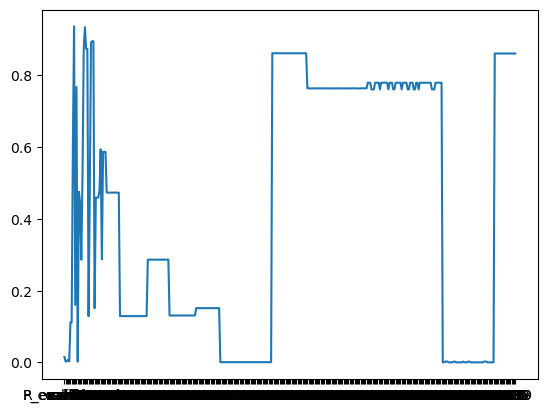

In [12]:
plt.plot(na_columns[na_columns>0]/train_transaction_data.shape[0])

The categorical columns in identity data are:  ['id_23', 'id_34', 'id_35', 'id_27', 'id_28', 'id_37', 'id_31', 'id_12', 'DeviceInfo', 'id_33', 'id_16', 'id_30', 'id_38', 'id_15', 'id_29', 'DeviceType', 'id_36']


D:\Anaconda\Documents\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Anaconda\Documents\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Anaconda\Documents\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level functi

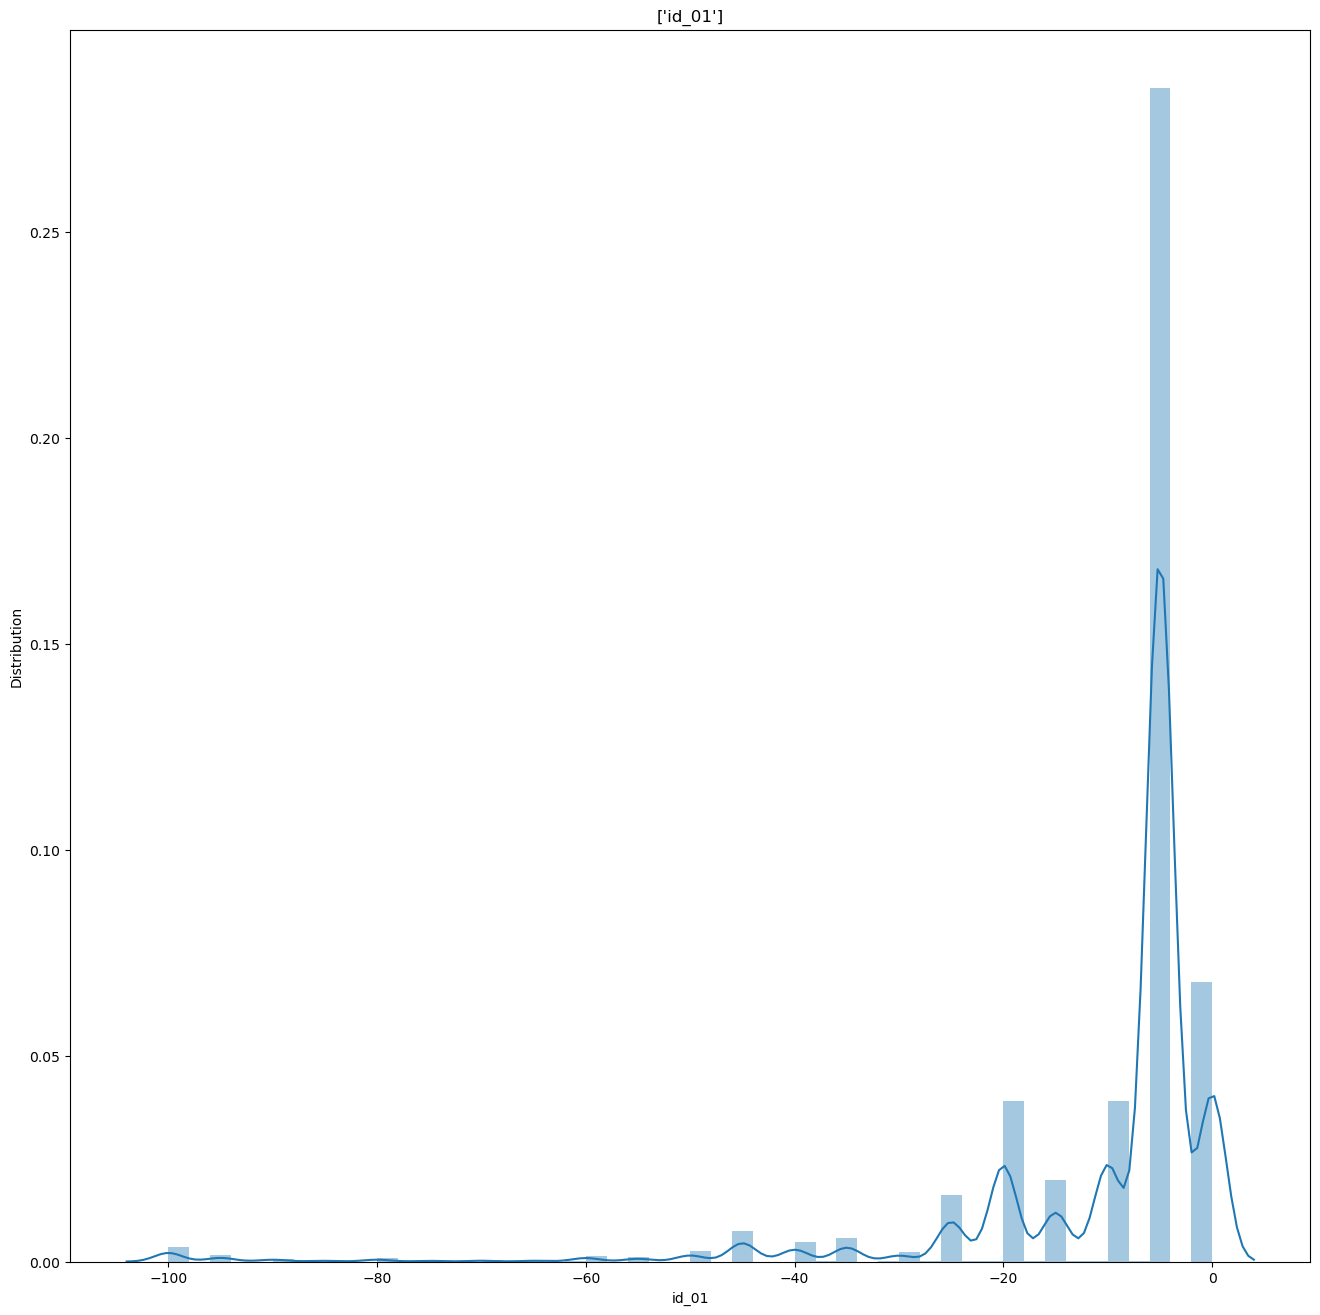

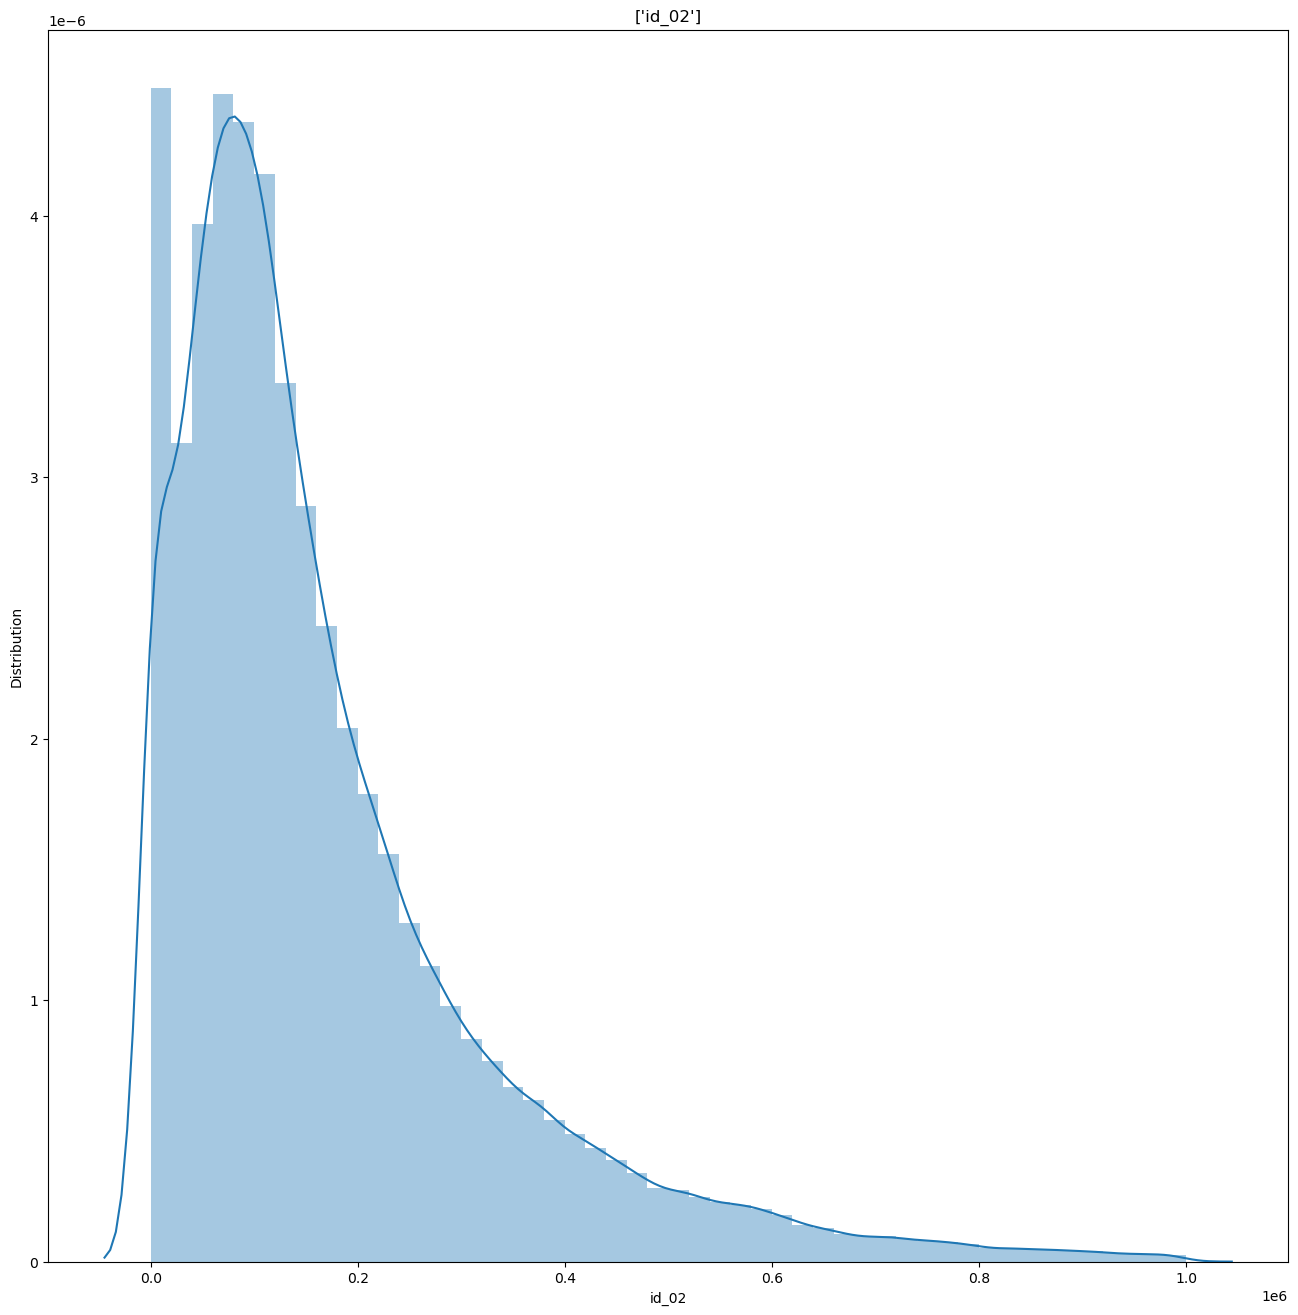

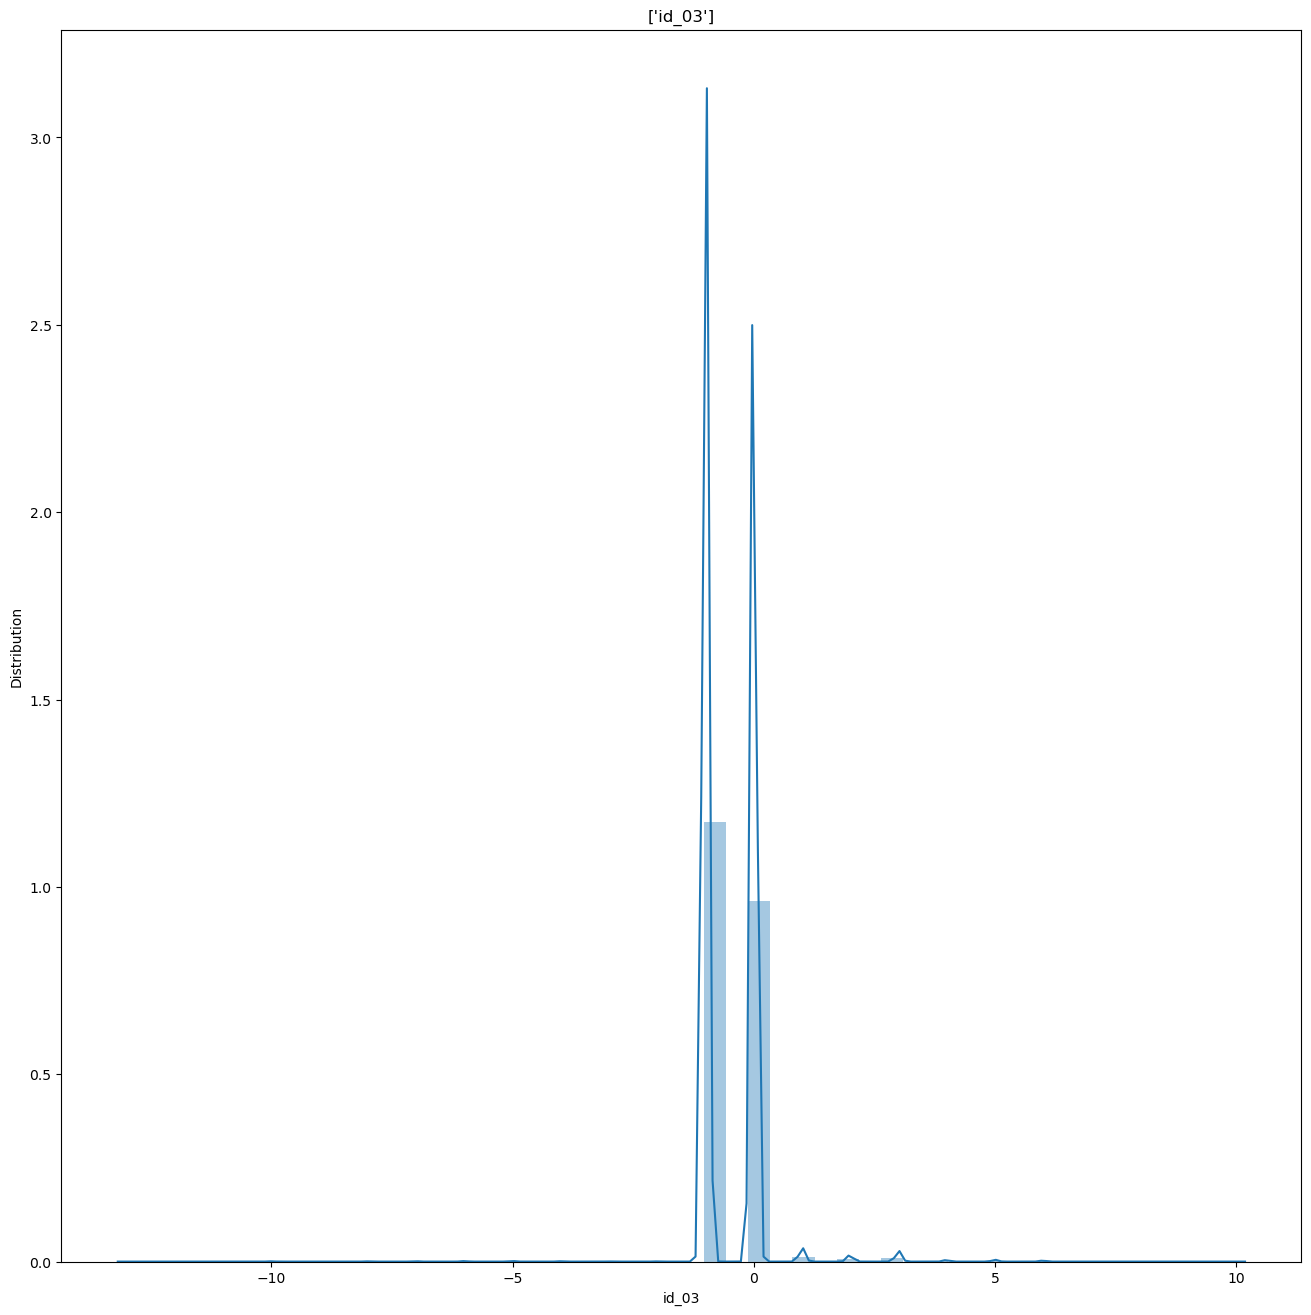

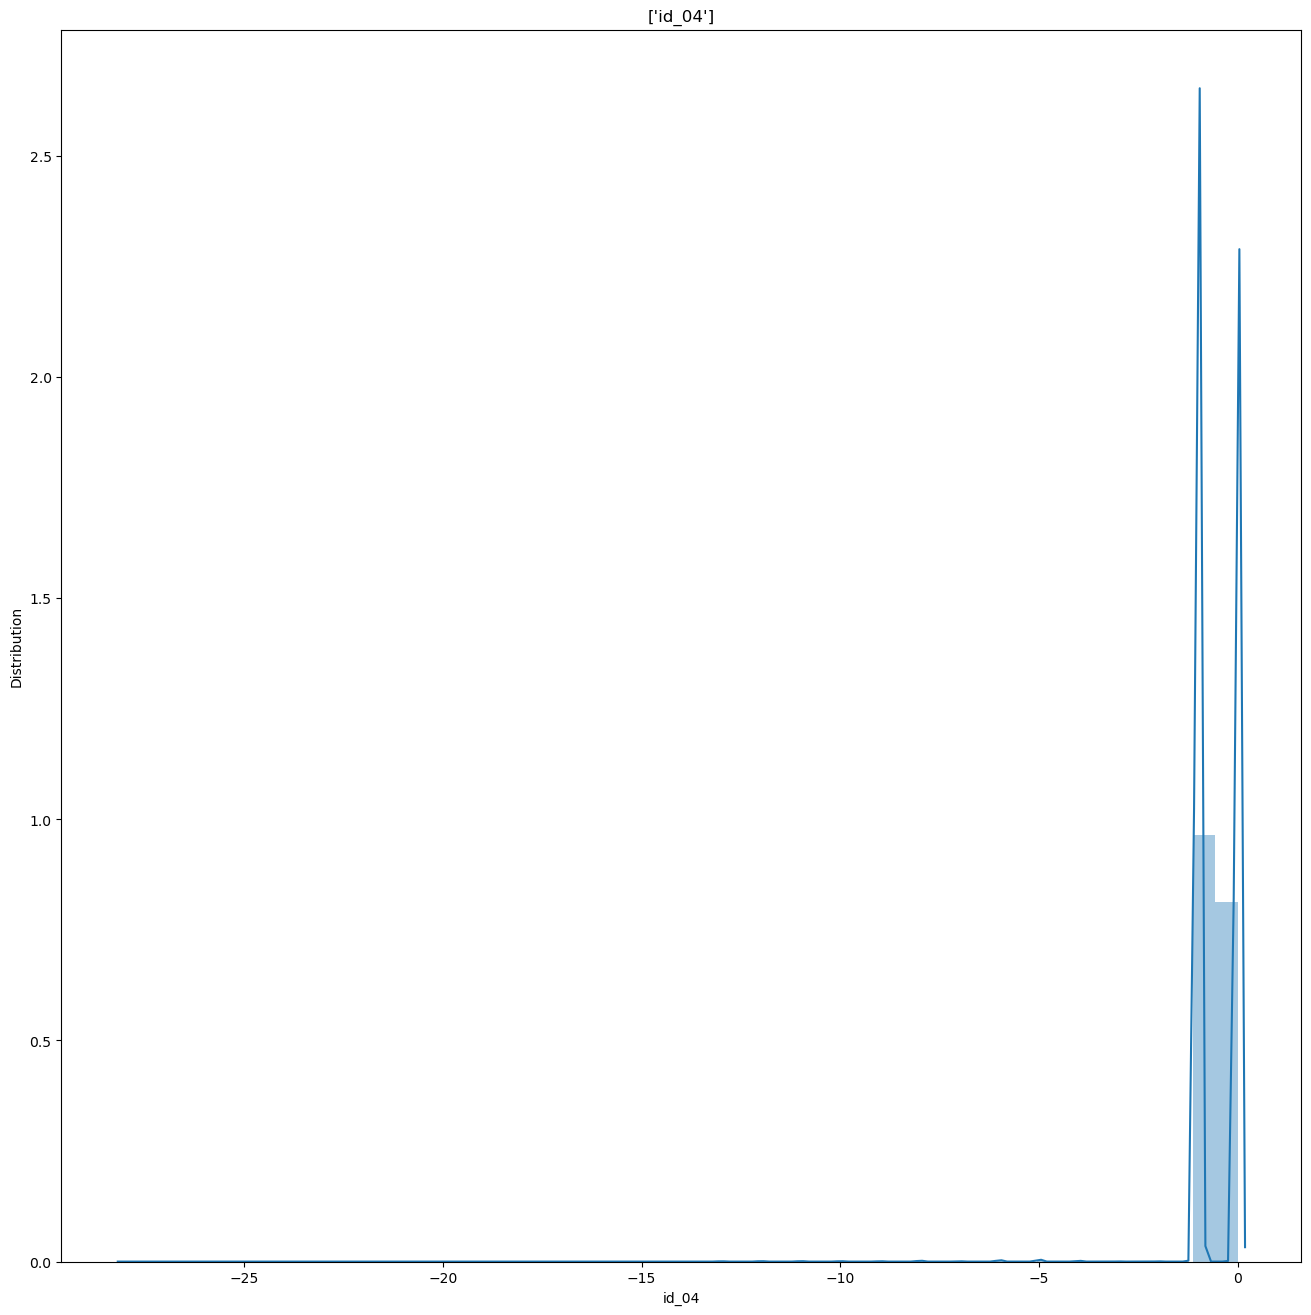

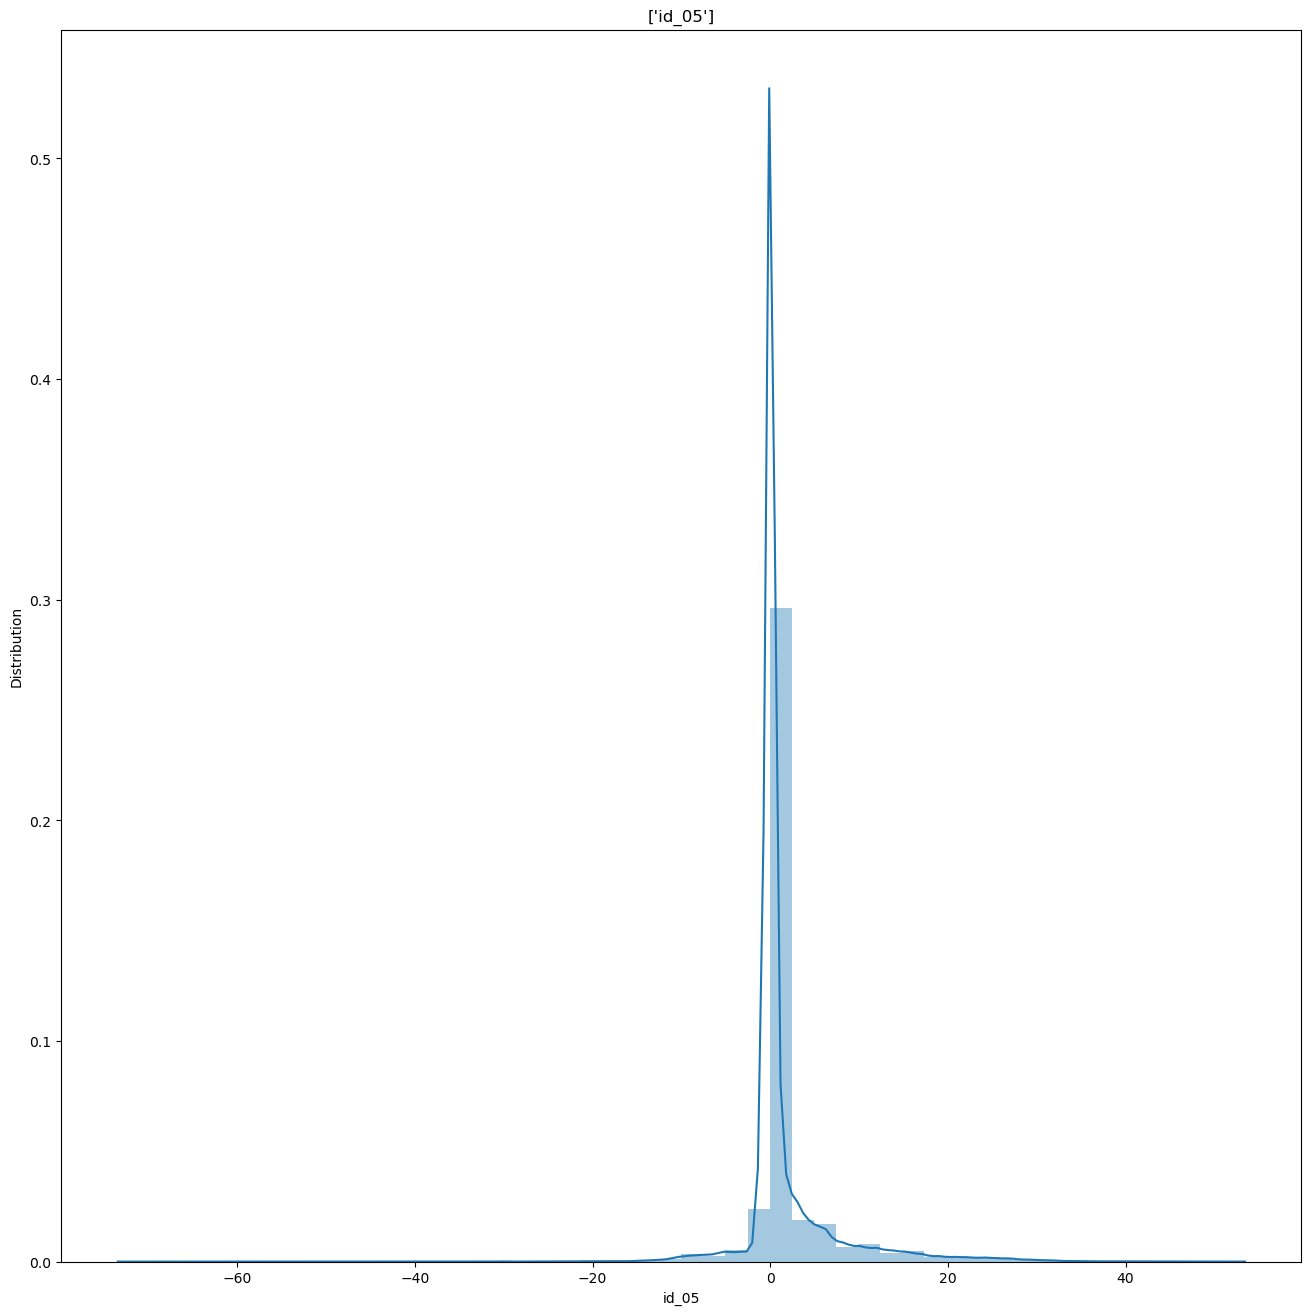

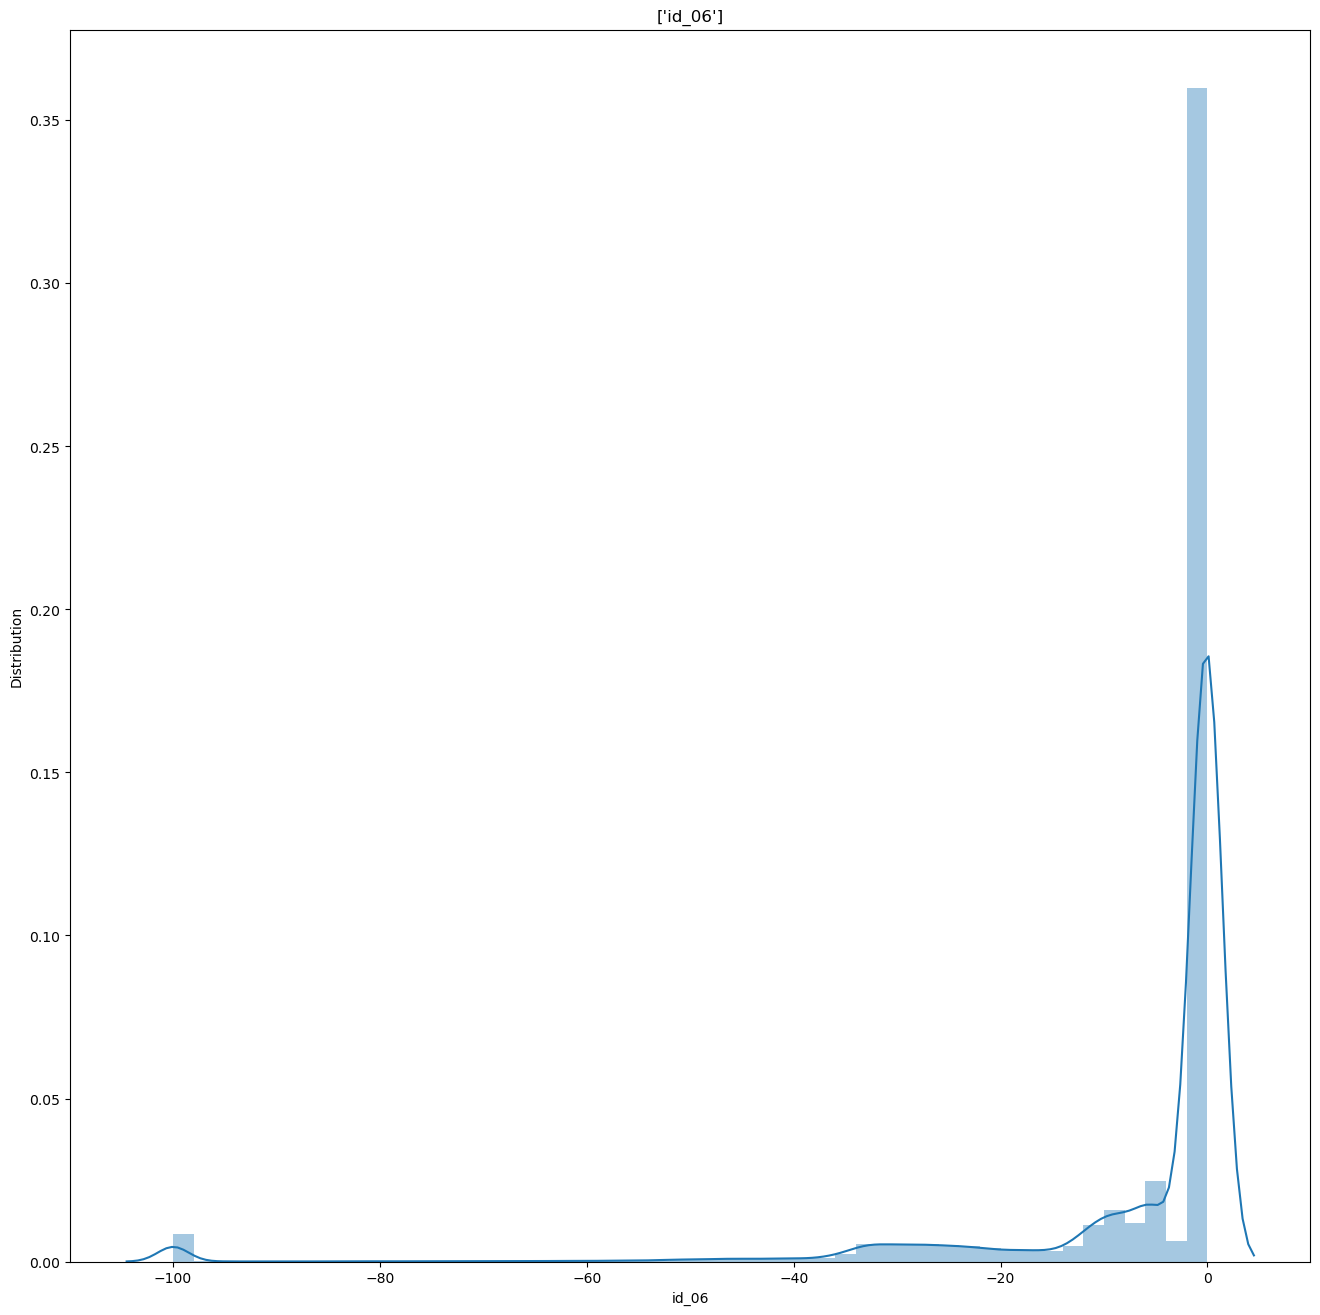

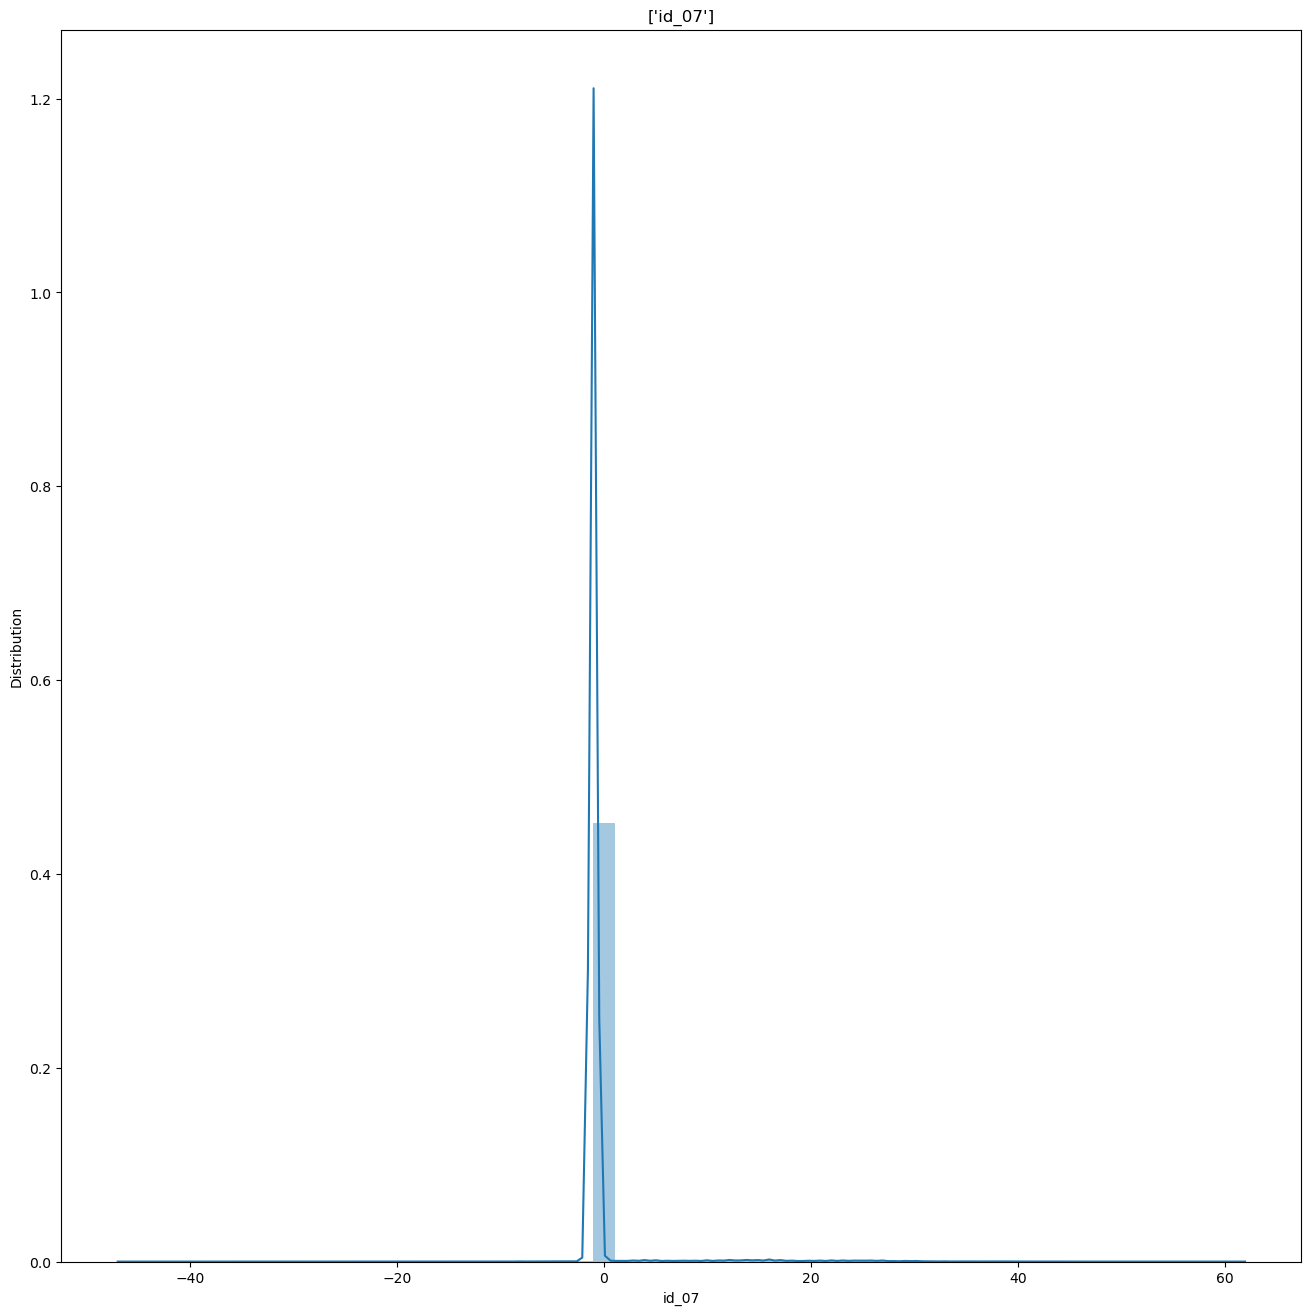

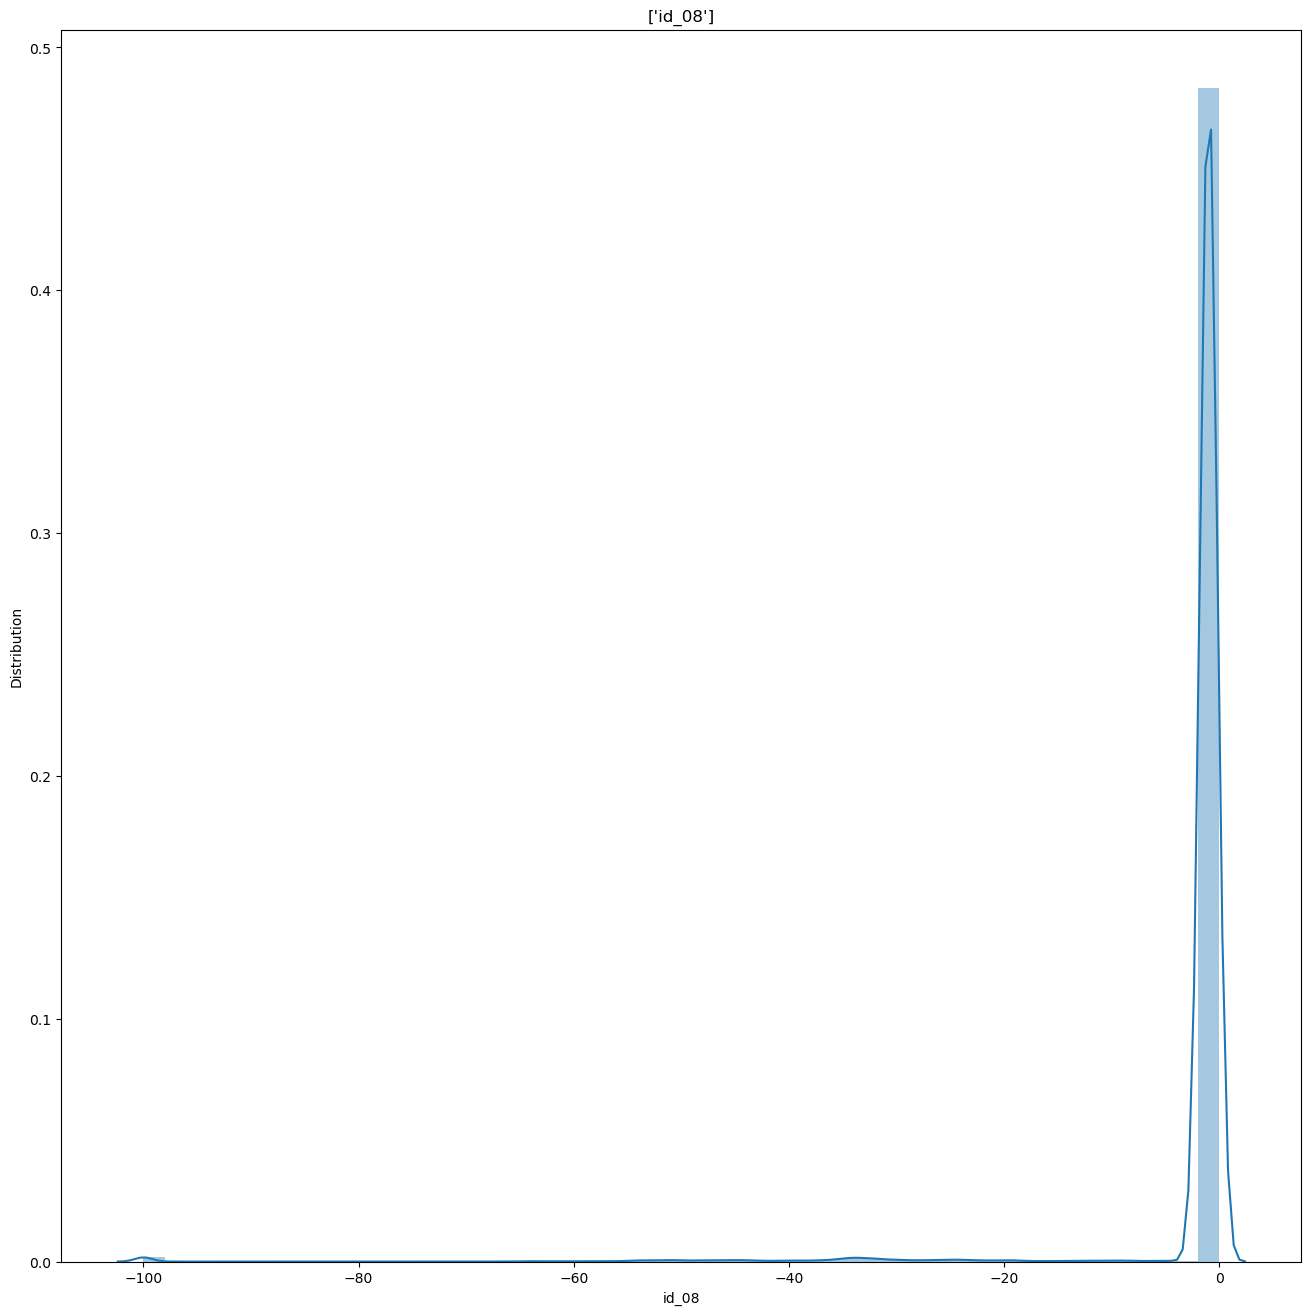

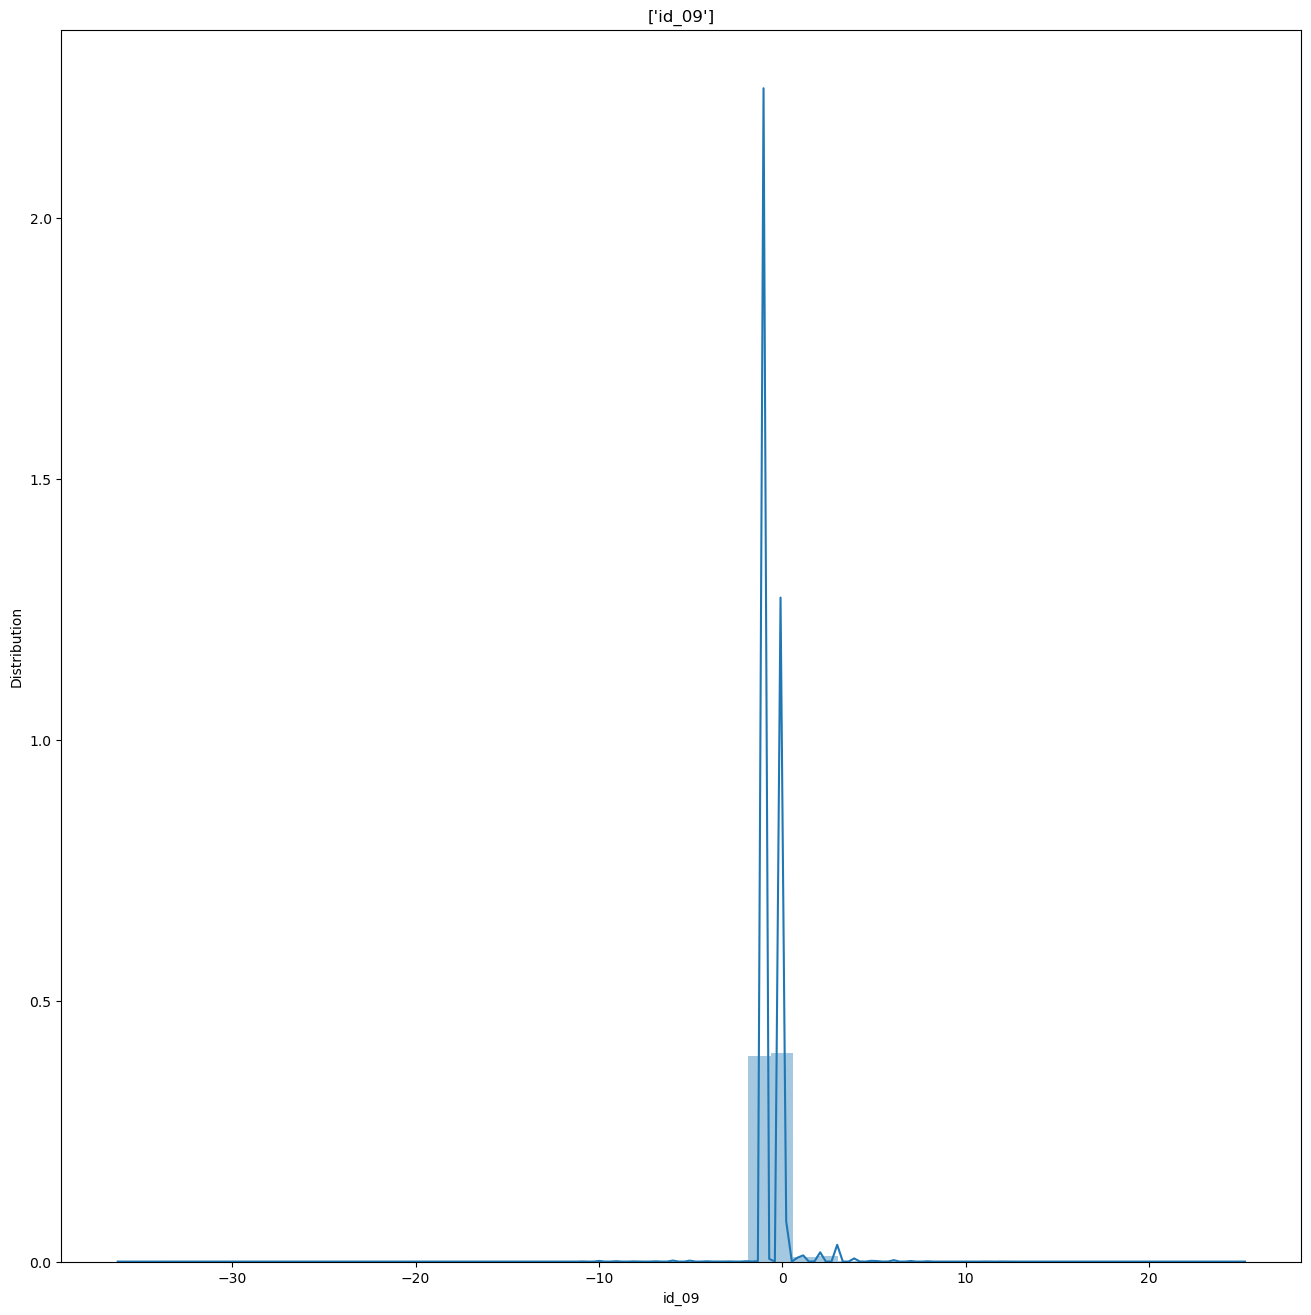

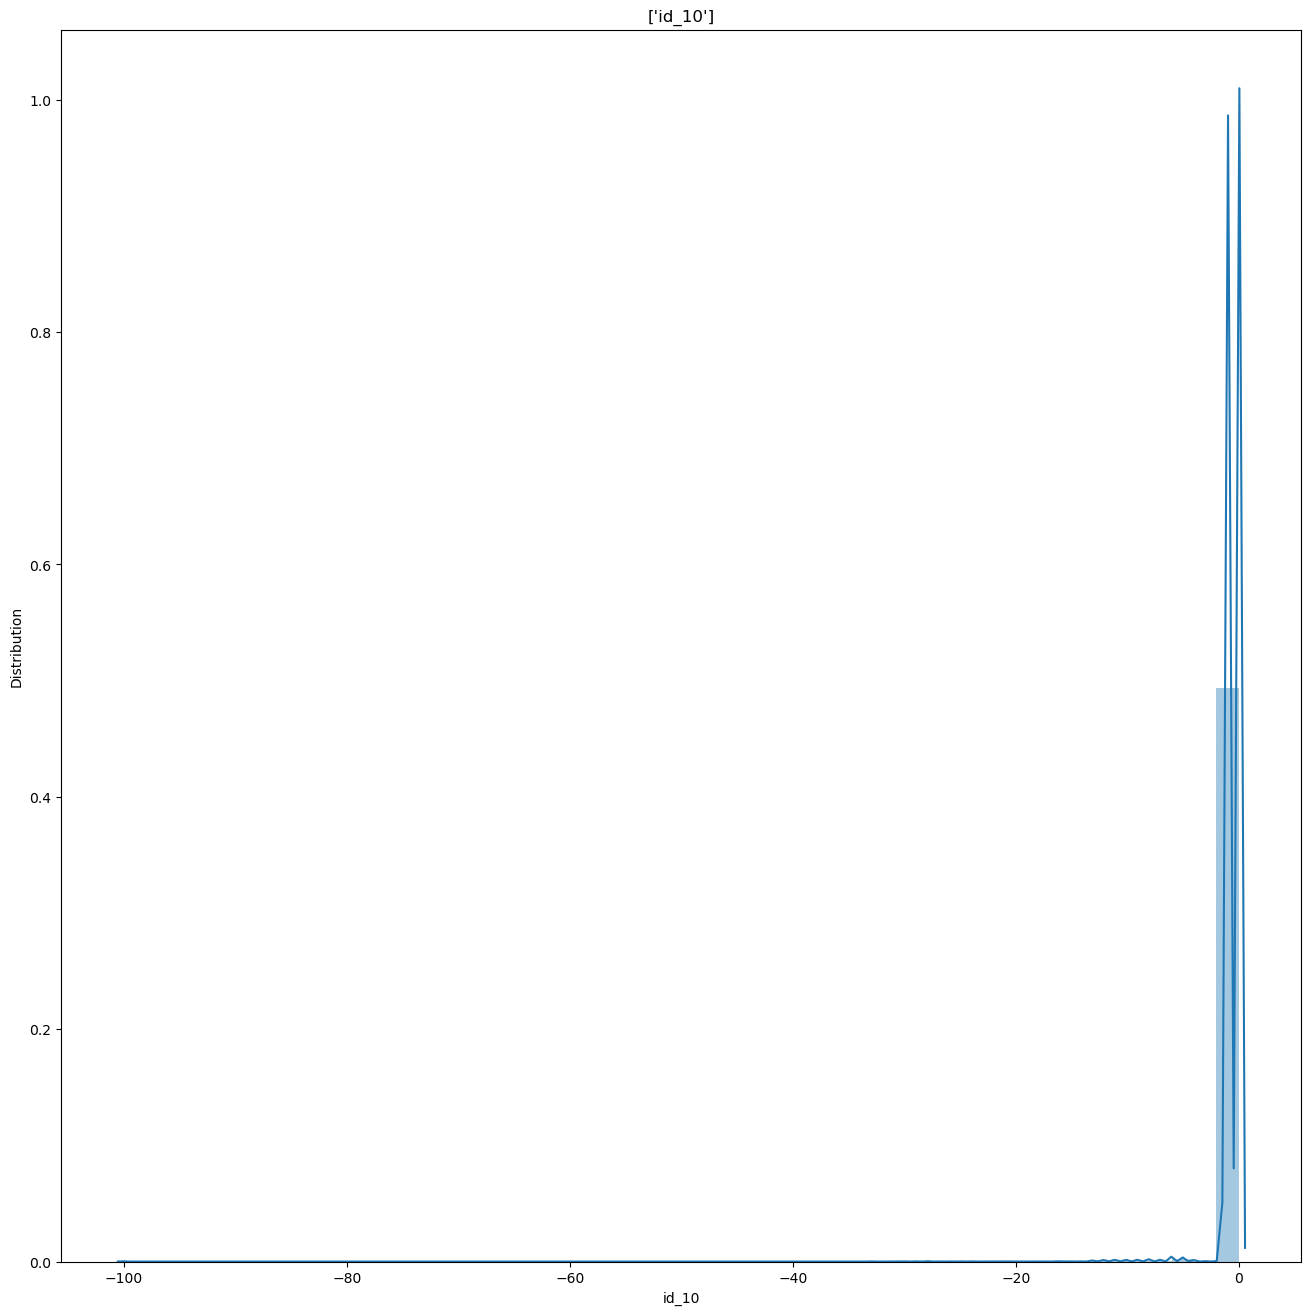

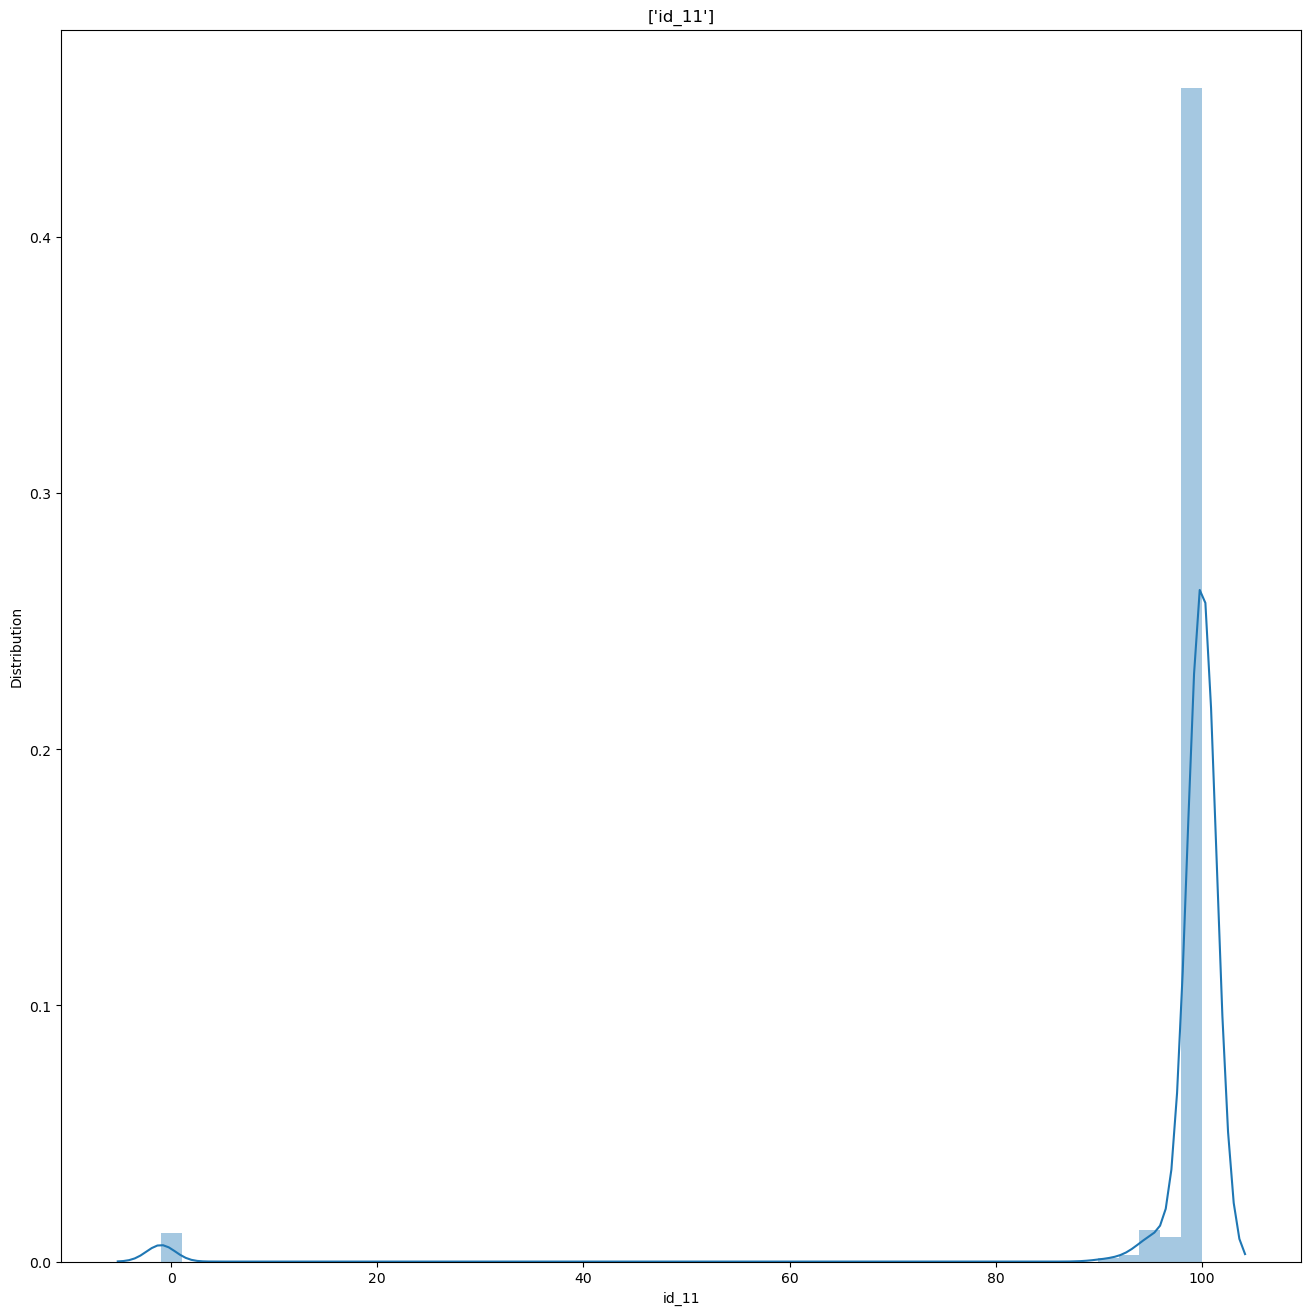

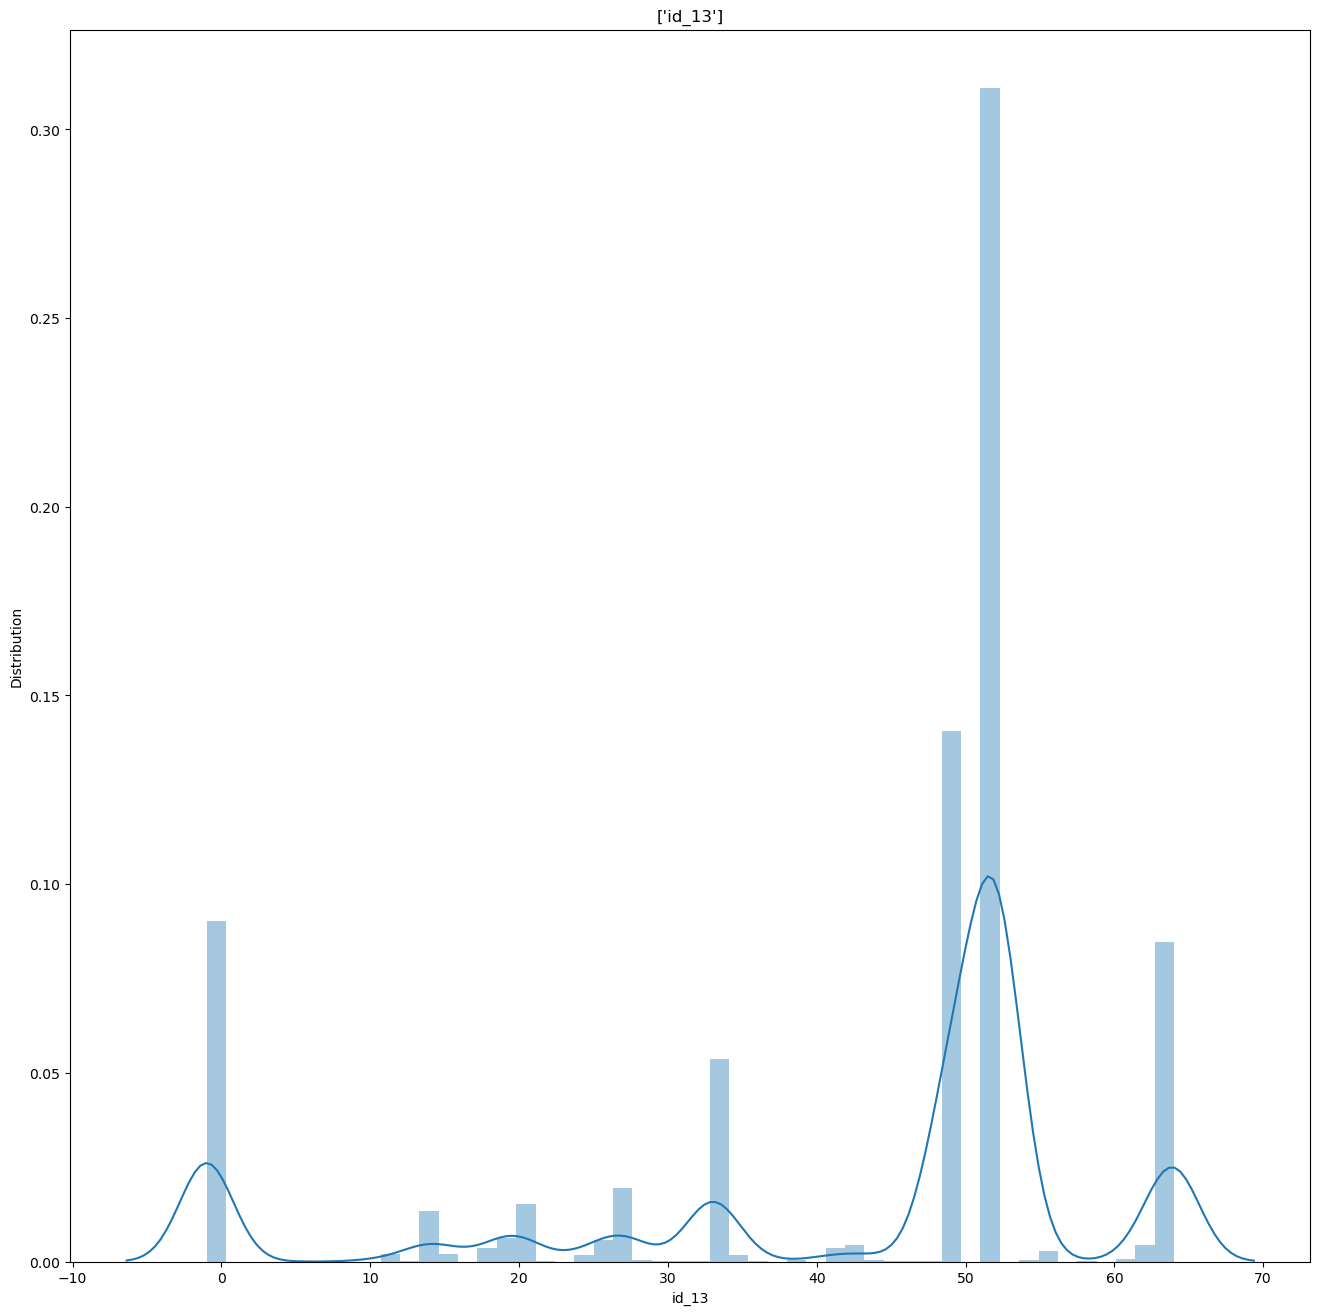

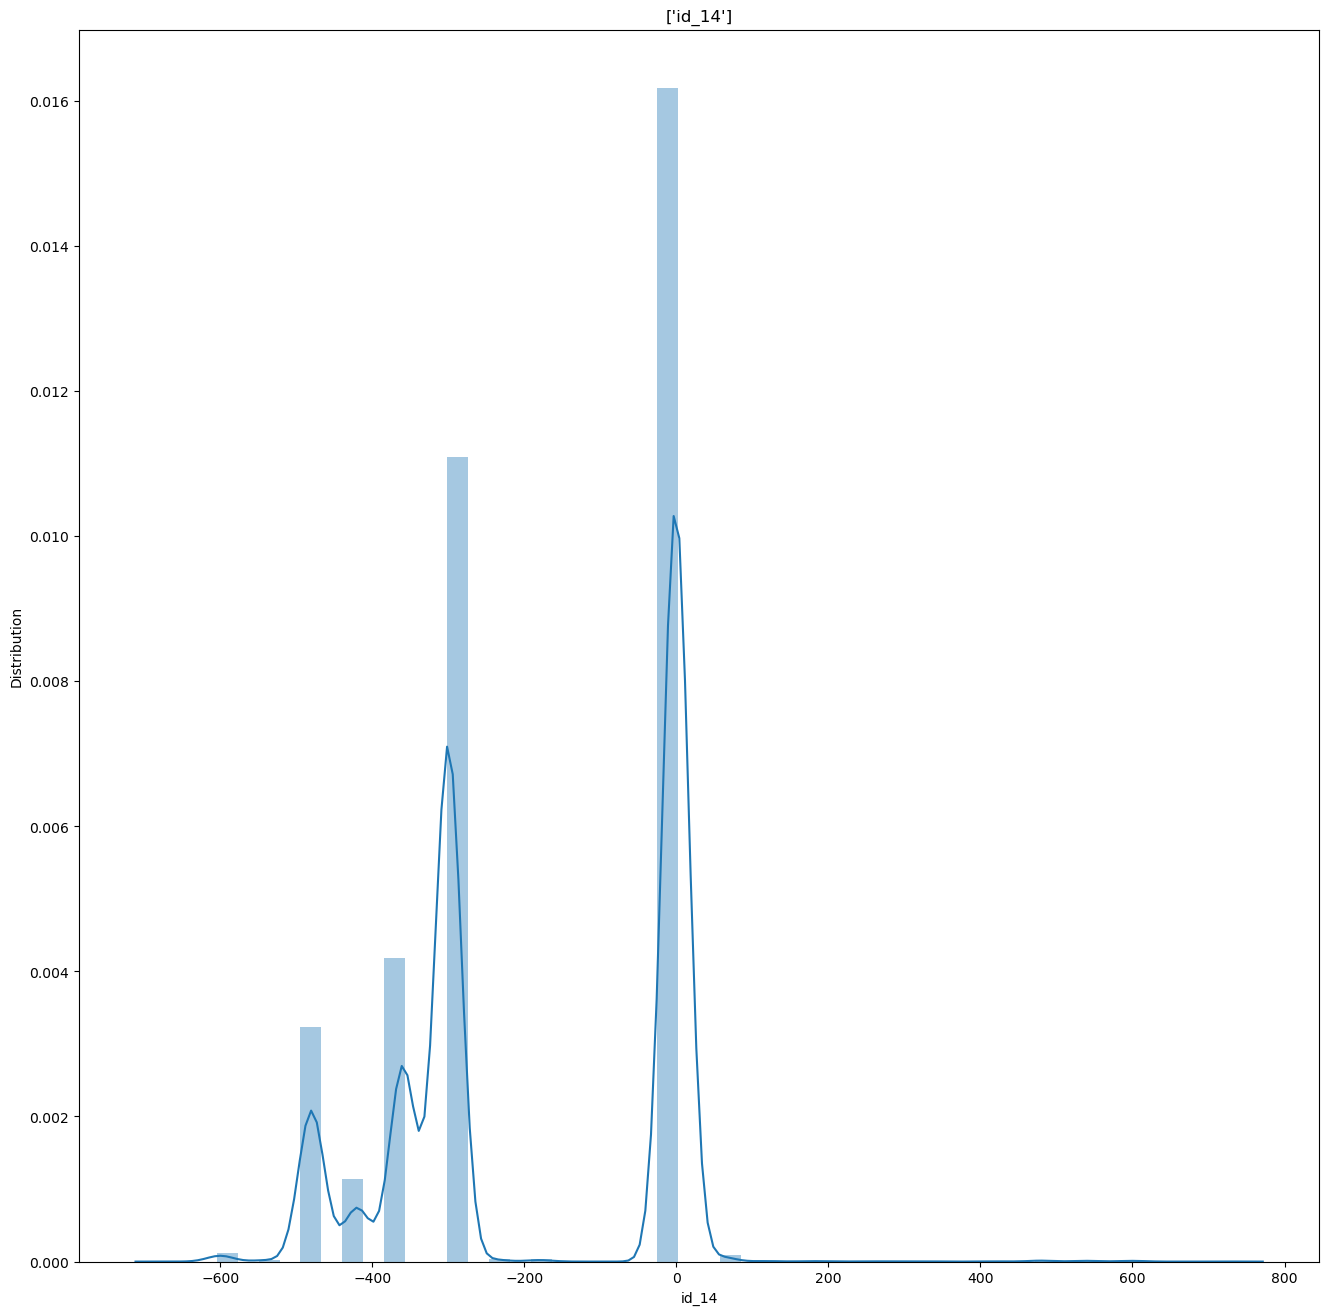

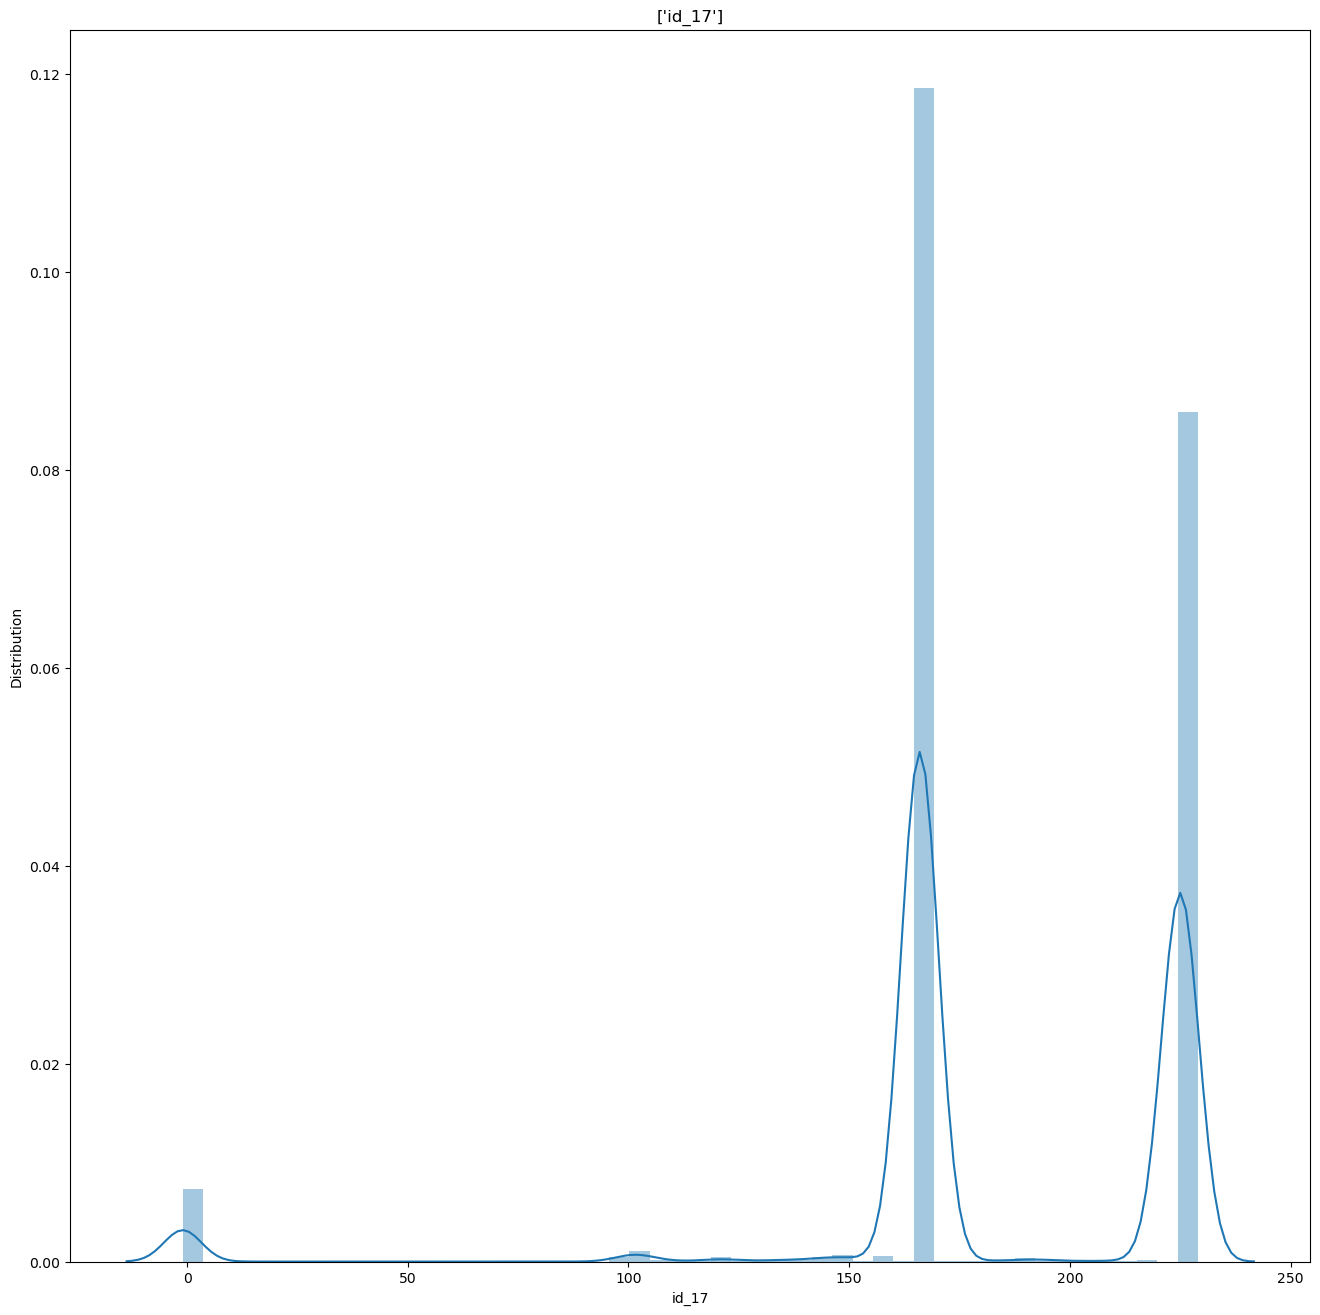

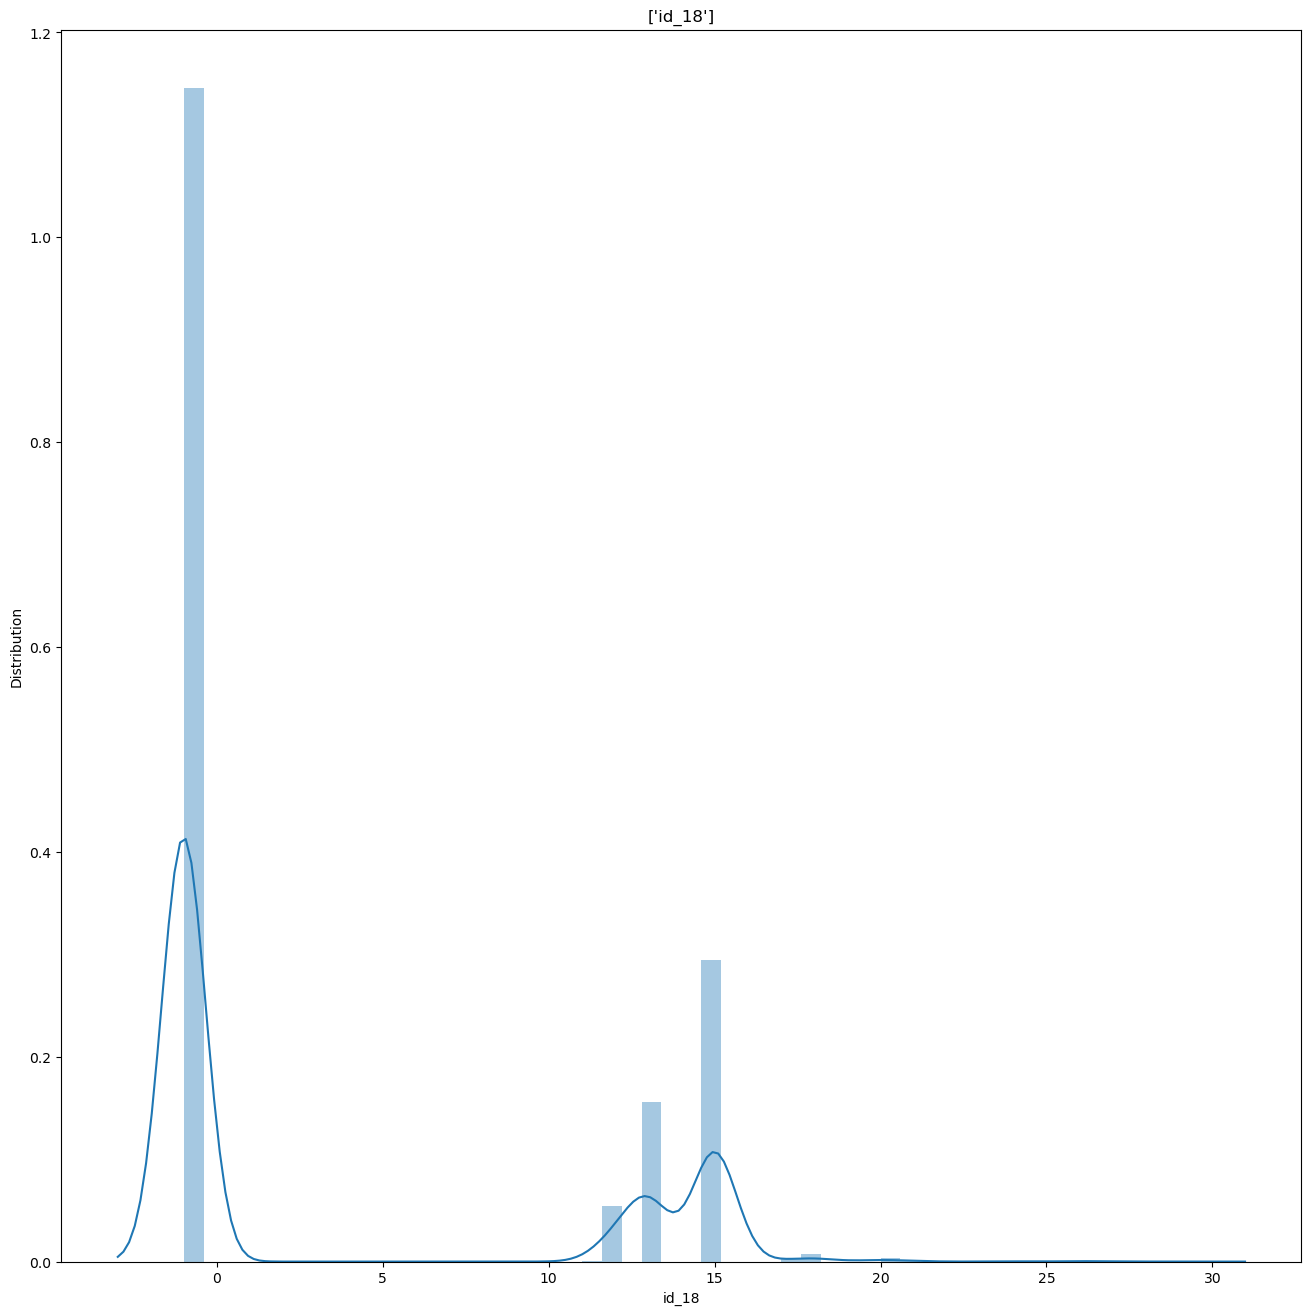

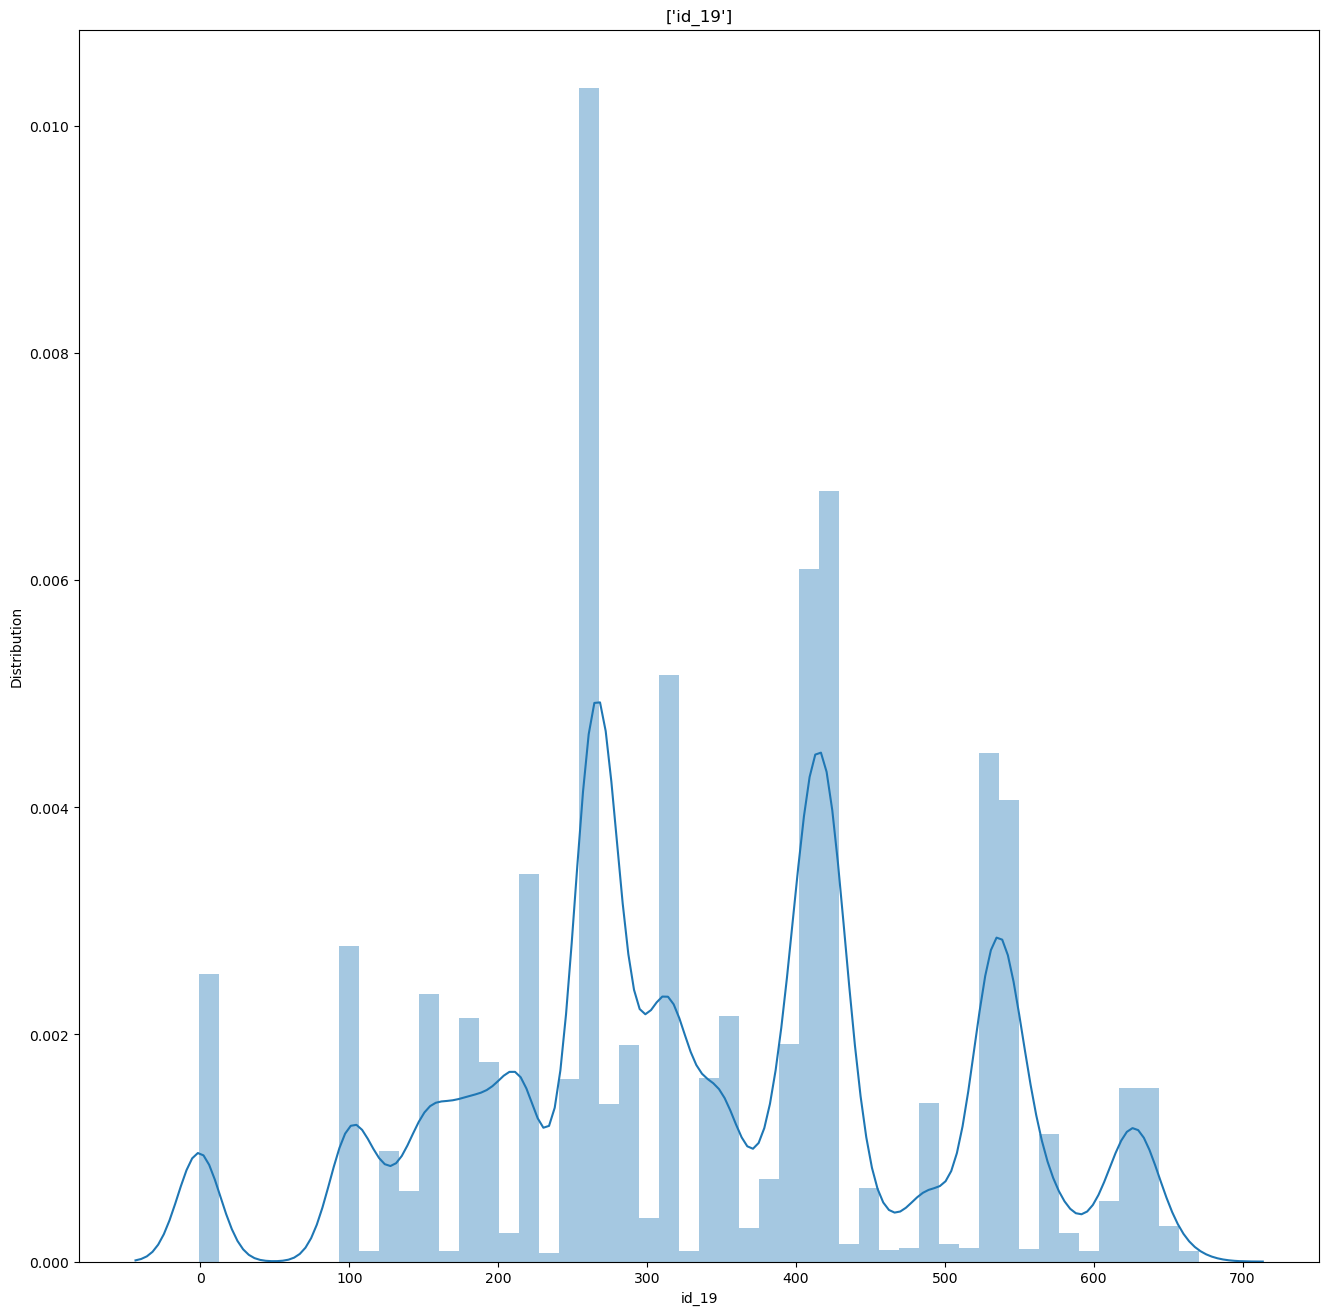

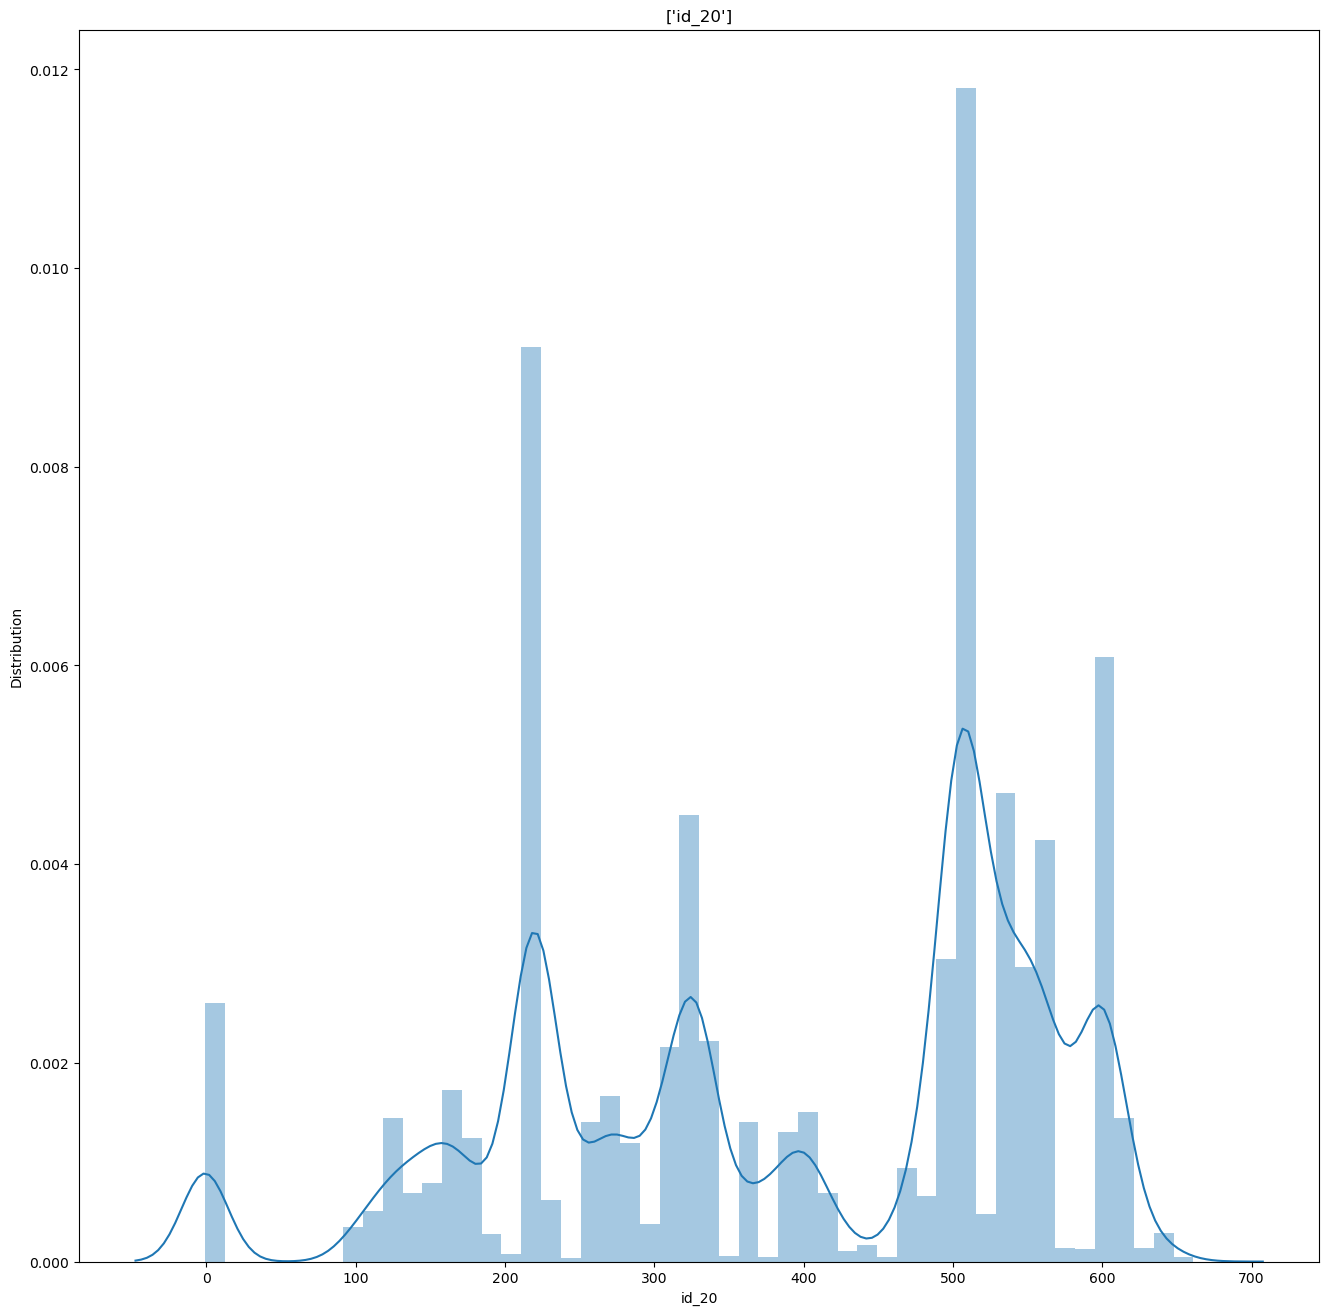

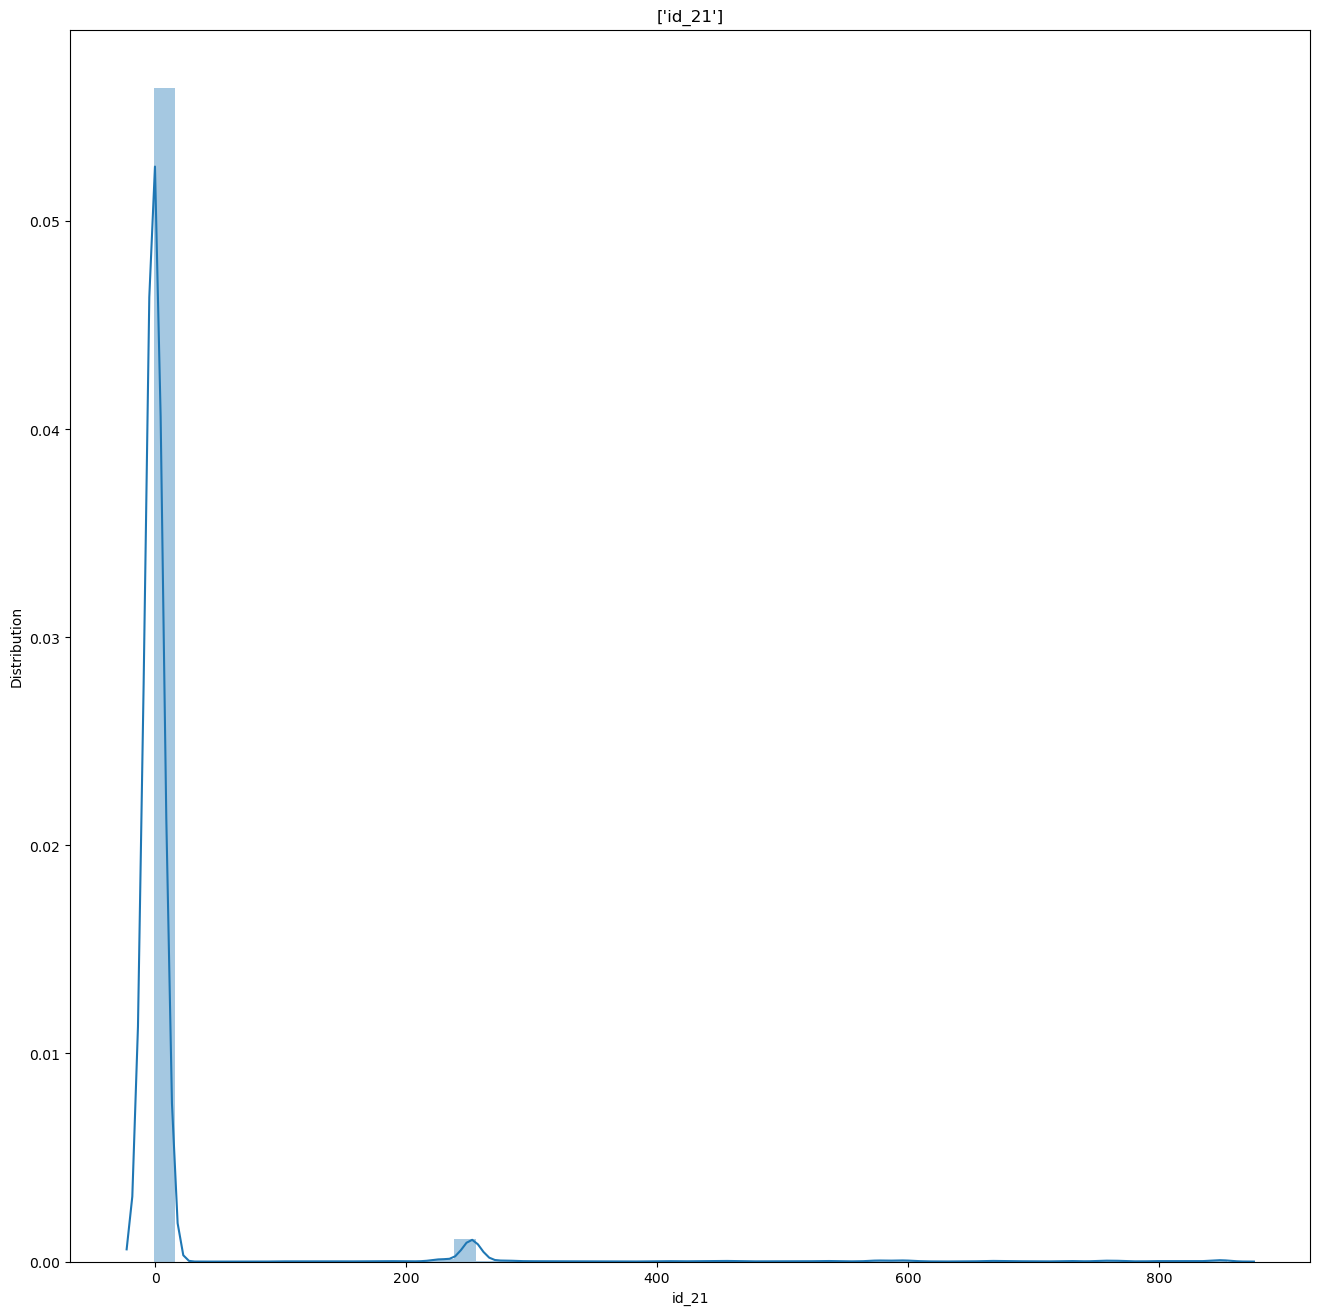

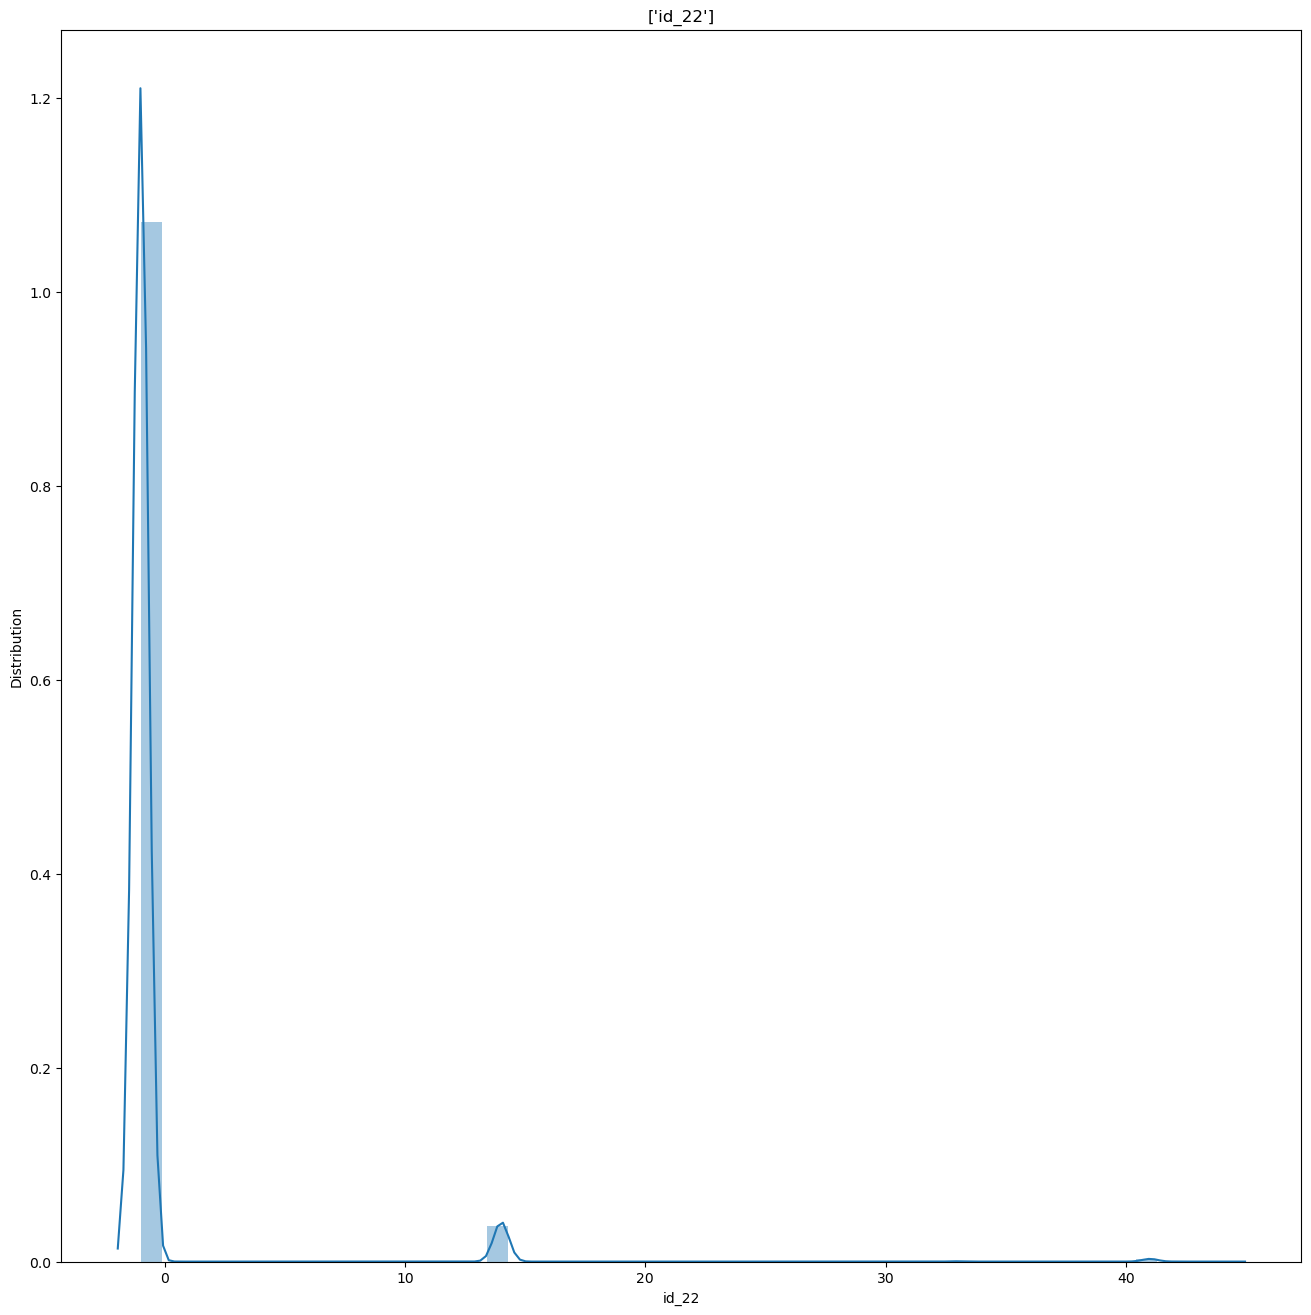

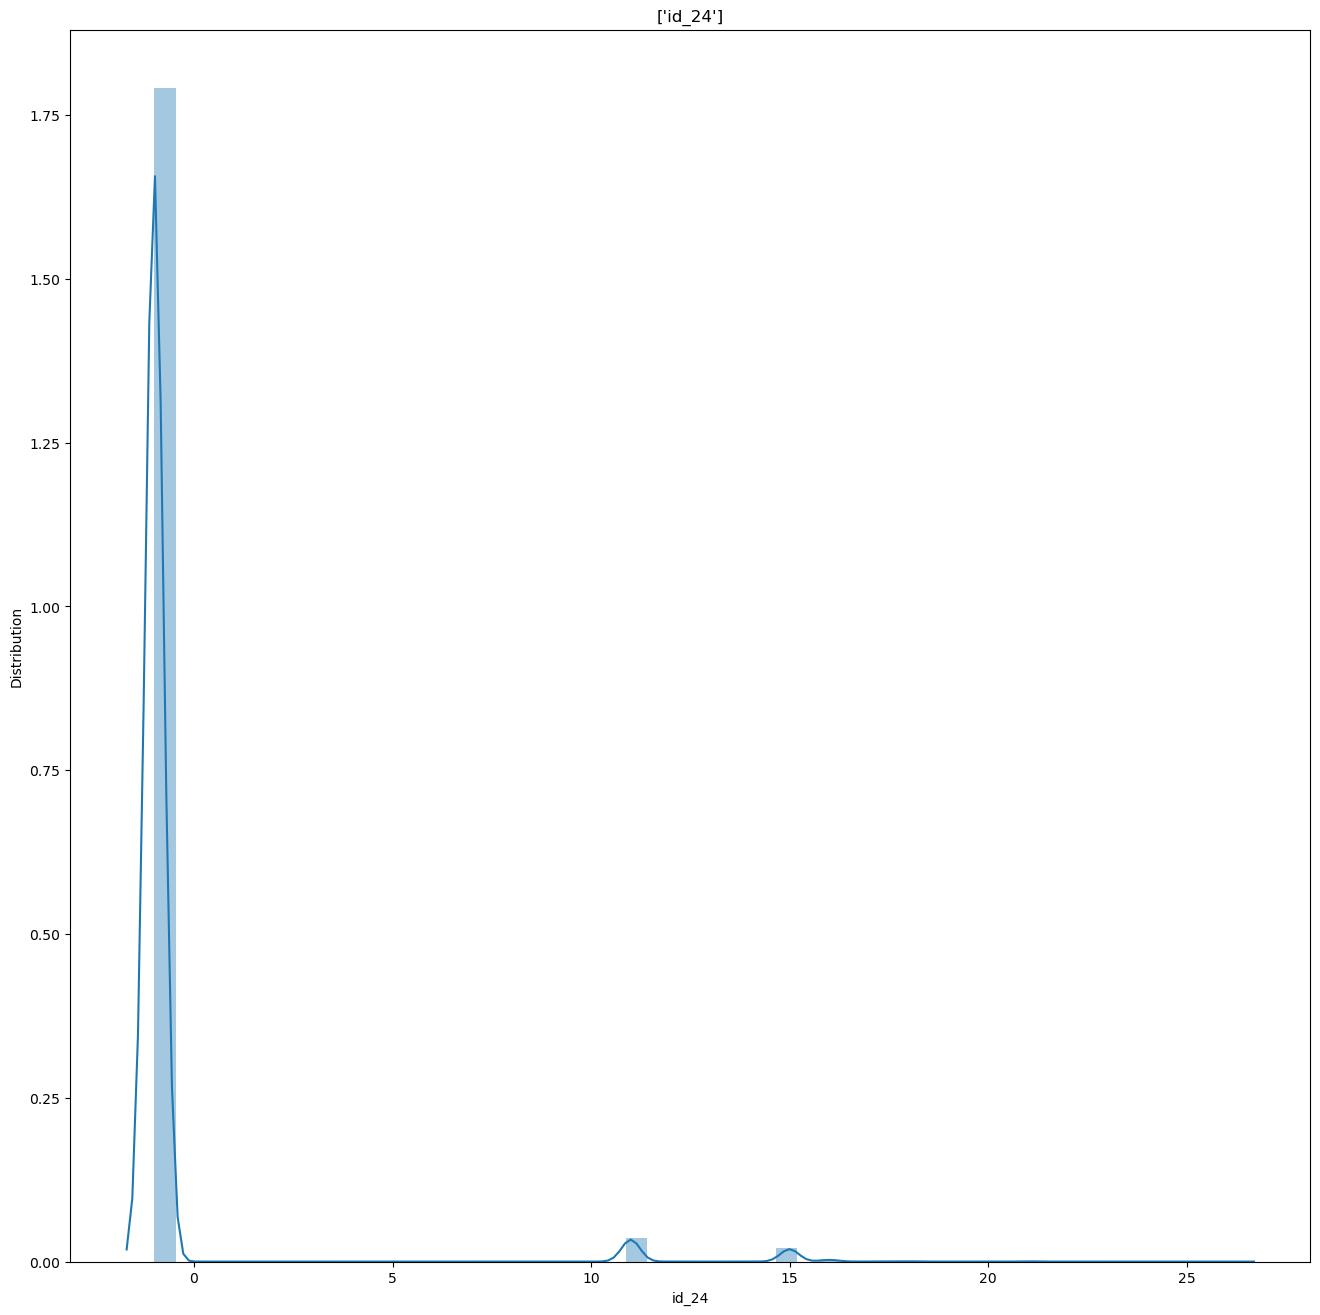

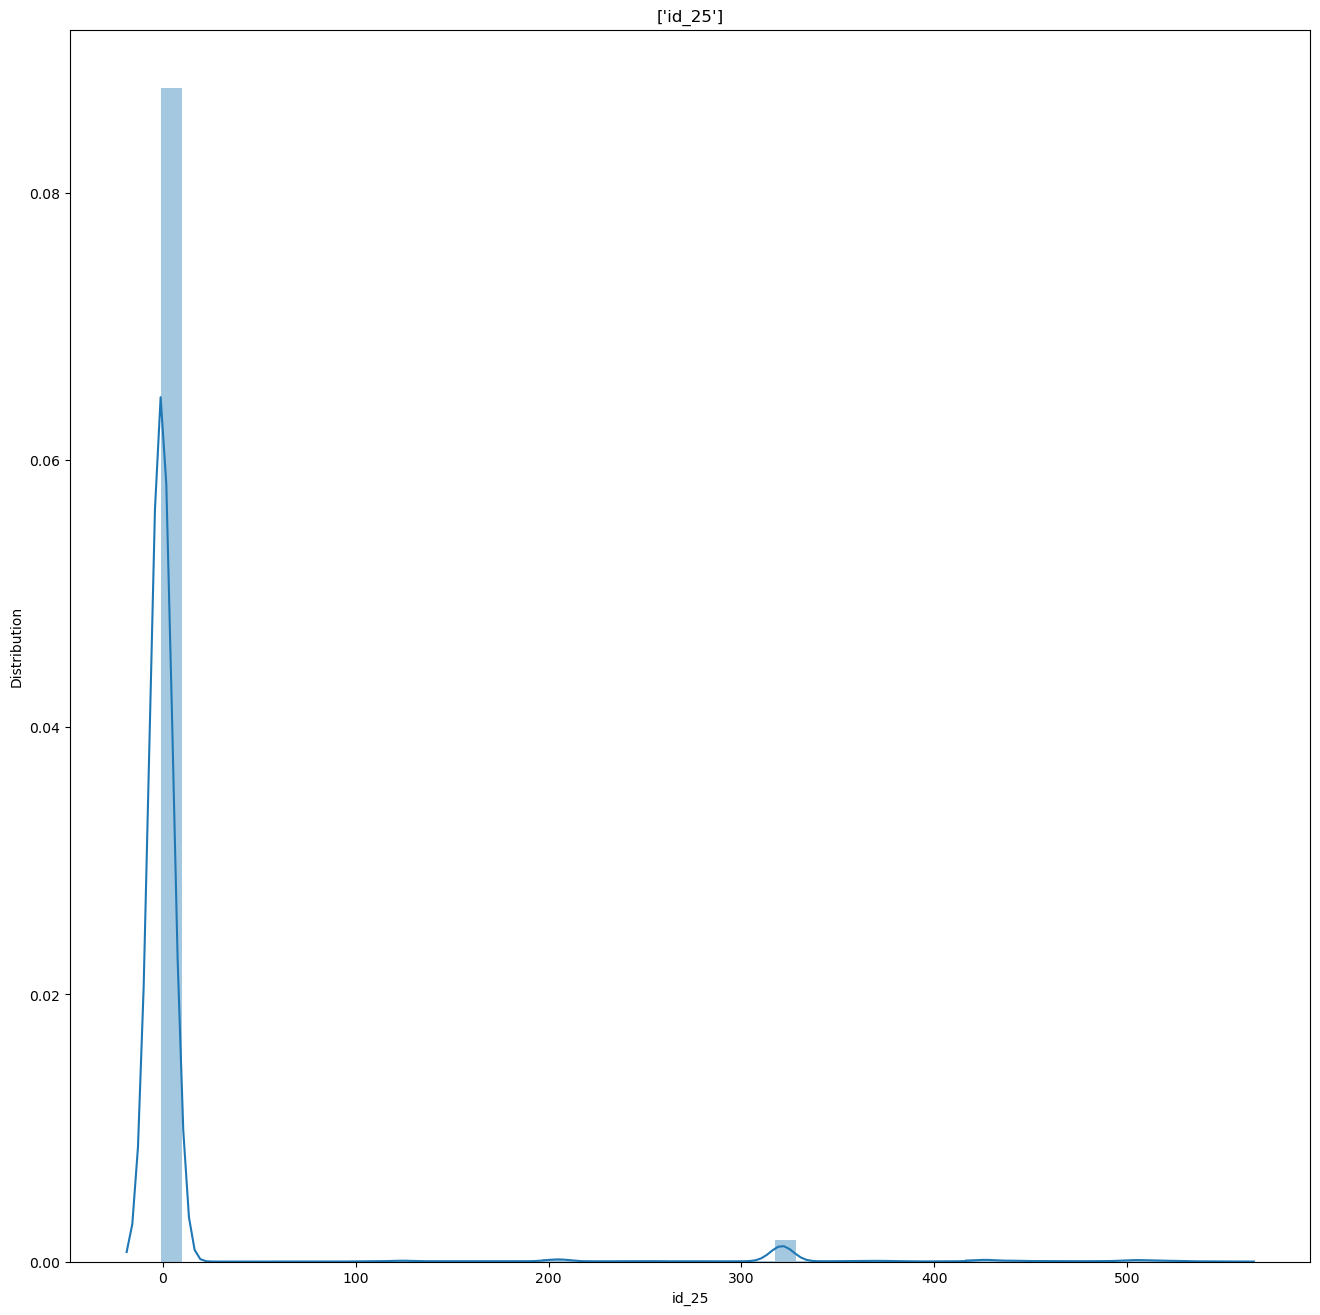

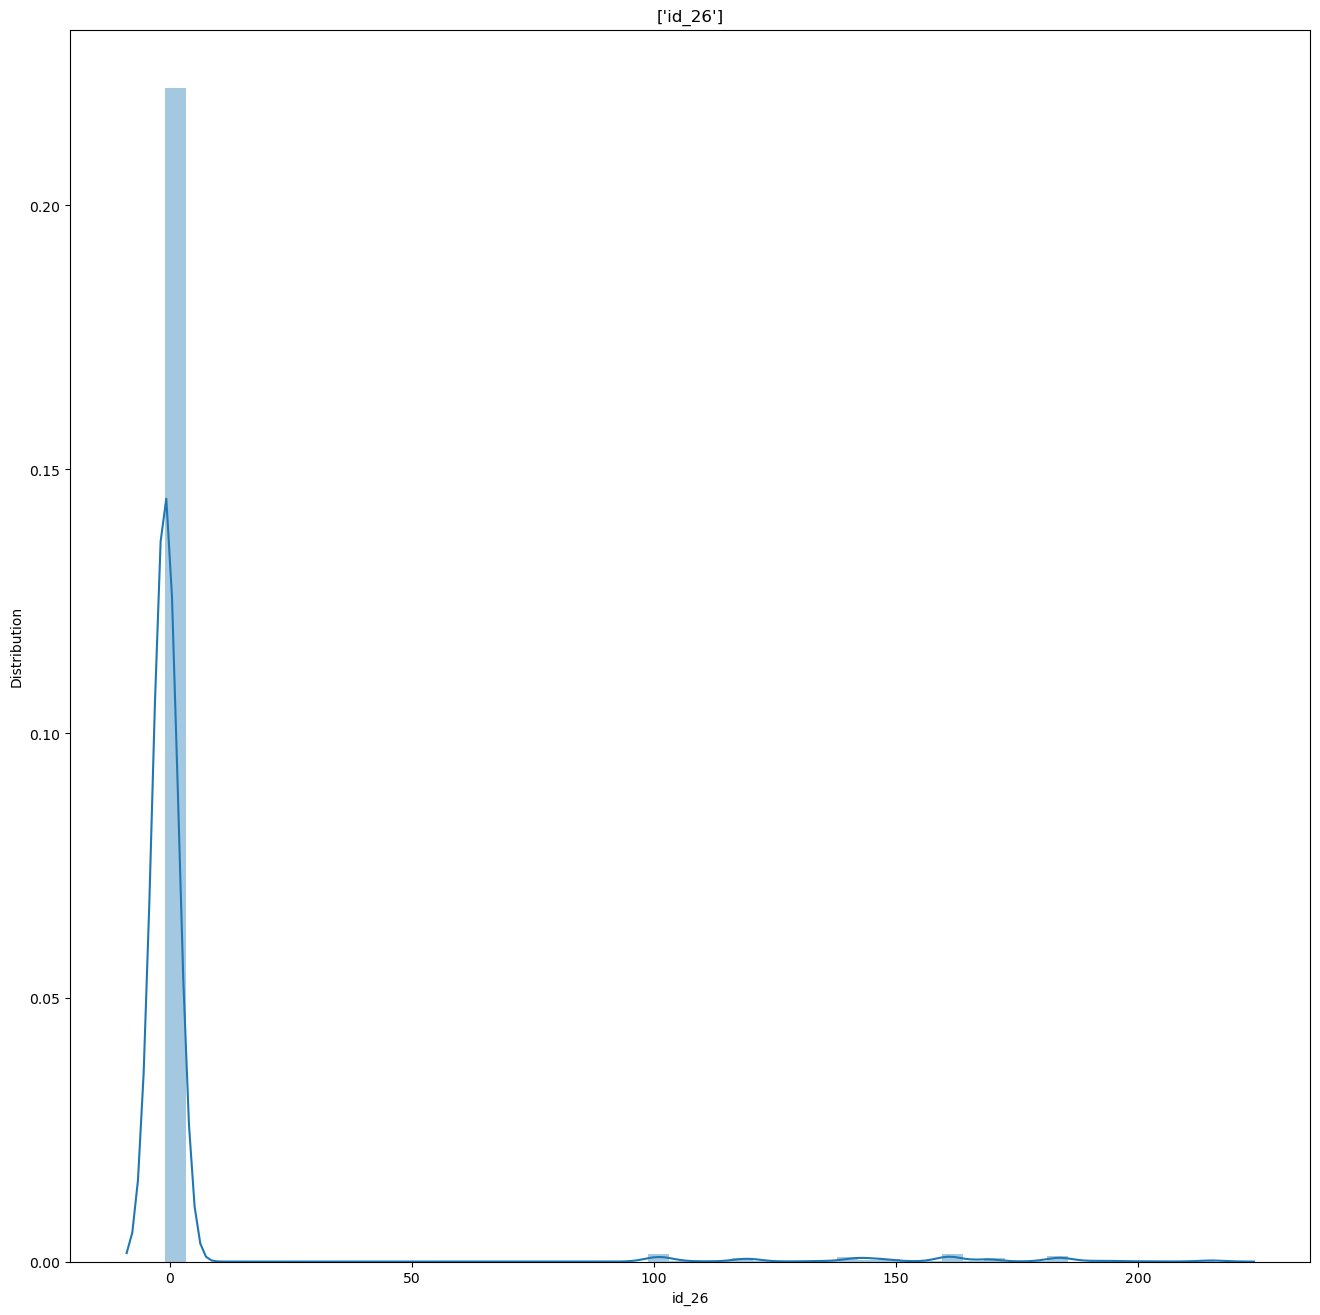

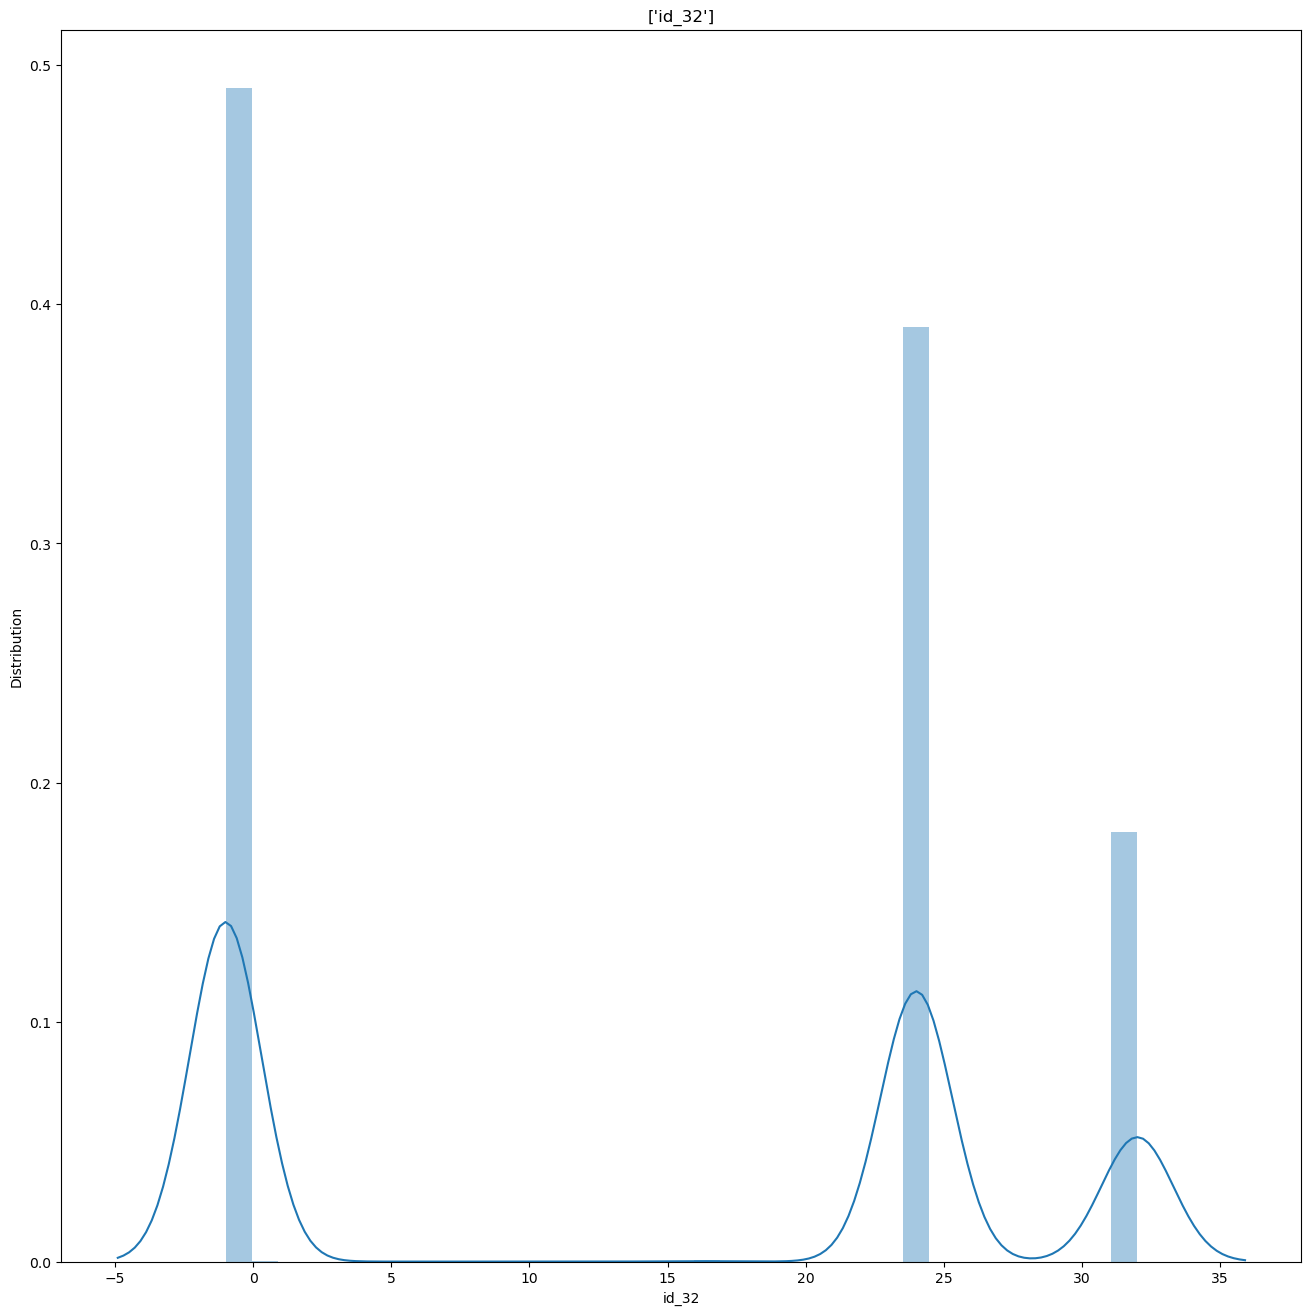

In [13]:
identity_data_columns = train_identity_data.columns
numericCols = train_identity_data._get_numeric_data().columns
categoricalCols = list(set(identity_data_columns) - set(numericCols))
print('The categorical columns in identity data are: ',categoricalCols)
train_identity_data[categoricalCols] = train_identity_data[categoricalCols].replace({ np.nan:'missing'})
train_identity_data[numericCols] = train_identity_data[numericCols].replace({ np.nan:-1})
colstoplot = ['id_01','id_02','id_03','id_04','id_05','id_06','id_07','id_08','id_09','id_10',
              'id_11','id_13','id_14','id_17','id_18','id_19','id_20','id_21','id_22','id_24','id_25','id_26','id_32']
for i in colstoplot:  
    plt.figure(figsize=(16, 16))
    ax = sns.distplot(eval('train_identity_data["'+i+'"]'))
    ax.set(ylabel="Distribution")
    ax.set_title([i])    

D:\Anaconda\Documents\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='id_01', ylabel='Density'>

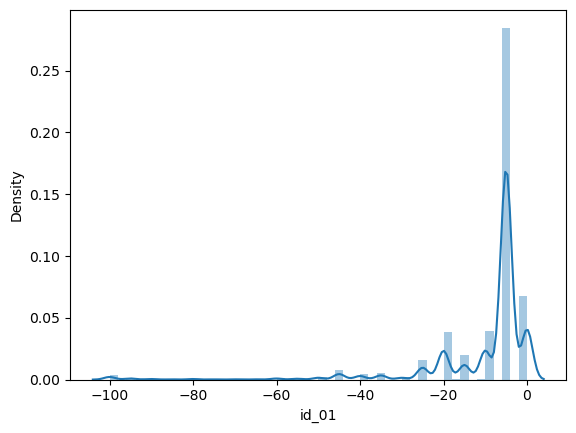

In [14]:
sns.distplot(train_identity_data['id_01'])

In [15]:
transaction_data_columns = train_transaction_data.columns
numericCols = train_transaction_data._get_numeric_data().columns
categoricalCols = list(set(transaction_data_columns) - set(numericCols))
print('The categorical columns in transaction data are: ',categoricalCols)

The categorical columns in transaction data are:  ['M1', 'P_emaildomain', 'R_emaildomain', 'M8', 'M9', 'M6', 'M7', 'M4', 'card6', 'card4', 'M3', 'M5', 'M2', 'ProductCD']


In [16]:
train_transaction_data[categoricalCols] = train_transaction_data[categoricalCols].replace({ np.nan:'missing'})
train_transaction_data[numericCols] = train_transaction_data[numericCols].replace({ np.nan:-1})

D:\Anaconda\Documents\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='isFraud', ylabel='count'>

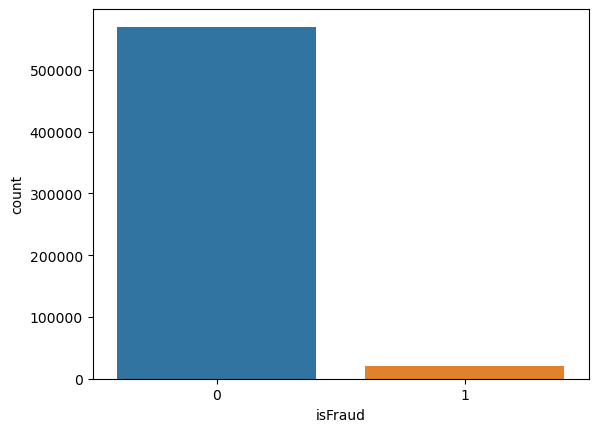

In [17]:
sns.countplot(train_transaction_data['isFraud'])

D:\Anaconda\Documents\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='card6', ylabel='count'>

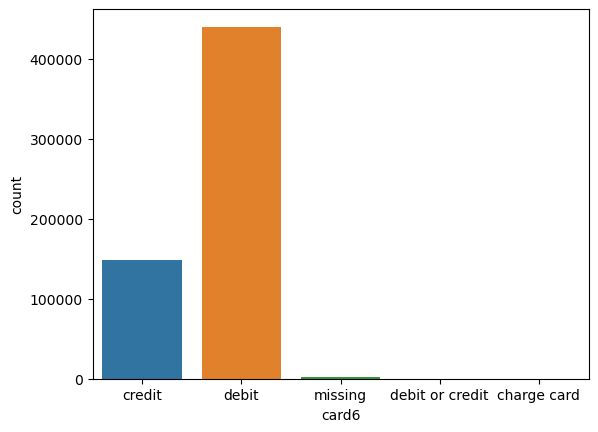

In [18]:
sns.countplot(train_transaction_data['card6'])

D:\Anaconda\Documents\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
D:\Anaconda\Documents\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
D:\Anaconda\Documents\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
D:\Anaconda\Documents\lib\site-packages\

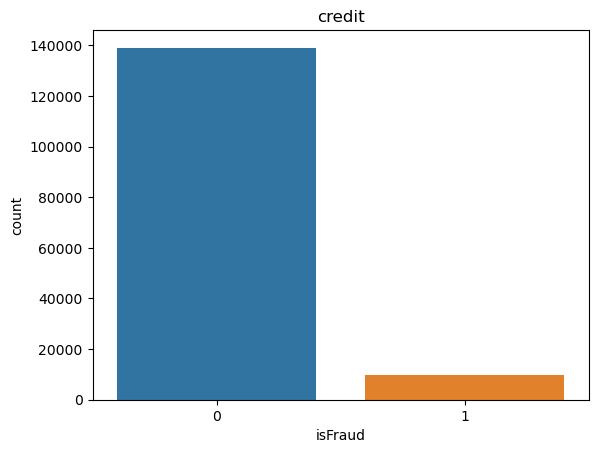

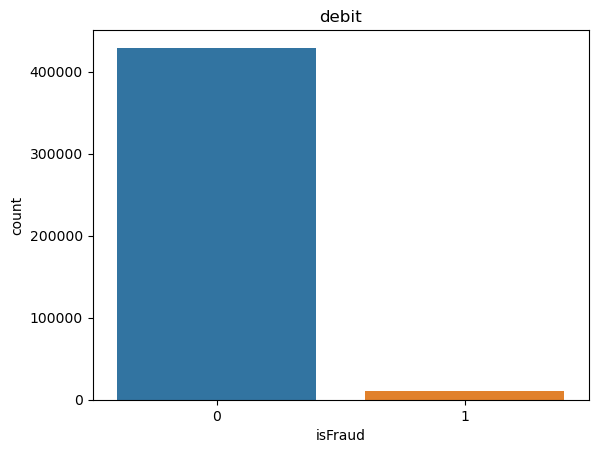

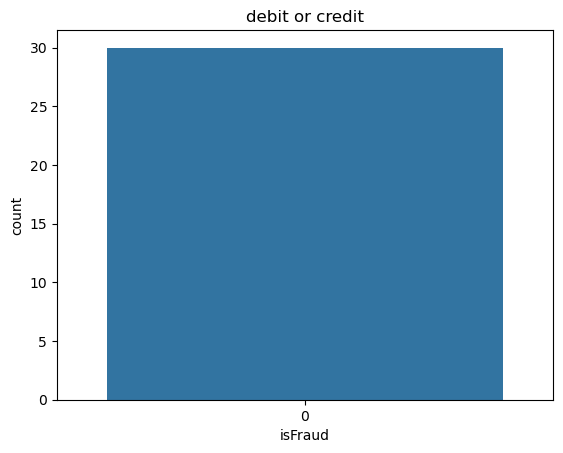

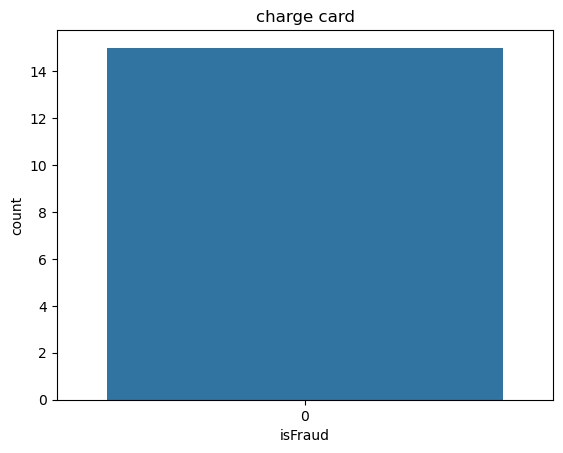

In [19]:
cardTypes = ['credit','debit','debit or credit','charge card']
for i,i_card in enumerate(cardTypes):
    cardData = eval('train_transaction_data.loc[train_transaction_data["card6"]=="'+i_card+'"]')
    plt.figure(i)
    sns.countplot(cardData['isFraud']).set_title(i_card)

D:\Anaconda\Documents\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='card4', ylabel='count'>

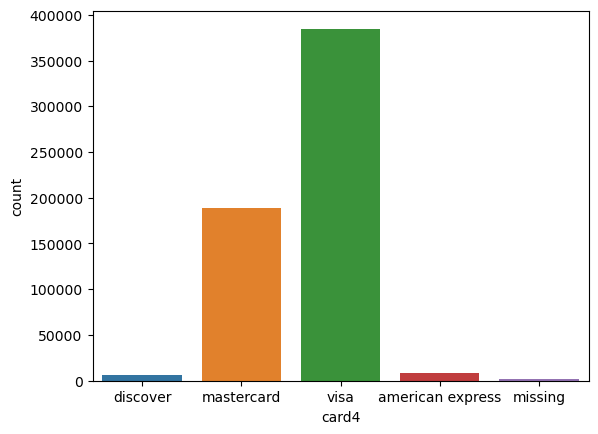

In [20]:
sns.countplot(train_transaction_data['card4'])

D:\Anaconda\Documents\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
D:\Anaconda\Documents\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
D:\Anaconda\Documents\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
D:\Anaconda\Documents\lib\site-packages\

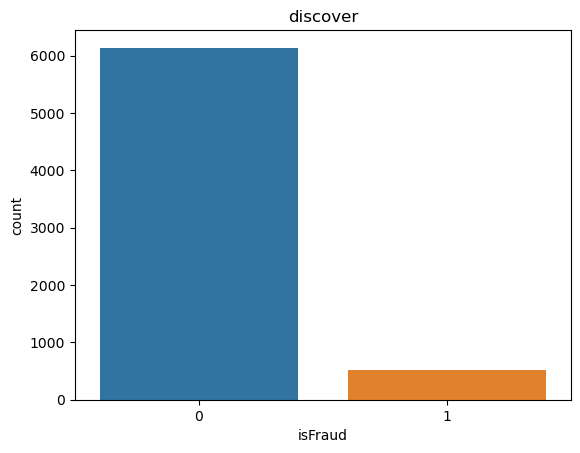

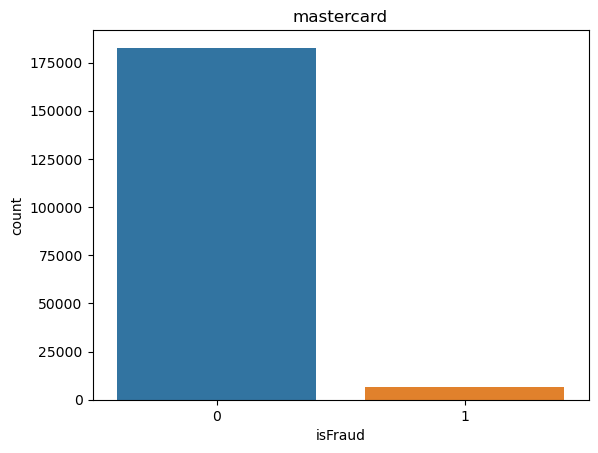

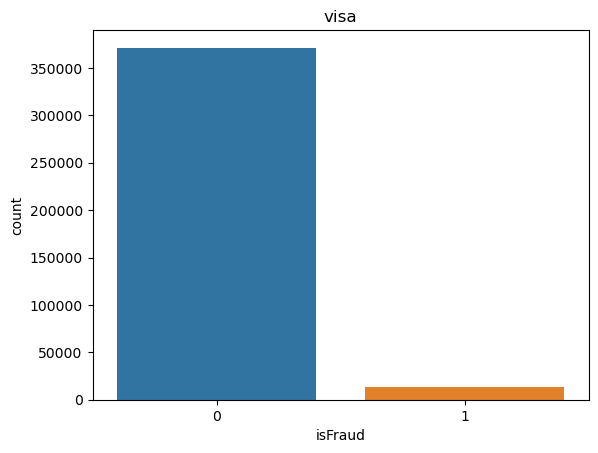

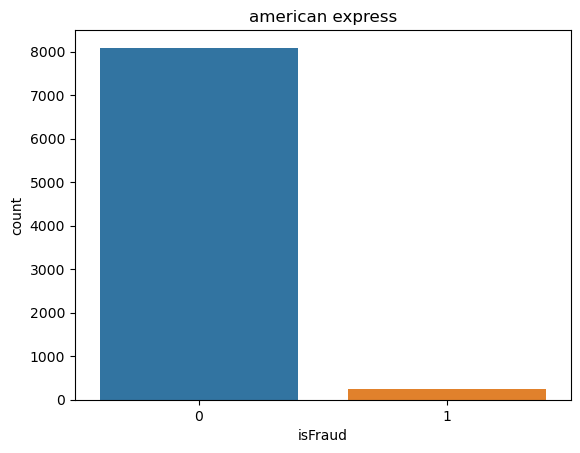

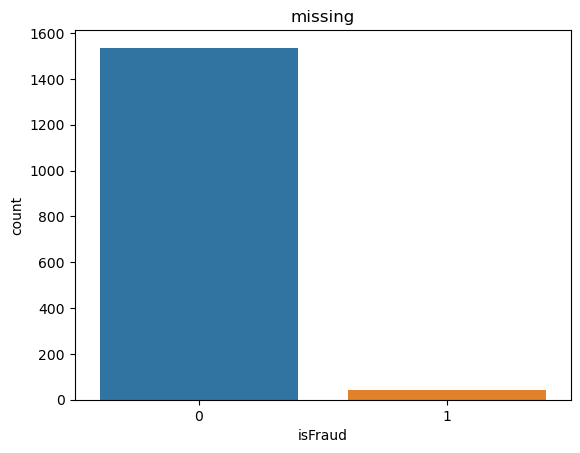

In [21]:
cardTypes = ['discover','mastercard','visa','american express','missing']
for i,i_card in enumerate(cardTypes):
    cardData = eval('train_transaction_data.loc[train_transaction_data["card4"]=="'+i_card+'"]')
    plt.figure(i)
    sns.countplot(cardData['isFraud']).set_title(i_card)

In [22]:
print('The average transaction amount for non fraudulent transactions is: ', 
      np.mean(train_transaction_data.loc[train_transaction_data["isFraud"]==0]['TransactionAmt']))
print('The average transaction amount for fraudulent transactions is: ', 
      np.mean(train_transaction_data.loc[train_transaction_data["isFraud"]==1]['TransactionAmt']))

The average transaction amount for non fraudulent transactions is:  134.51166457896034
The average transaction amount for fraudulent transactions is:  149.2447785897534


In [23]:
print('The Maximum transaction amount for non fraudulent transactions is: ', 
      np.max(train_transaction_data.loc[train_transaction_data["isFraud"]==0]['TransactionAmt']))
print('The Maximum transaction amount for fraudulent transactions is: ', 
      np.max(train_transaction_data.loc[train_transaction_data["isFraud"]==1]['TransactionAmt']))

The Maximum transaction amount for non fraudulent transactions is:  31937.391
The Maximum transaction amount for fraudulent transactions is:  5191.0


In [24]:
print('The Minimum transaction amount for non fraudulent transactions is: ', 
      np.min(train_transaction_data.loc[train_transaction_data["isFraud"]==0]['TransactionAmt']))
print('The Minimum transaction amount for fraudulent transactions is: ', 
      np.min(train_transaction_data.loc[train_transaction_data["isFraud"]==1]['TransactionAmt']))

The Minimum transaction amount for non fraudulent transactions is:  0.251
The Minimum transaction amount for fraudulent transactions is:  0.292


In [25]:
maxCardData = {}
minCardData = {}
meanCardData = {}
for i,i_card in enumerate(cardTypes):
    cardData = eval('train_transaction_data.loc[train_transaction_data["card4"]=="'+i_card+'"]')
    maxCardData[i_card] = np.max(cardData['TransactionAmt'])
    minCardData[i_card] = np.min(cardData['TransactionAmt'])
    meanCardData[i_card] = np.mean(cardData['TransactionAmt'])

In [26]:
print('The maximum transactions by card are:', maxCardData)
print('The minimum transactions by card are:', minCardData)
print('The average transactions by card are:', meanCardData)

The maximum transactions by card are: {'discover': 4817.58, 'mastercard': 31937.391, 'visa': 6450.97, 'american express': 1800.0, 'missing': 4545.36}
The minimum transactions by card are: {'discover': 5.0, 'mastercard': 0.272, 'visa': 0.251, 'american express': 5.0, 'missing': 2.6}
The average transactions by card are: {'discover': 265.75042549991866, 'mastercard': 132.38773137177253, 'visa': 133.16180560725275, 'american express': 173.05713664745434, 'missing': 154.68928091312833}


In [27]:
normalDataTransaction = train_transaction_data.loc[train_transaction_data["isFraud"]==0]
normalDataTransaction.TransactionAmt.describe()

count    569877.000000
mean        134.511665
std         239.395078
min           0.251000
25%          43.970000
50%          68.500000
75%         120.000000
max       31937.391000
Name: TransactionAmt, dtype: float64

In [28]:
fraudDataTransaction = train_transaction_data.loc[train_transaction_data["isFraud"]==1]
fraudDataTransaction.TransactionAmt.describe()

count    20663.000000
mean       149.244779
std        232.212163
min          0.292000
25%         35.044000
50%         75.000000
75%        161.000000
max       5191.000000
Name: TransactionAmt, dtype: float64

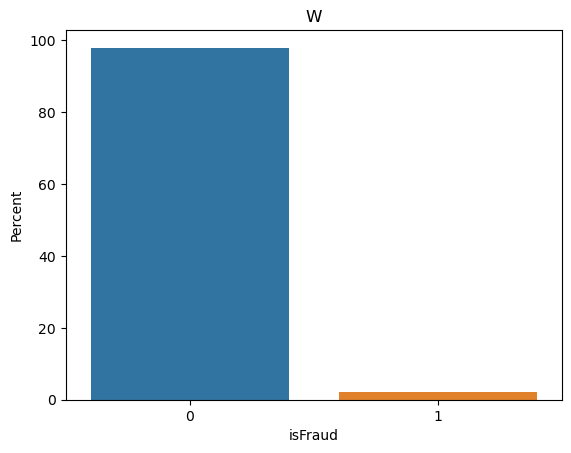

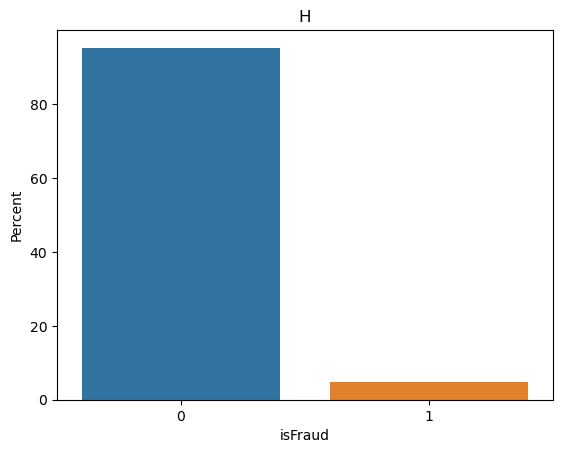

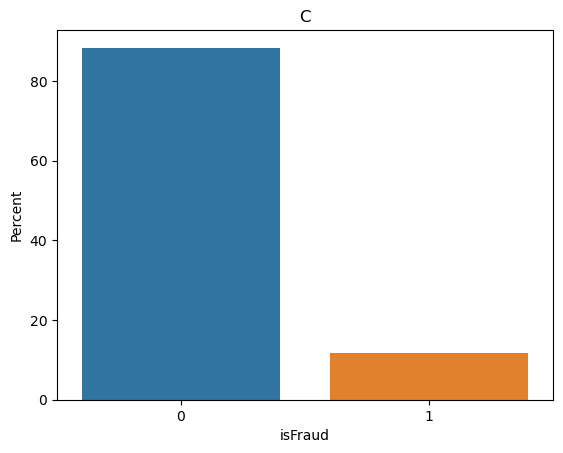

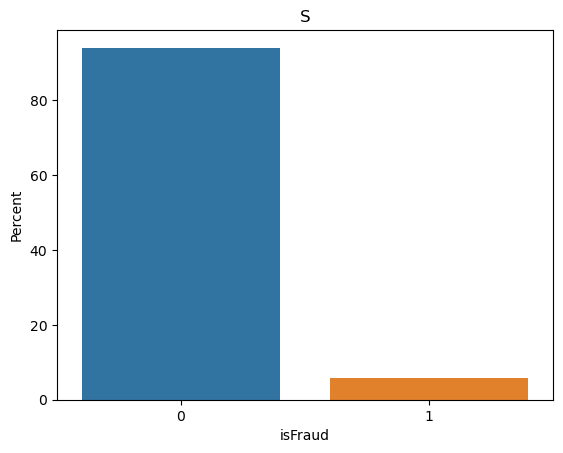

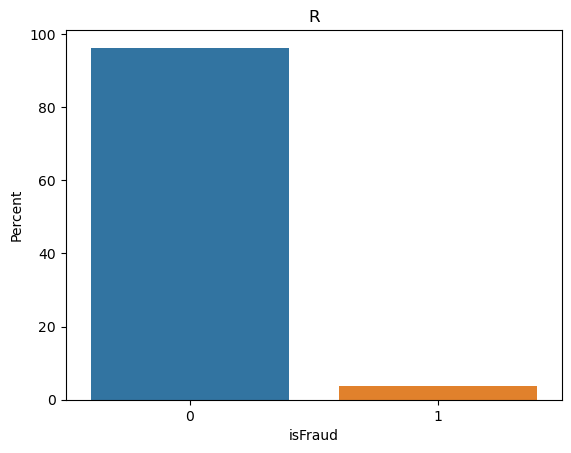

In [29]:
prodTypes = train_transaction_data['ProductCD'].unique()
for i,i_prod in enumerate(prodTypes):
    productData = eval('train_transaction_data.loc[train_transaction_data["ProductCD"]=="'+i_prod+'"]')
    plt.figure(i)
    ax = sns.barplot(x="isFraud", y="isFraud", data=productData, estimator=lambda x: len(x) / len(productData) * 100)
    ax.set(ylabel="Percent")
    ax.set_title(i_prod)

D:\Anaconda\Documents\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Anaconda\Documents\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Anaconda\Documents\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level functi

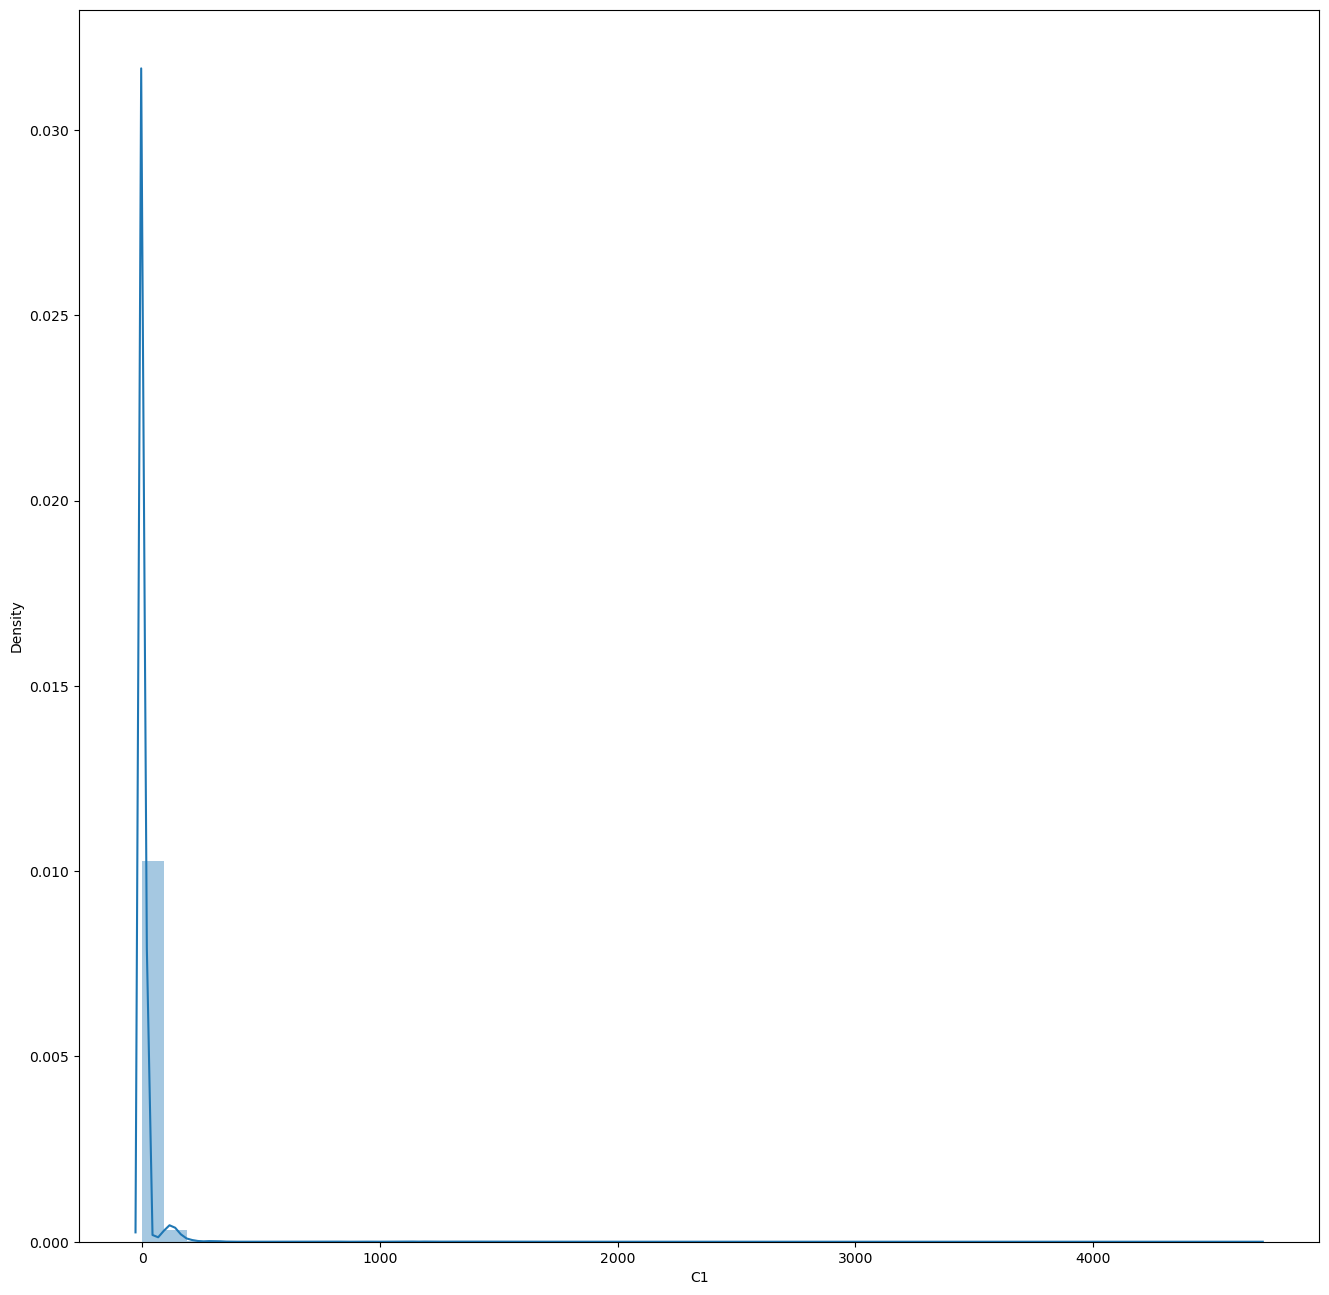

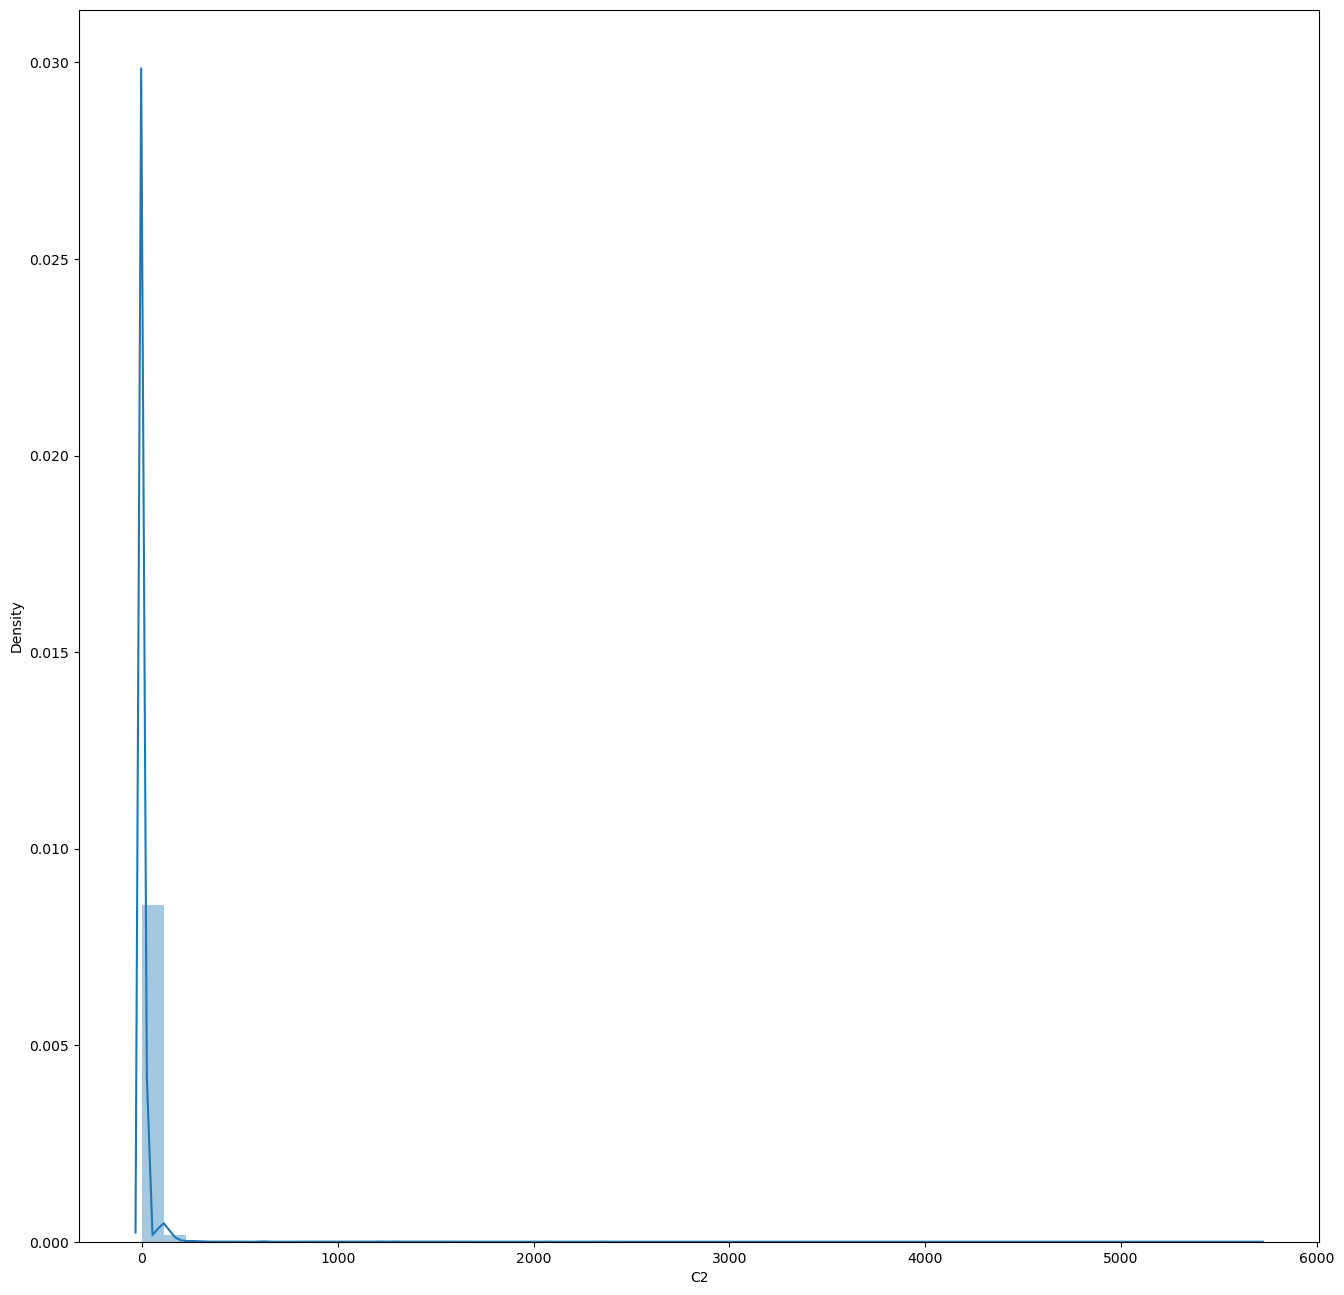

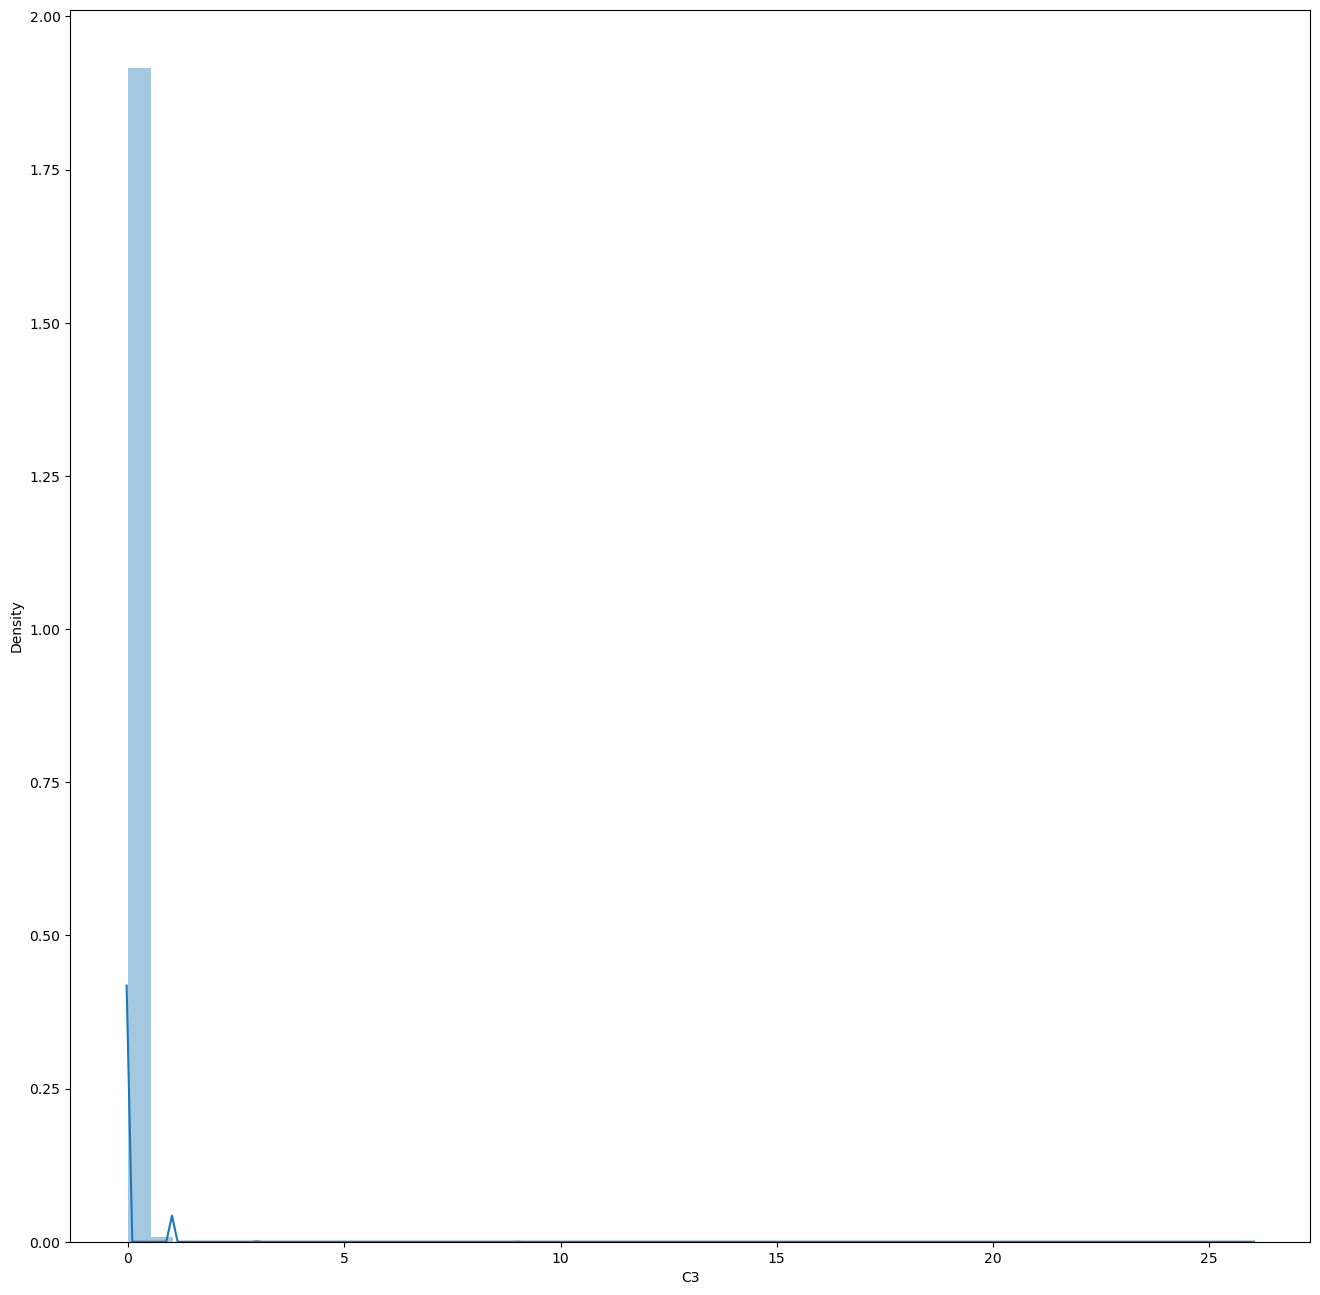

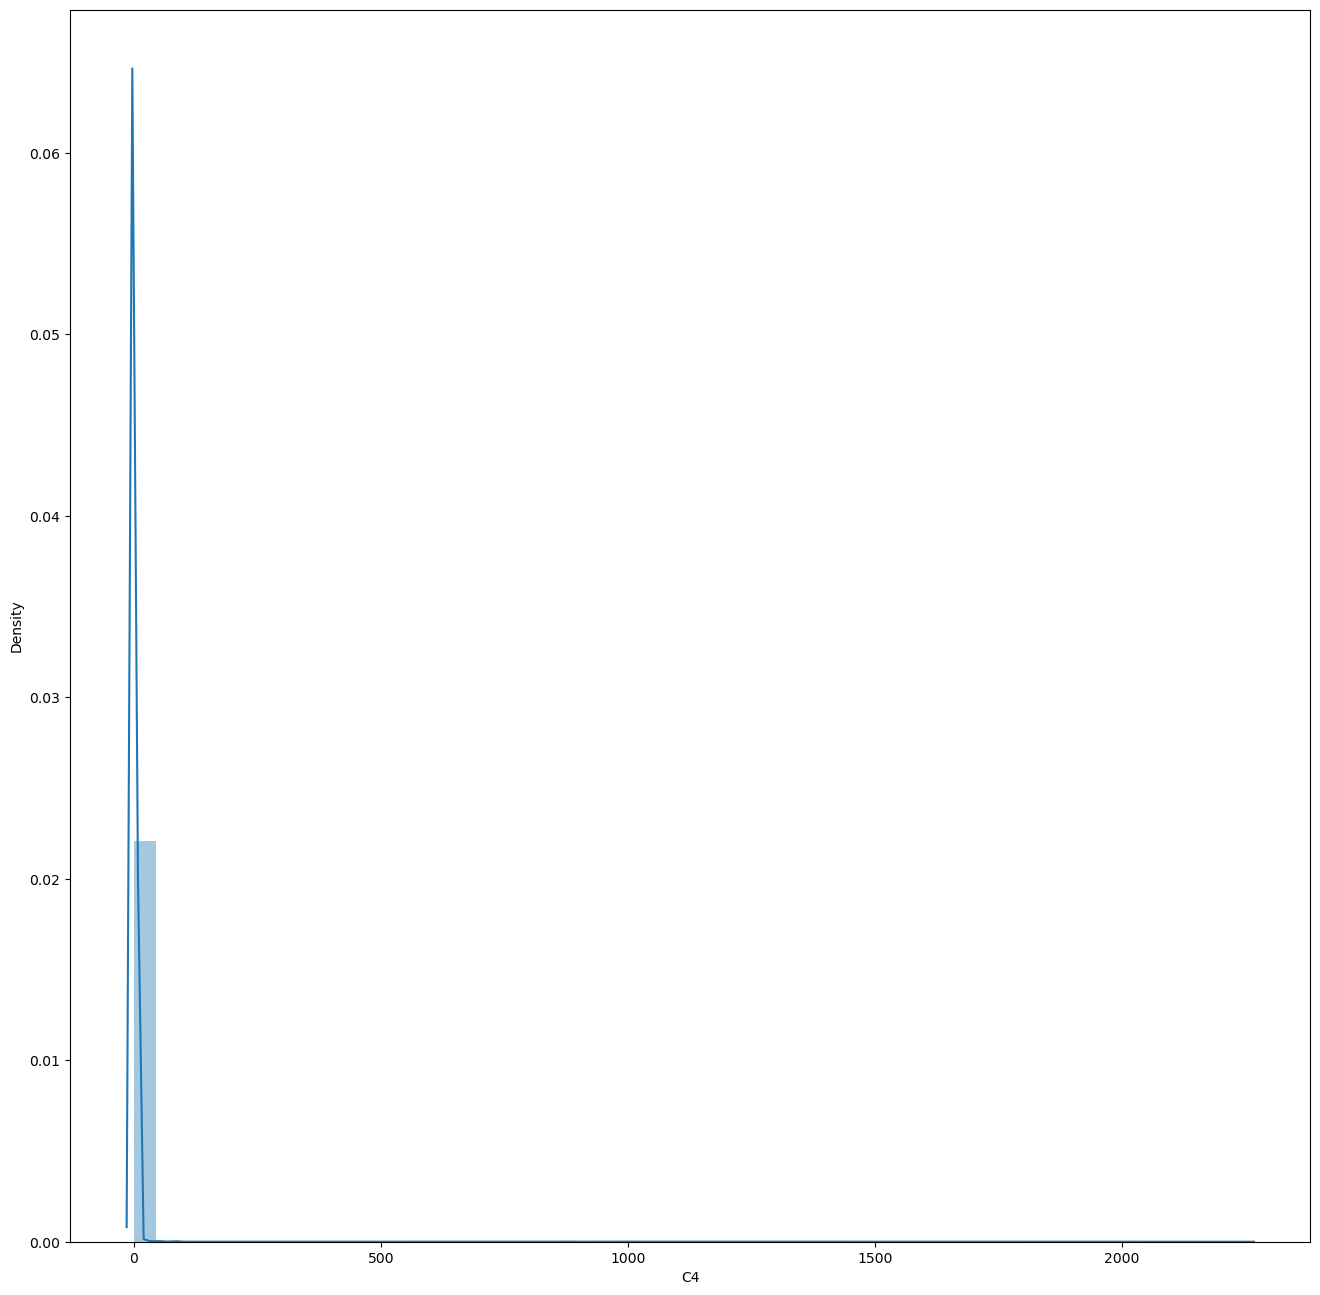

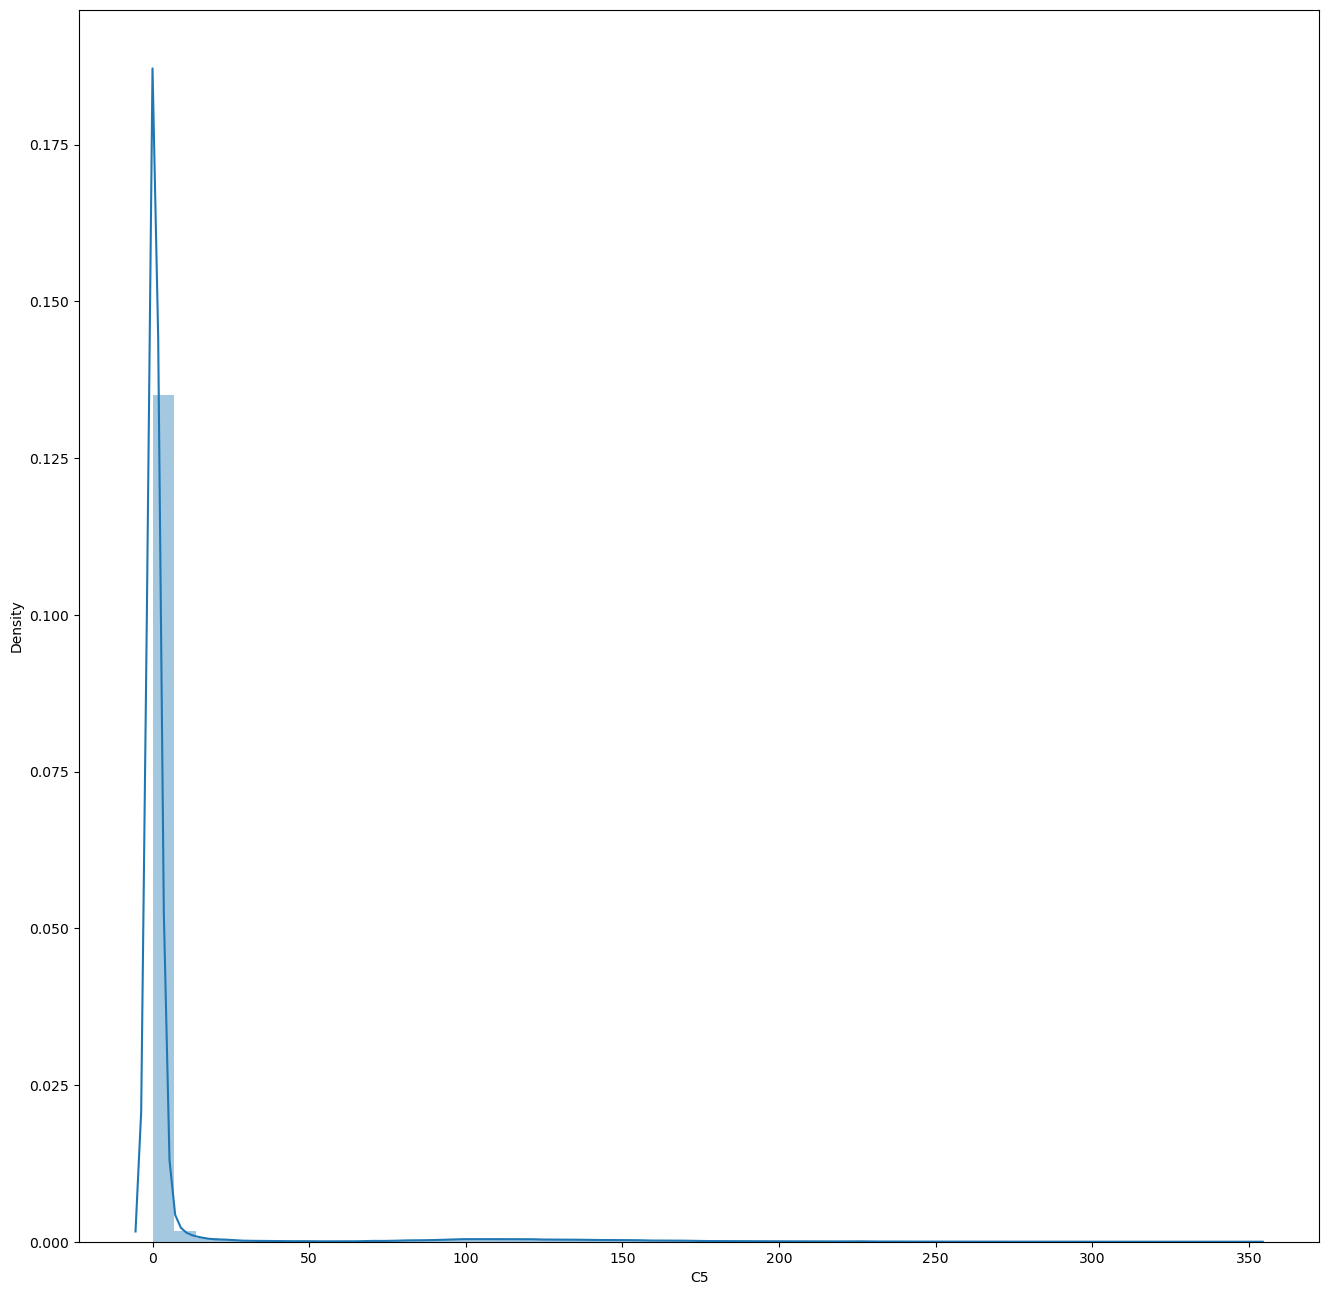

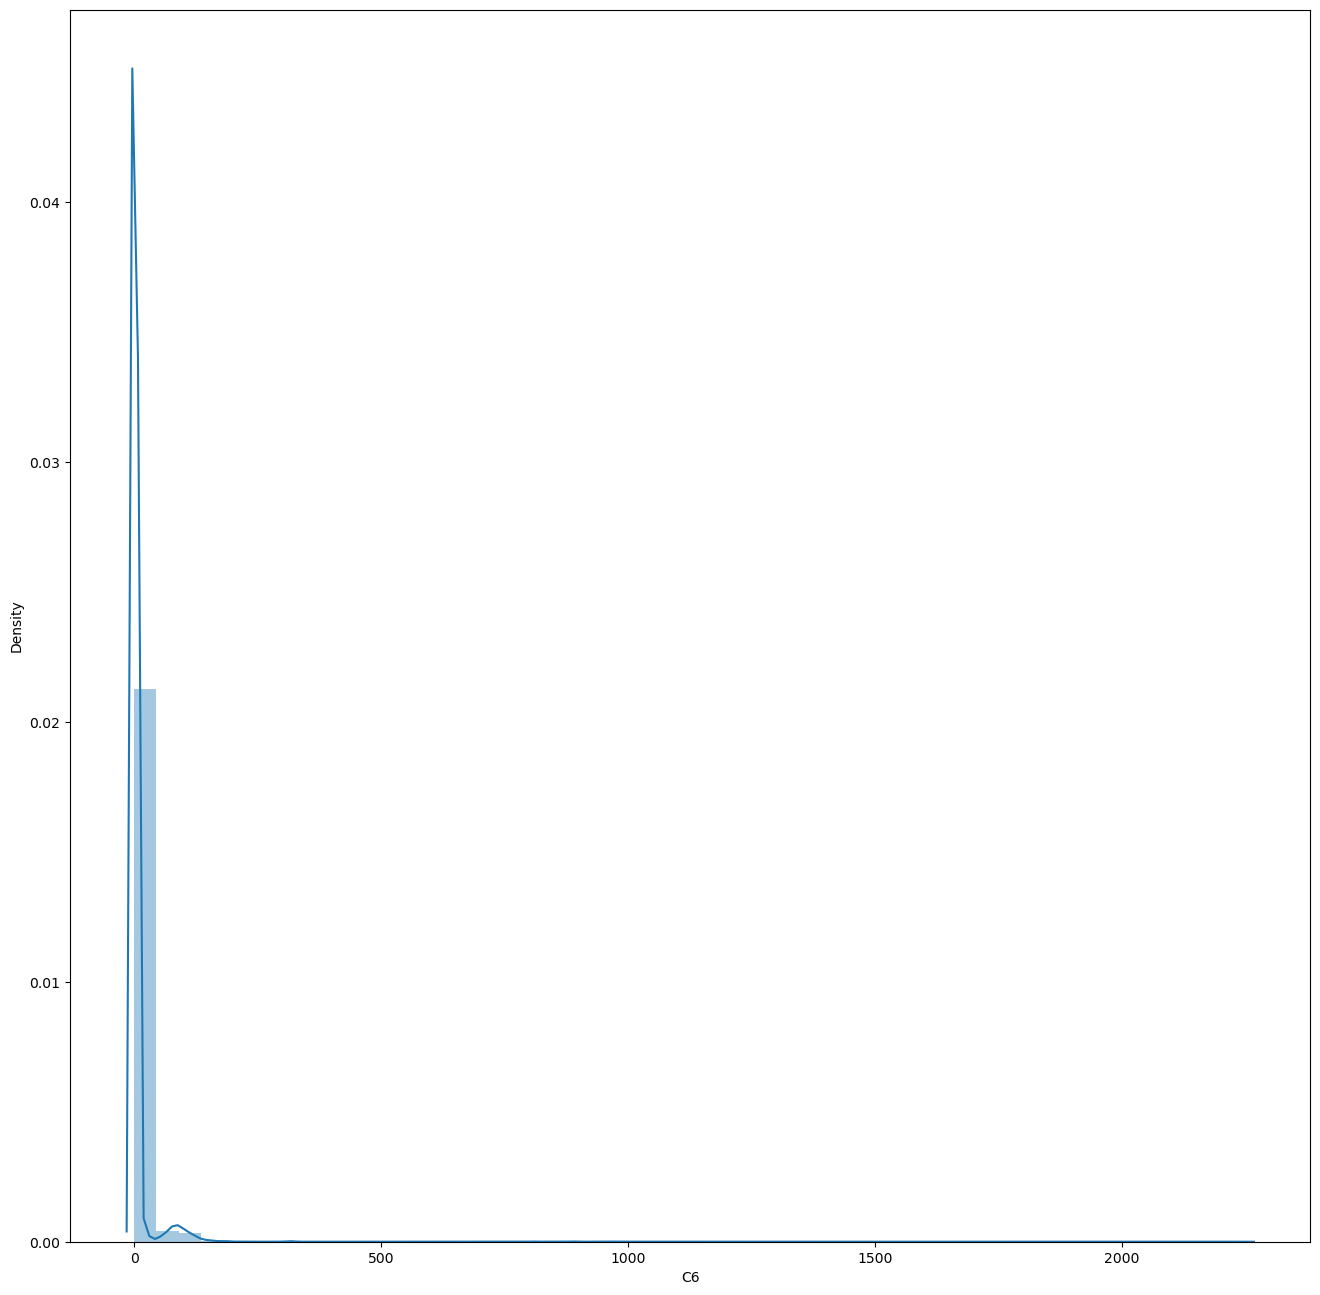

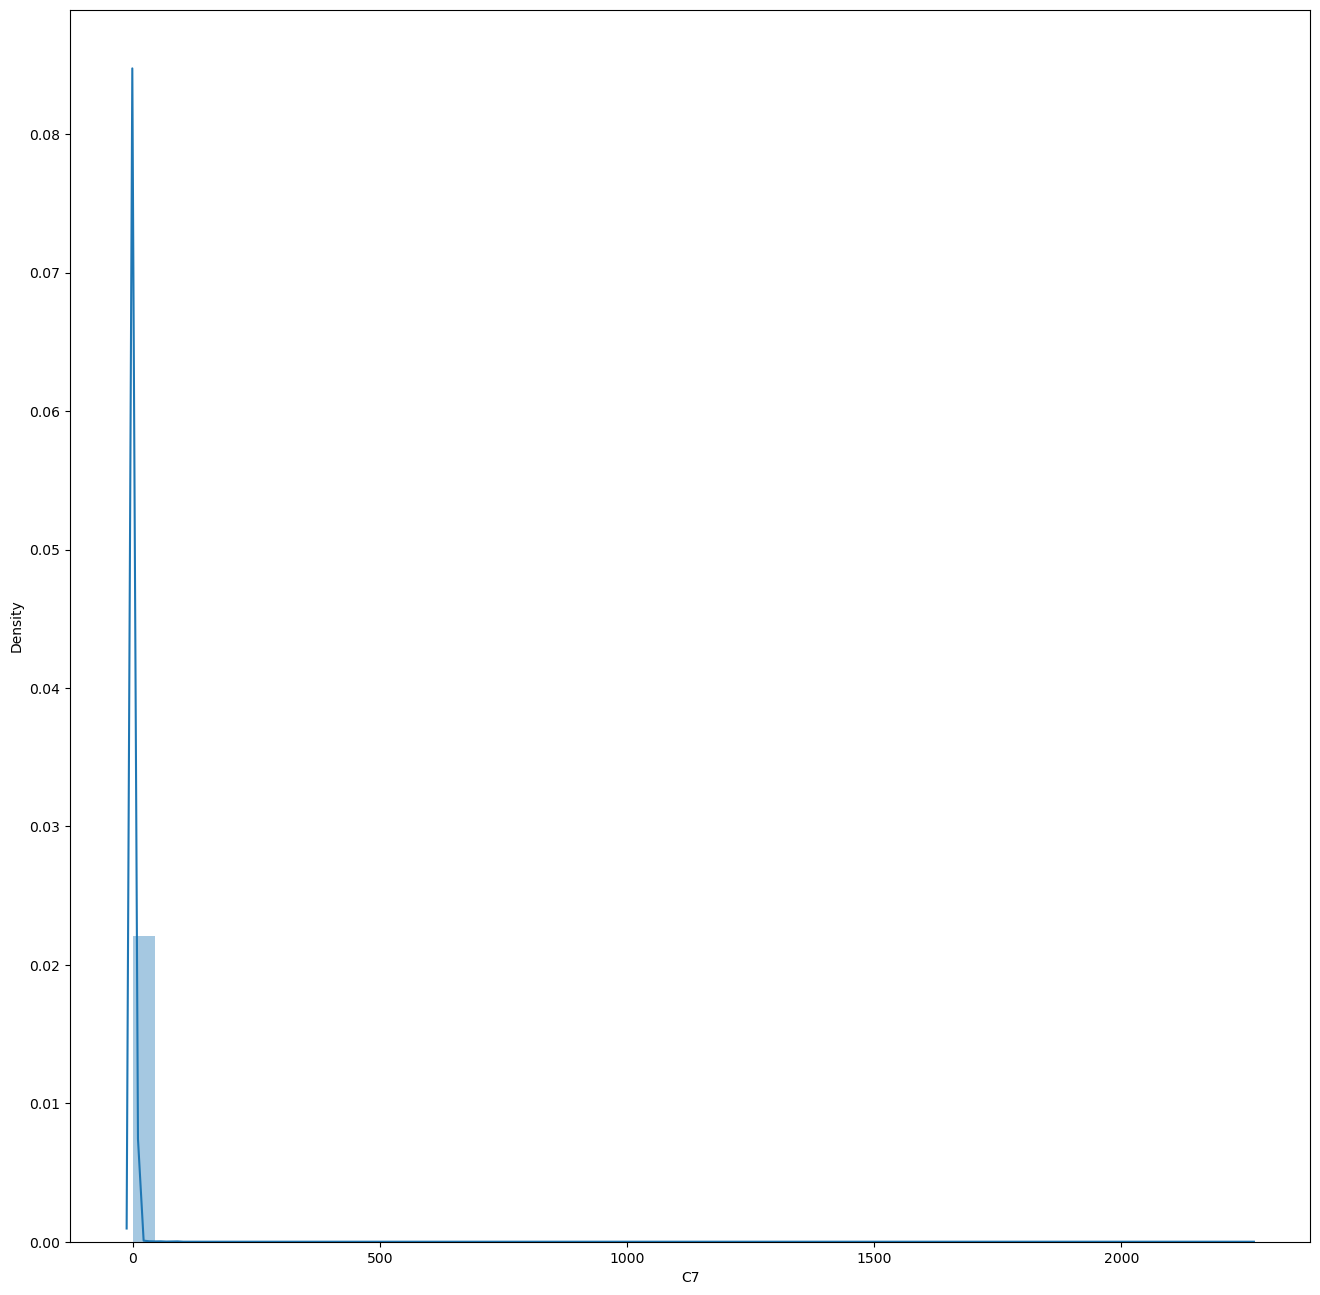

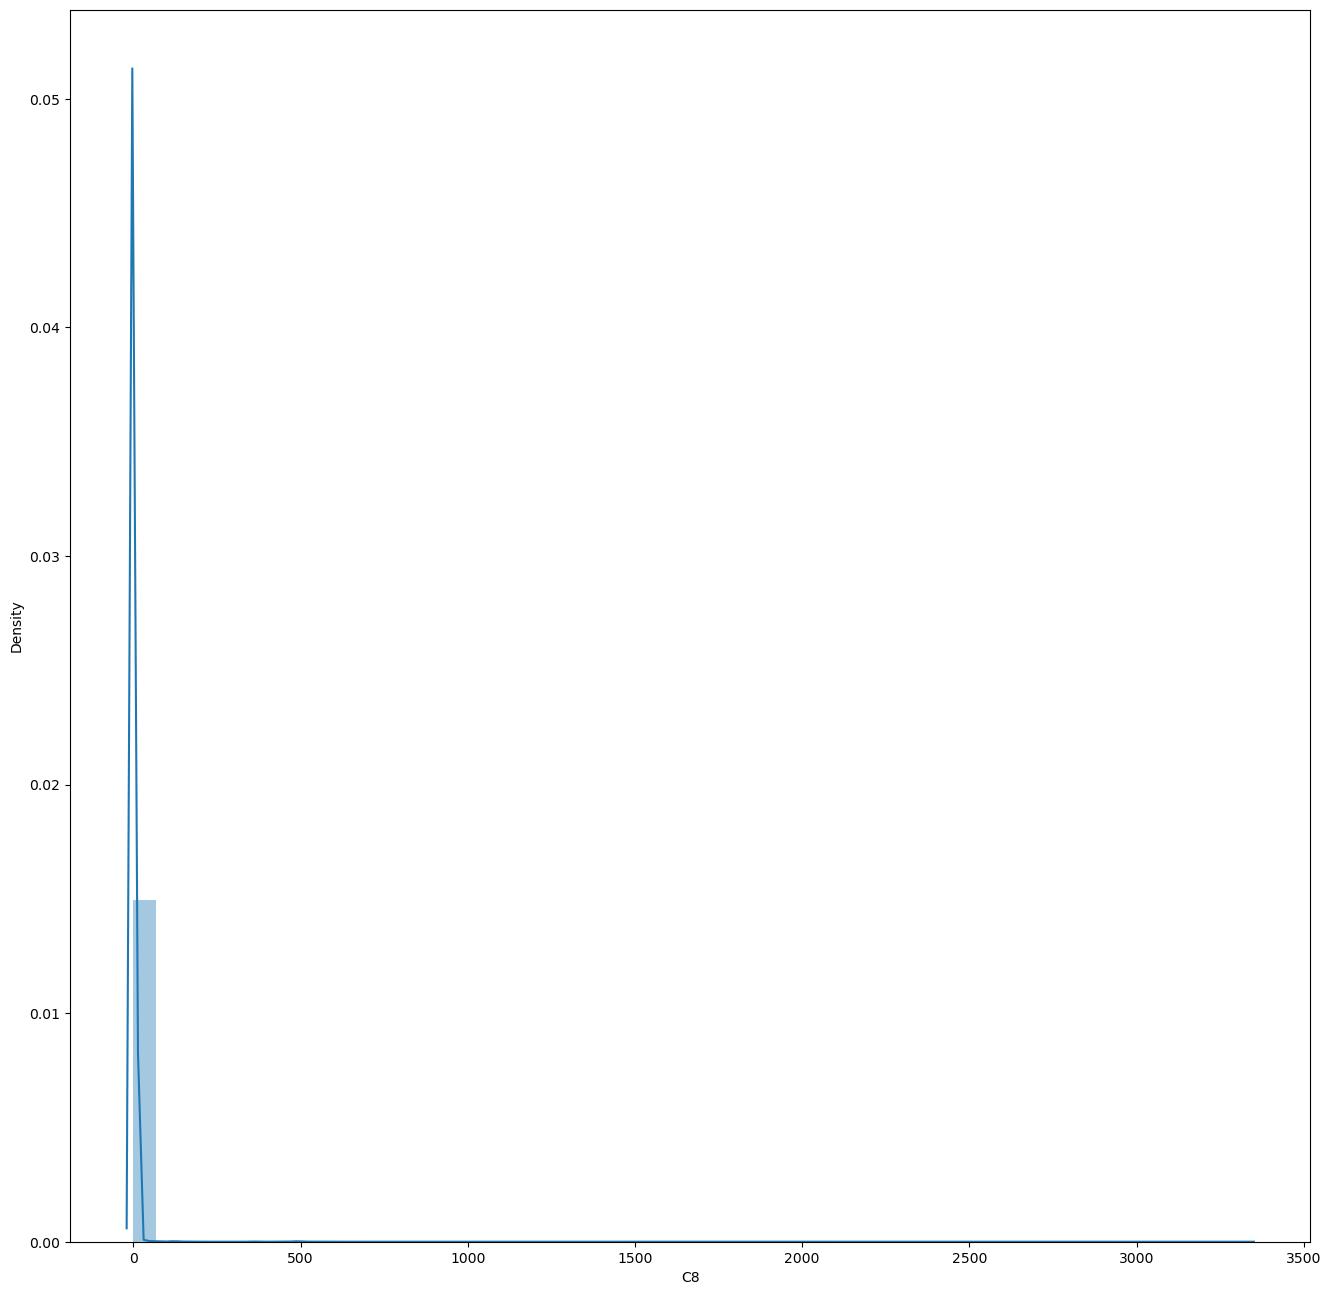

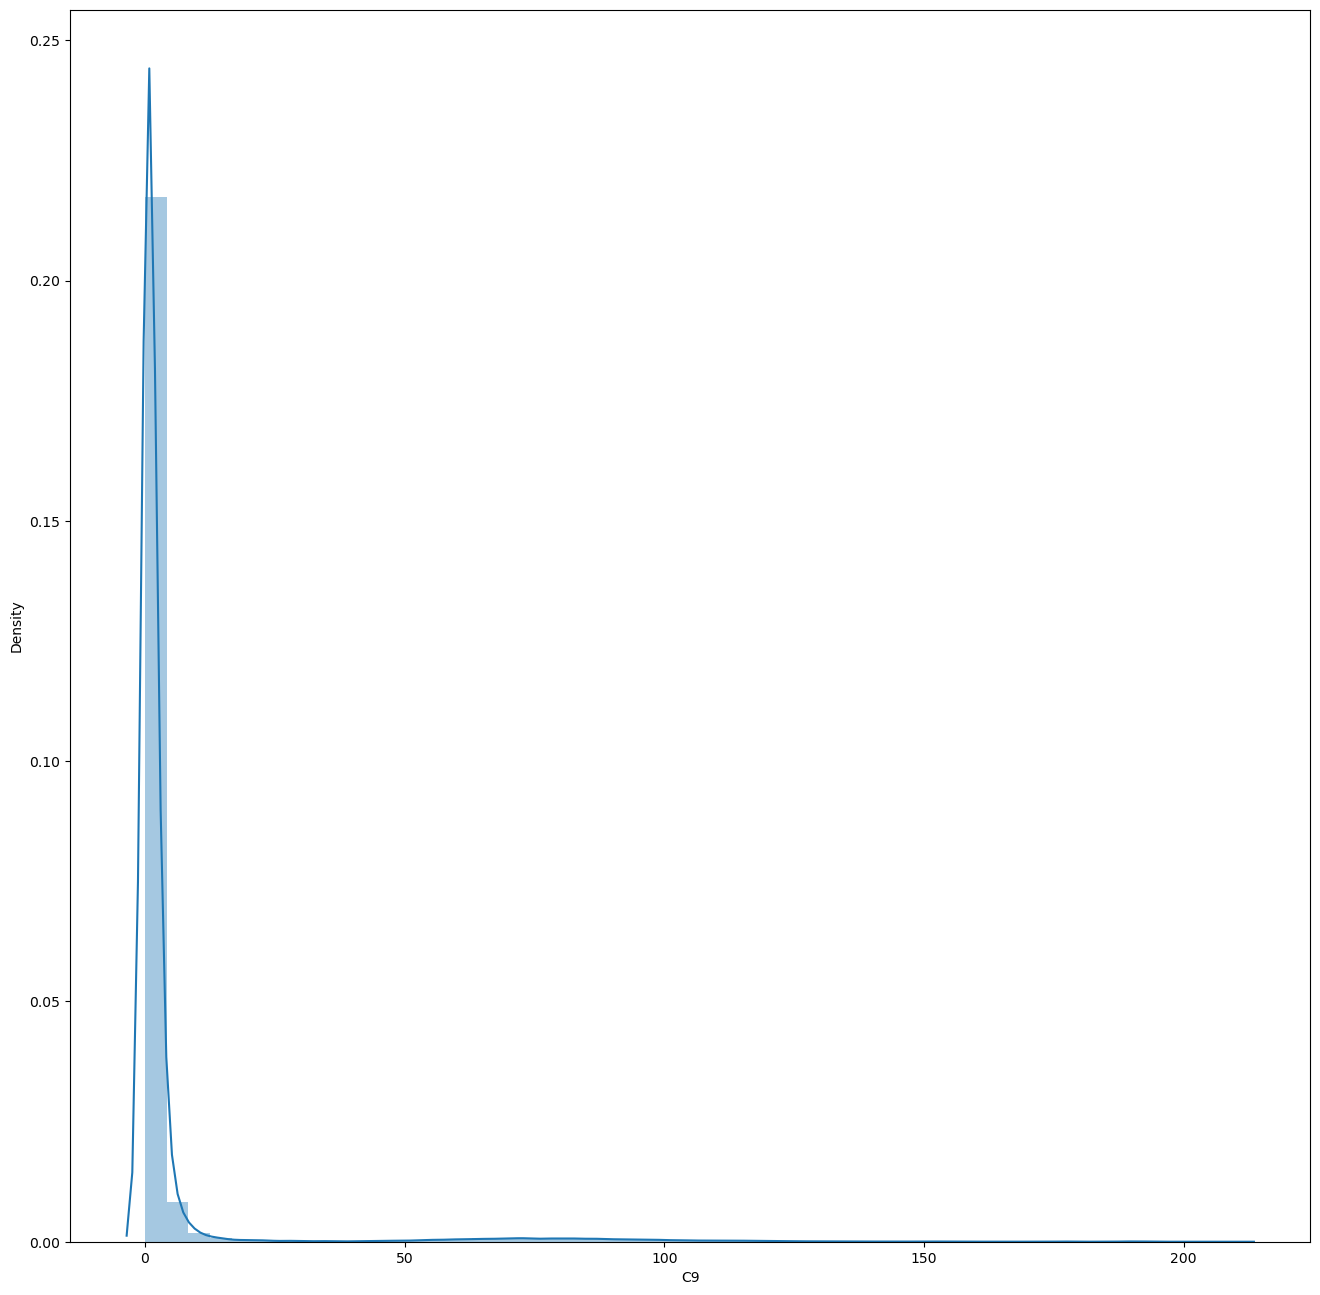

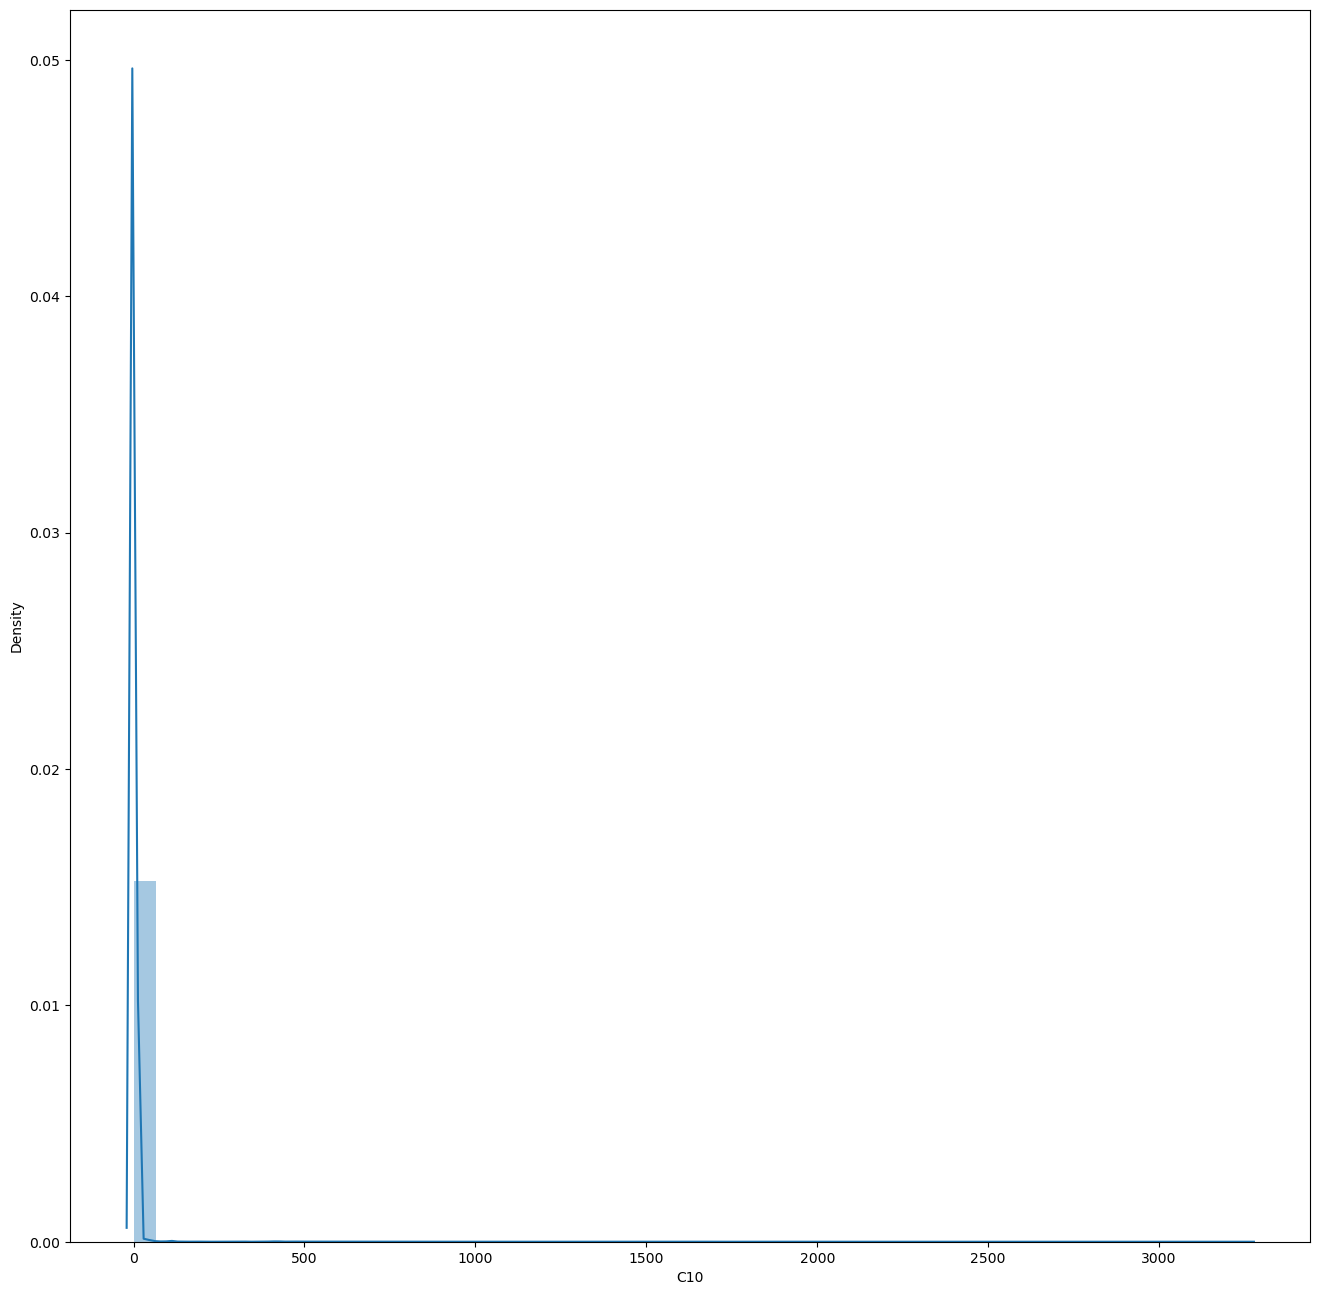

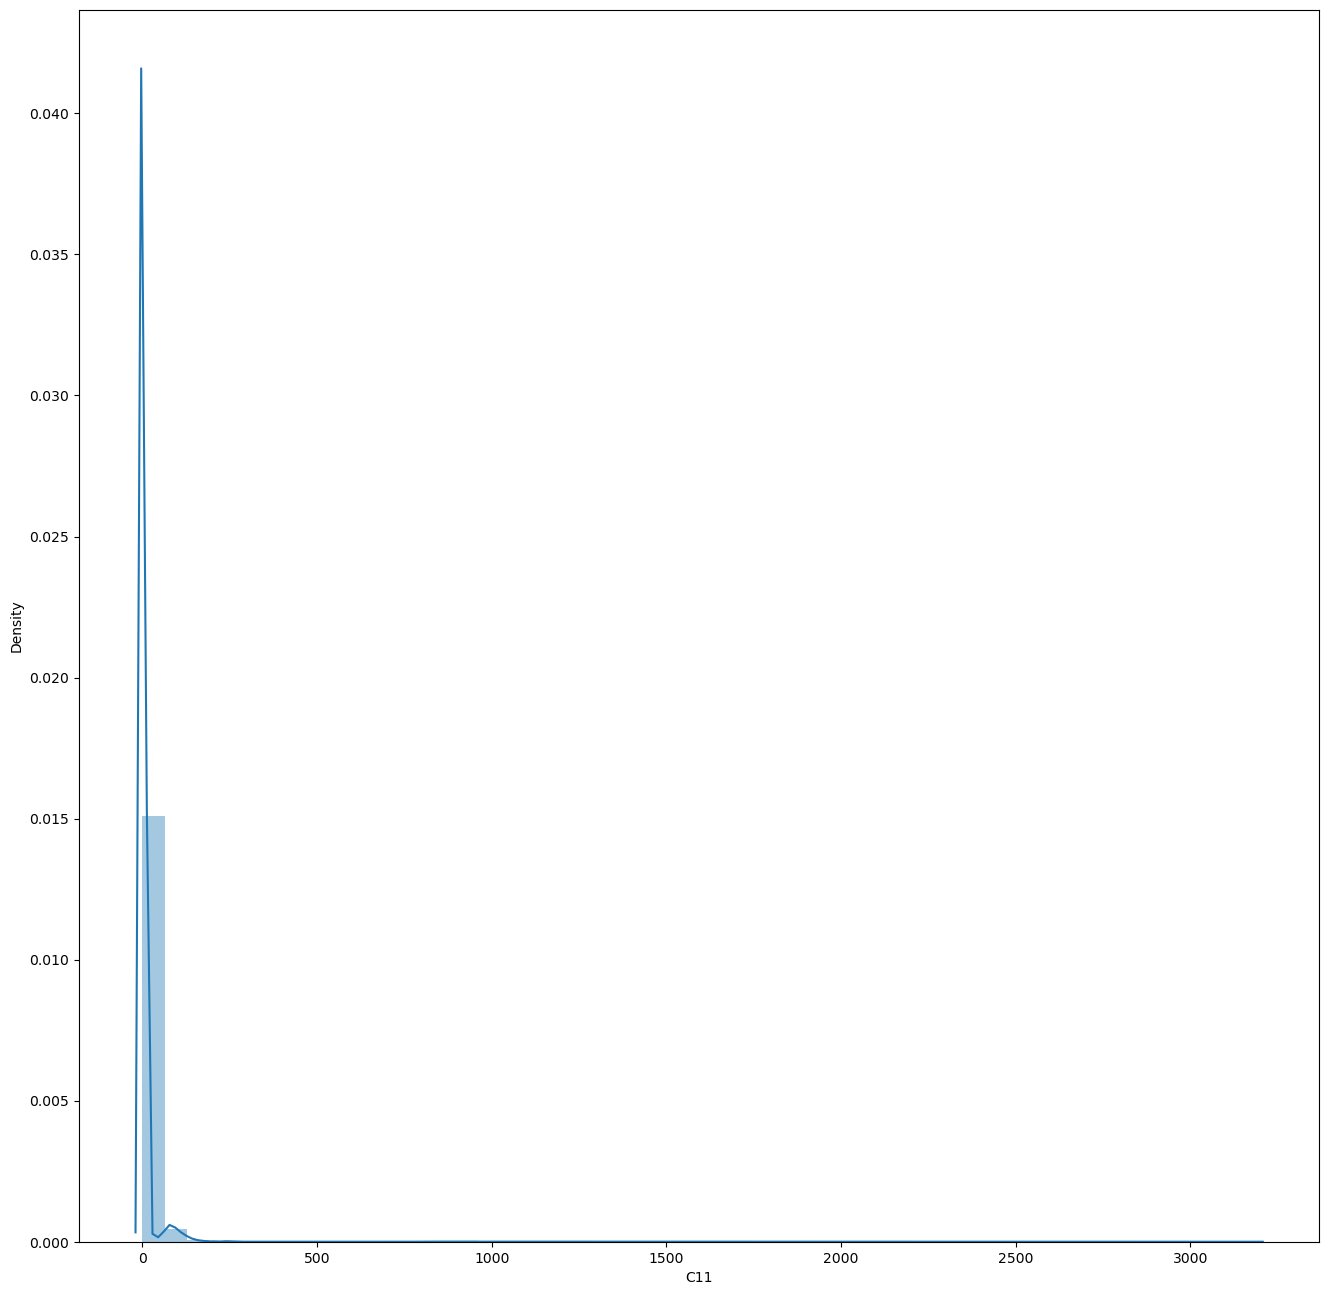

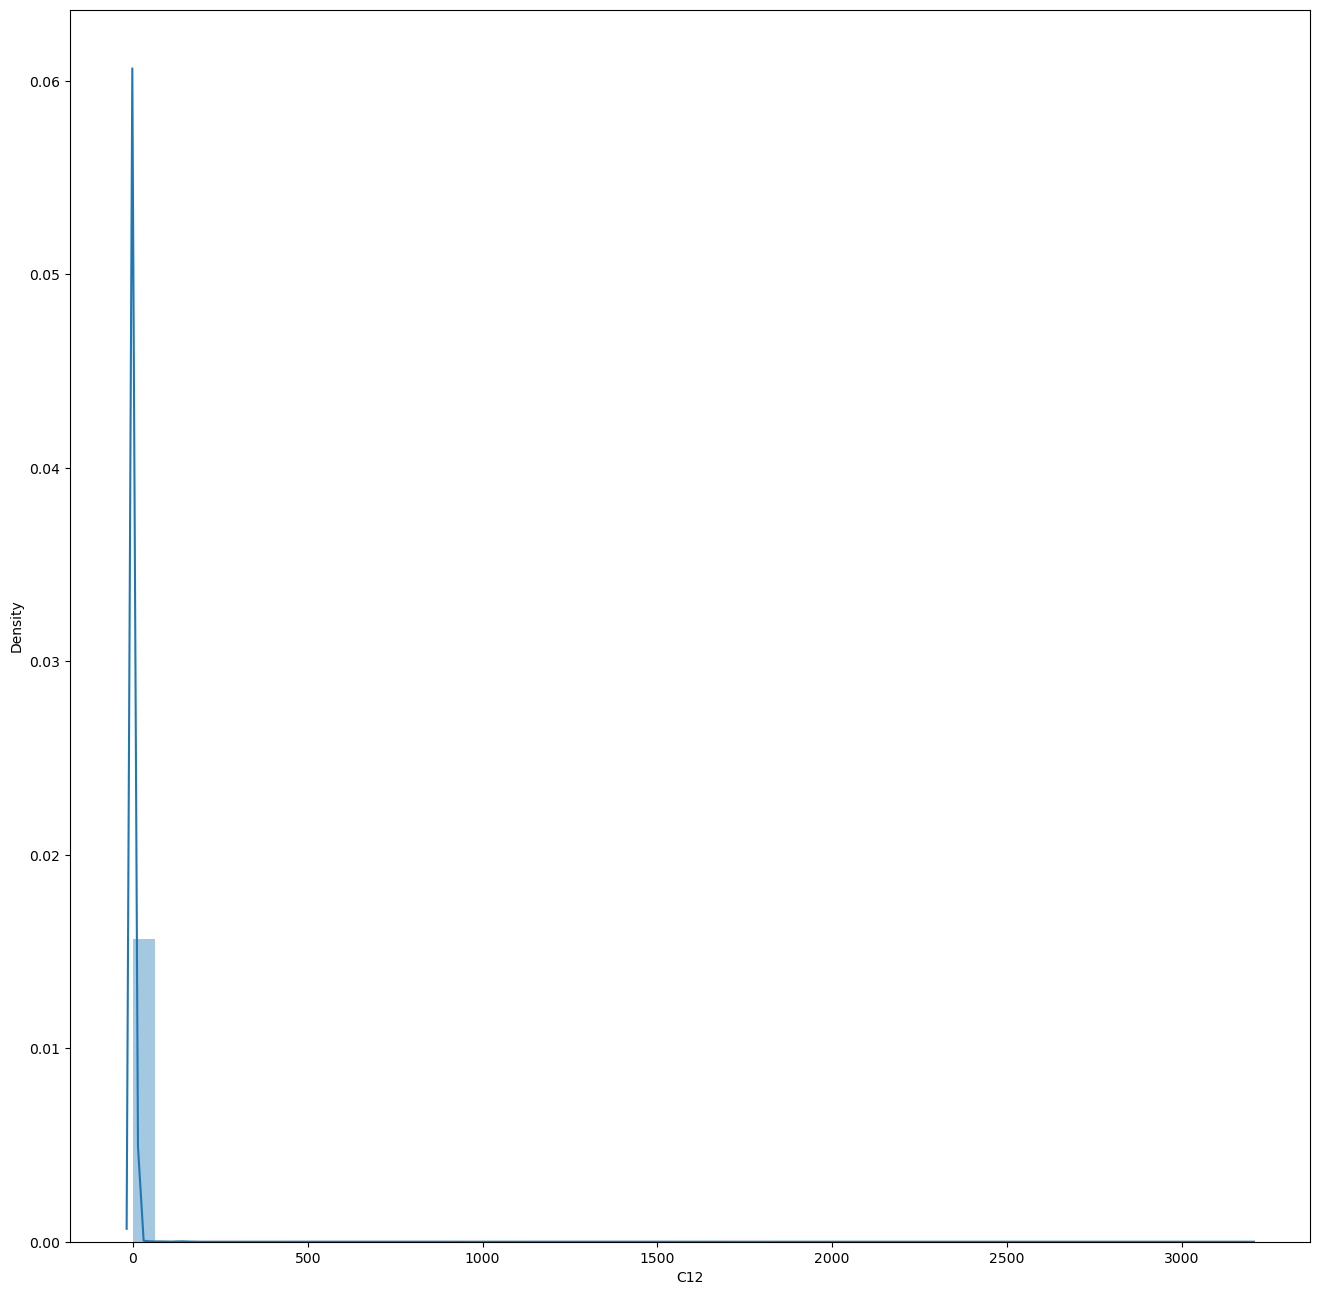

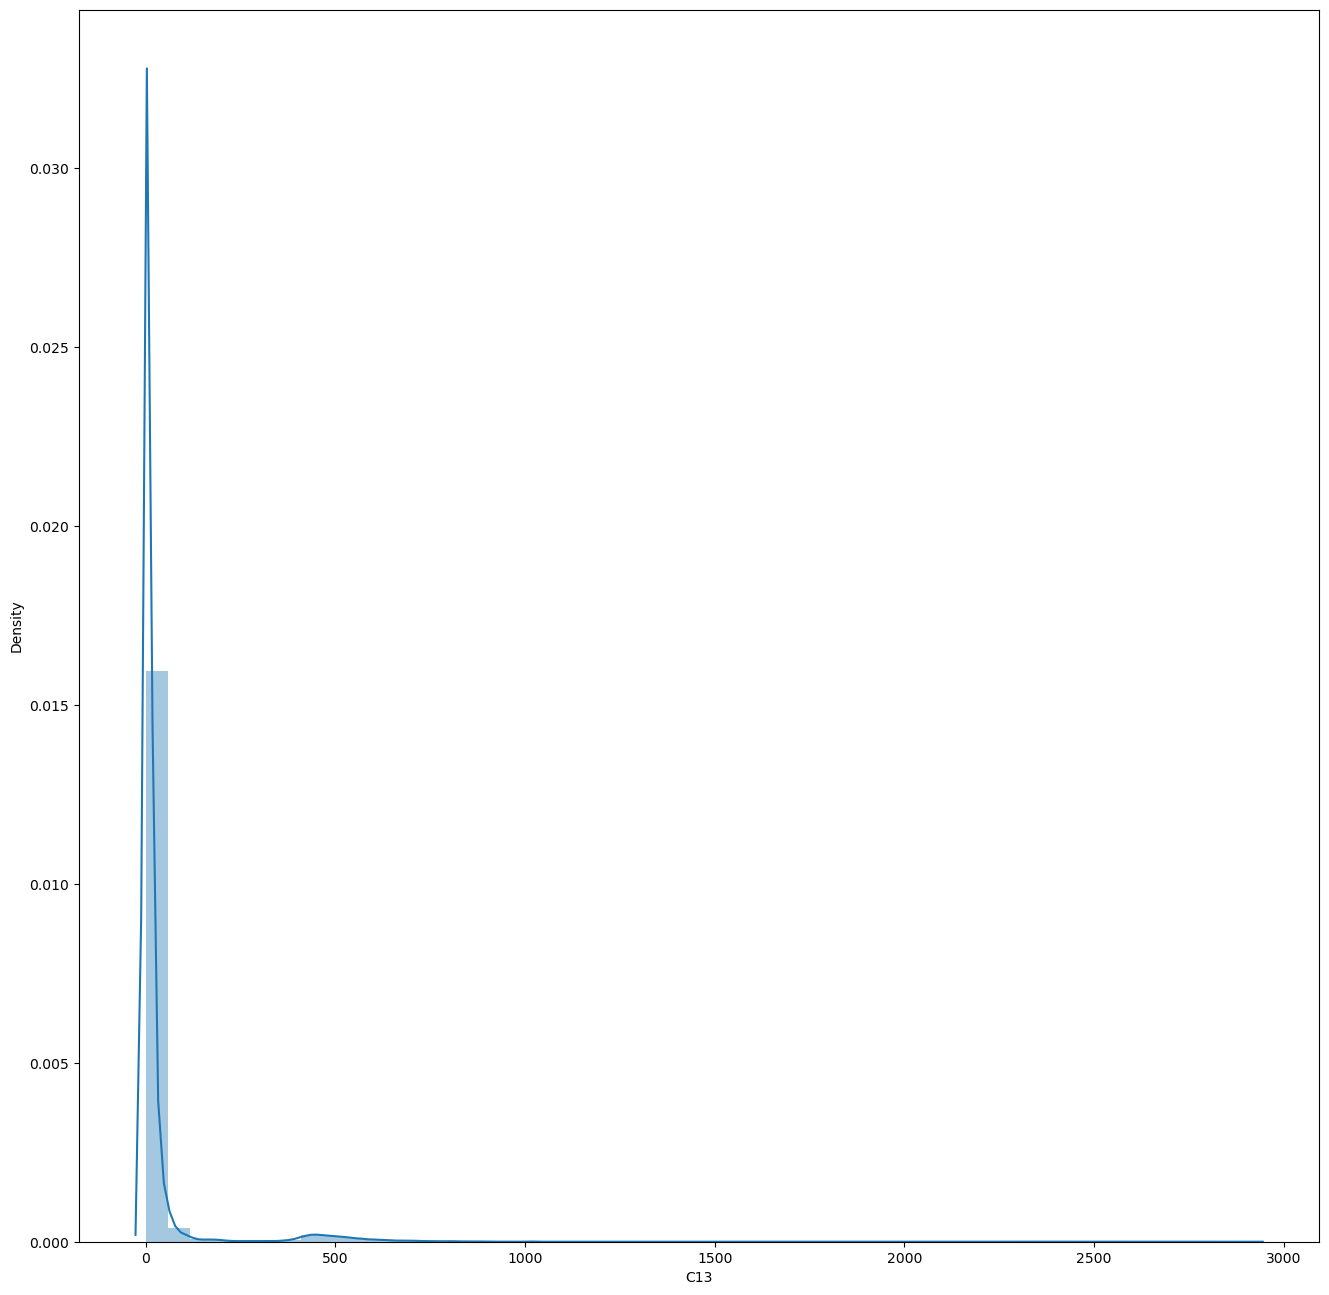

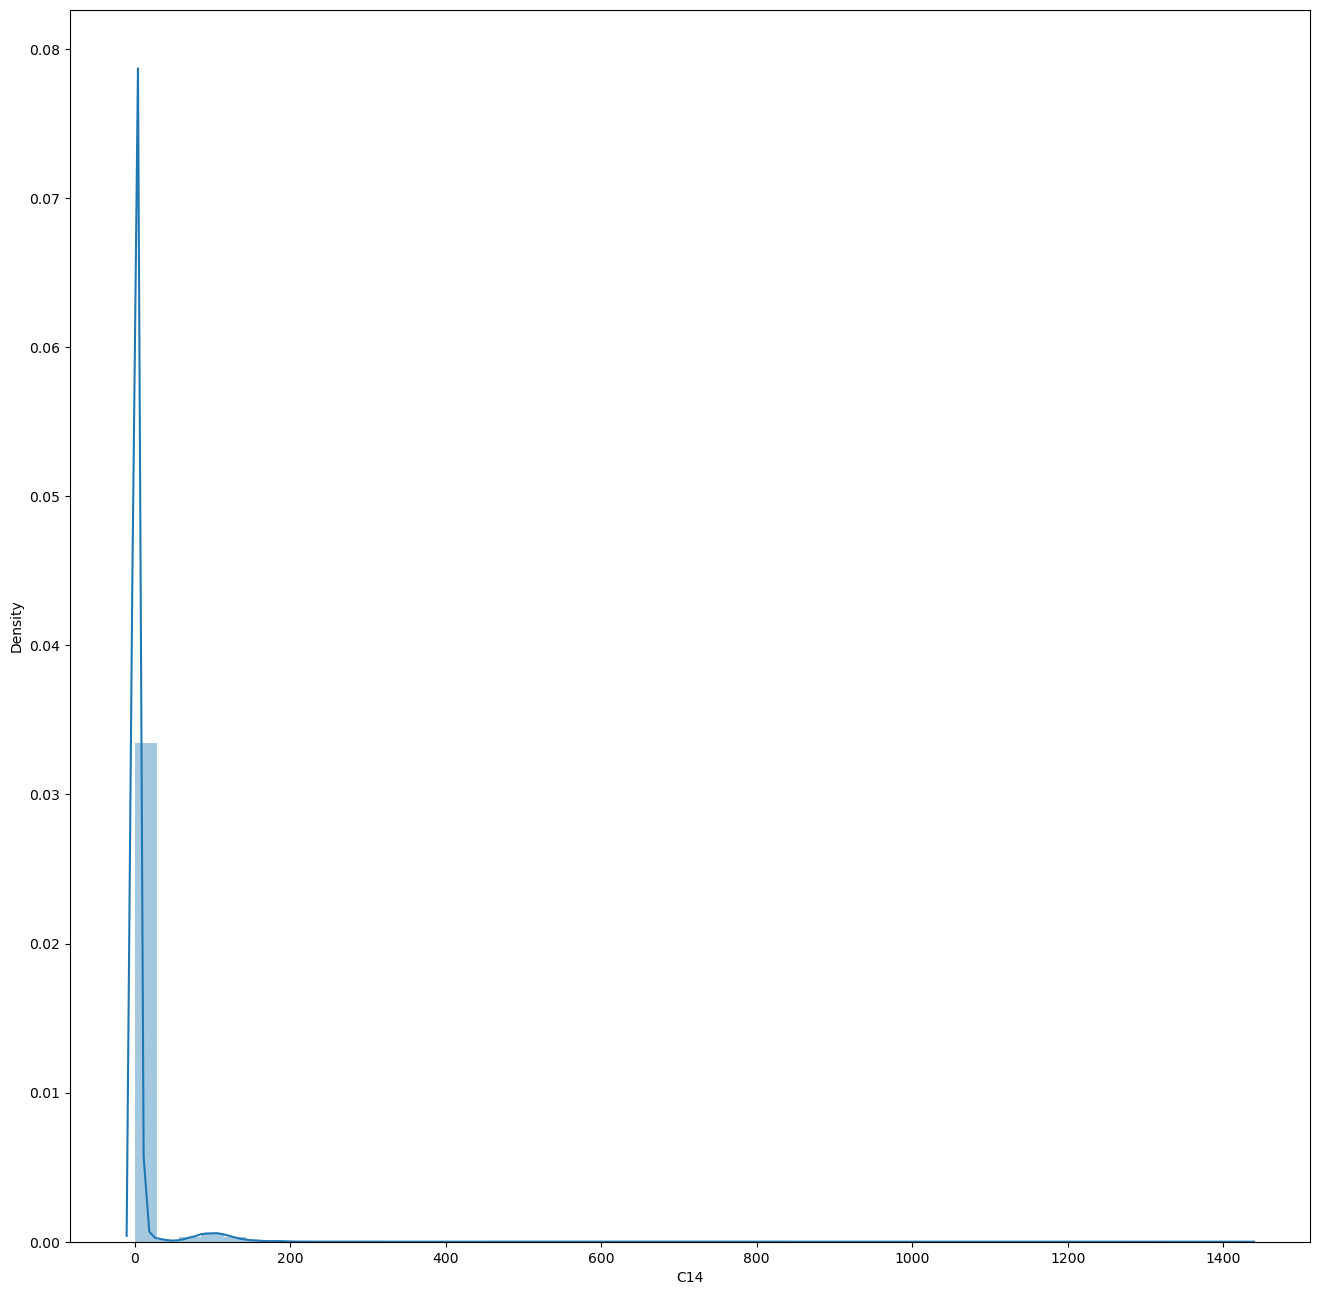

In [30]:
for i in range(1,15):    
    plt.figure(figsize=(16, 16))
    sns.distplot(eval('train_transaction_data["C'+str(i)+'"]'))
    ax.set(ylabel="Distribution")
    ax.set_title(['C'+str(i)])   

D:\Anaconda\Documents\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Anaconda\Documents\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Anaconda\Documents\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level functi

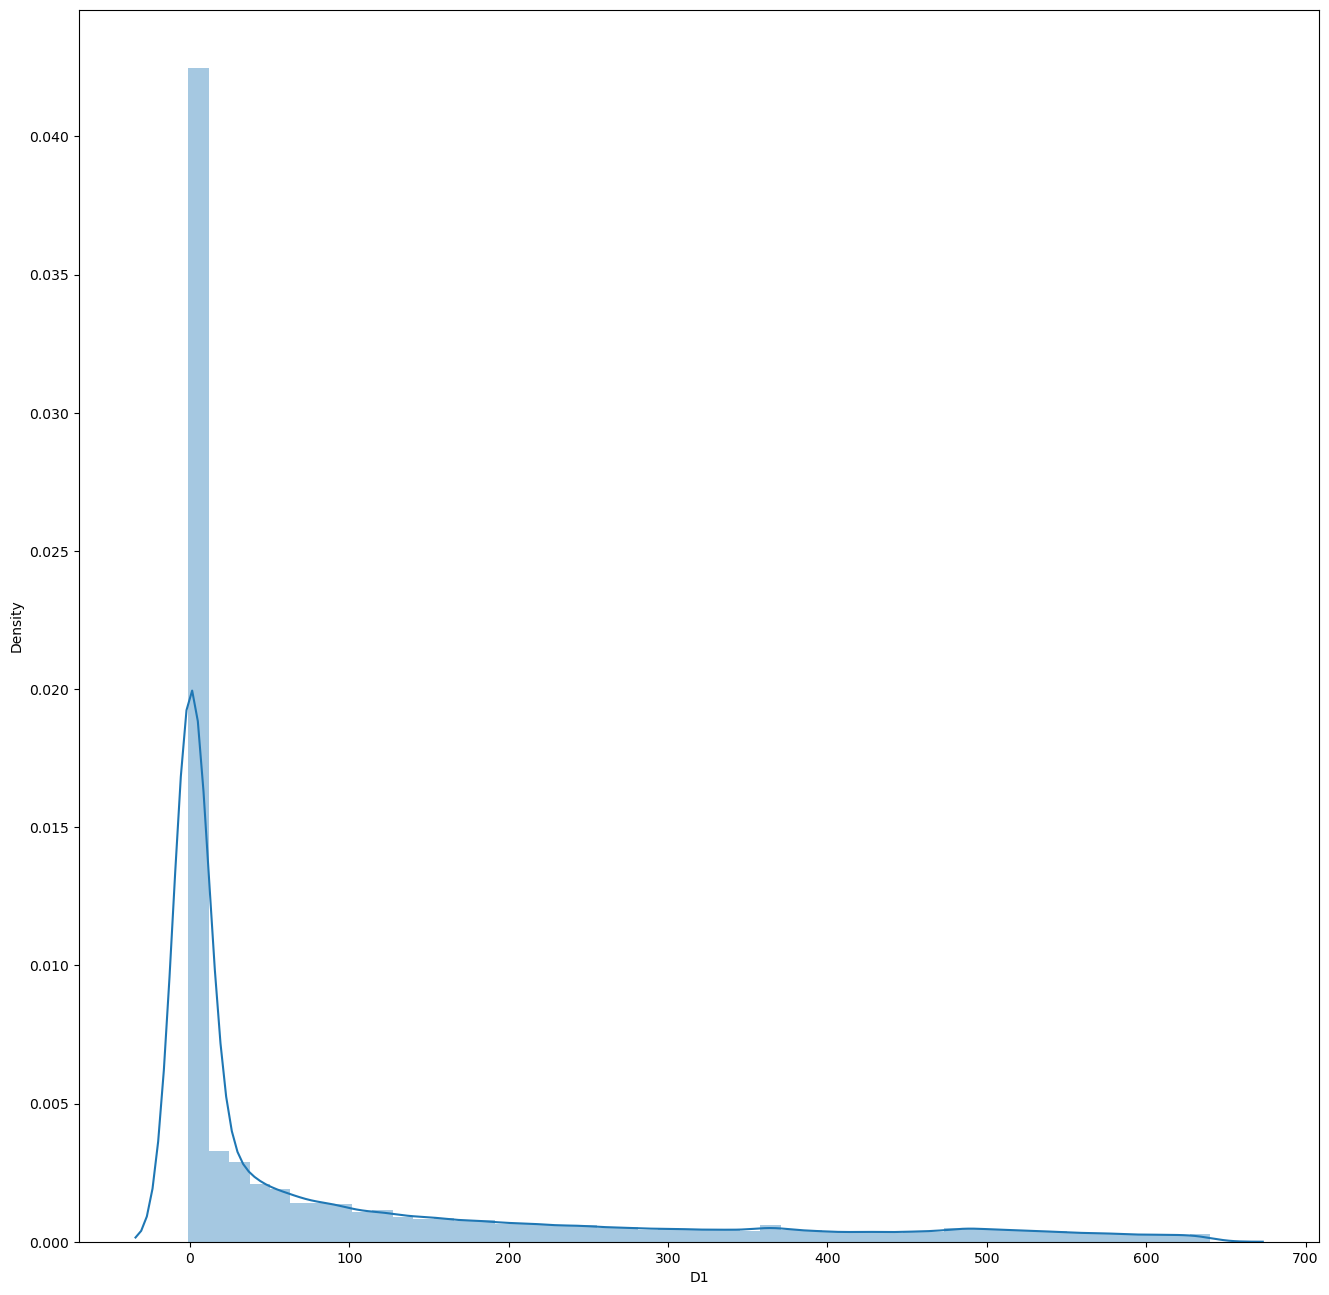

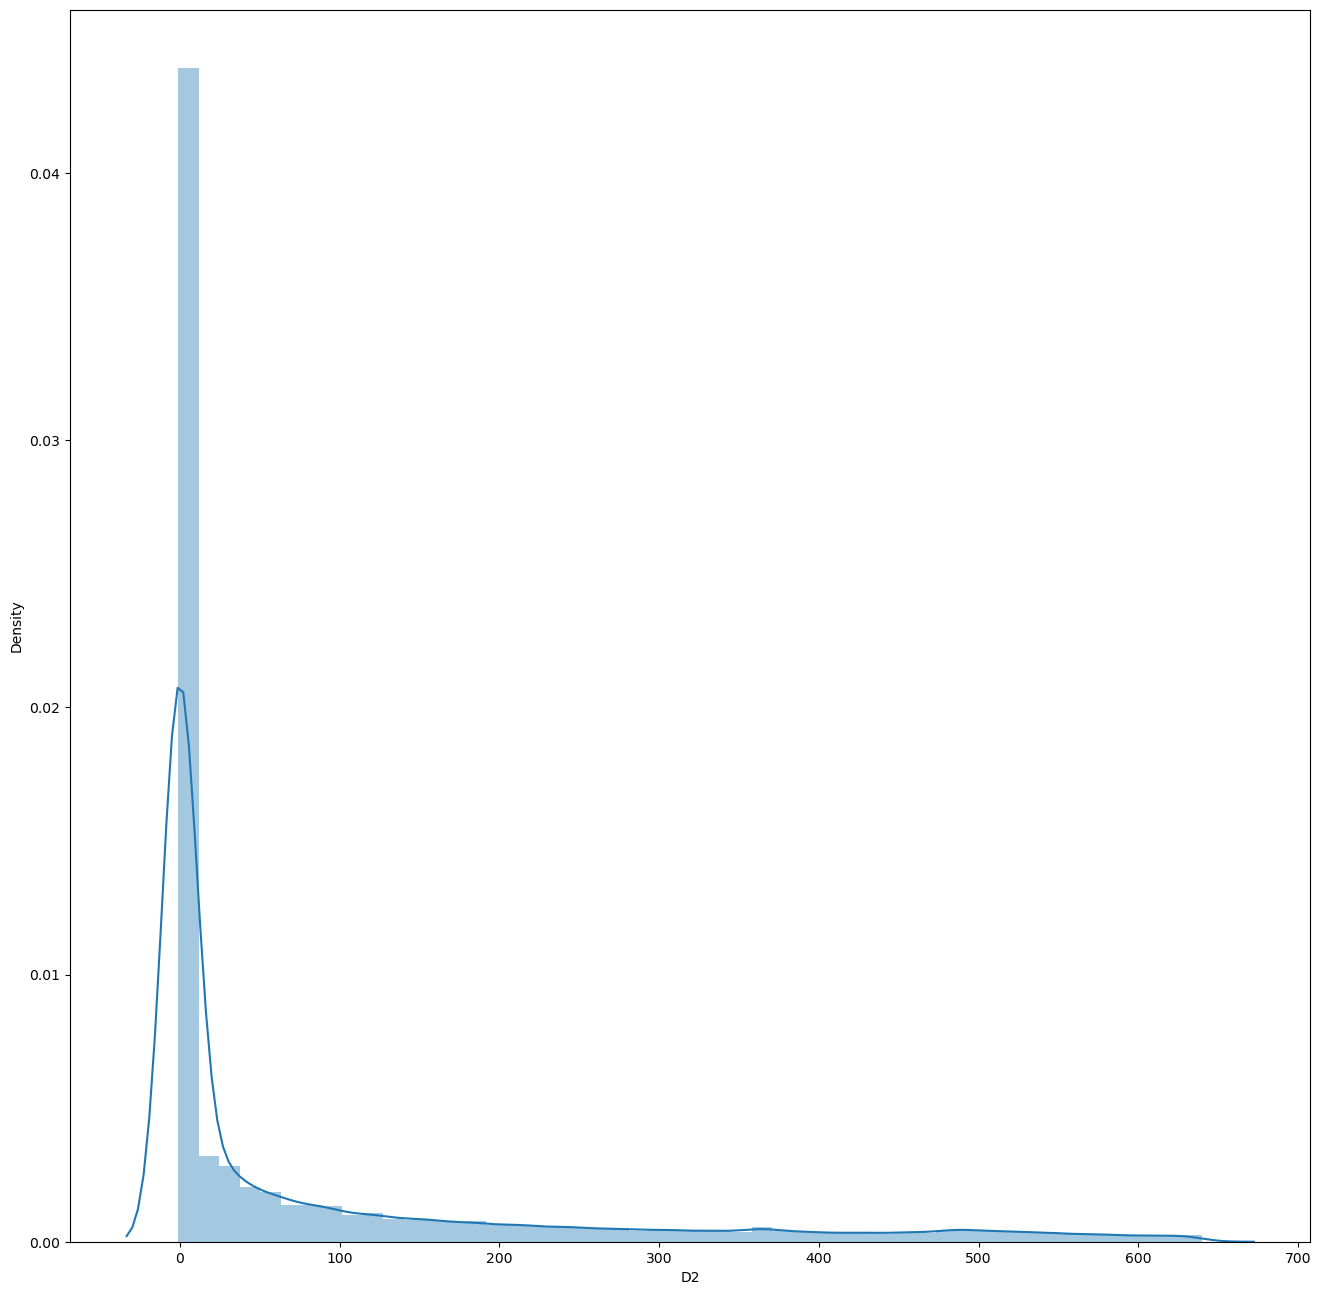

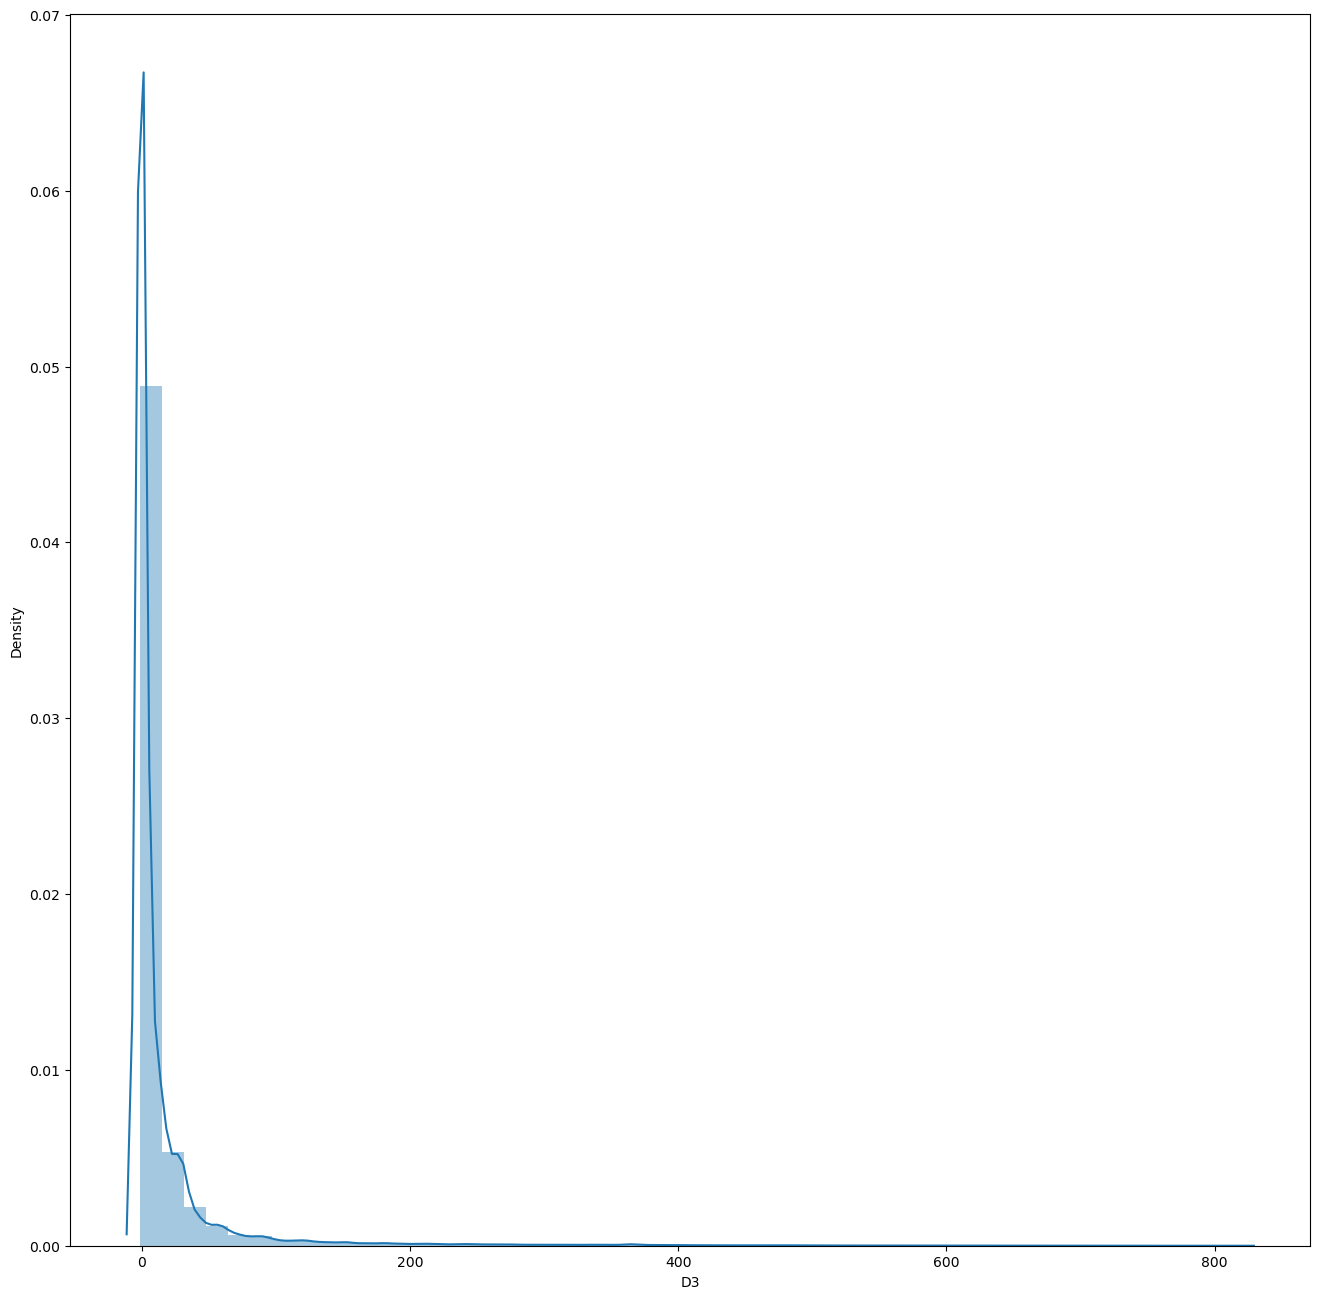

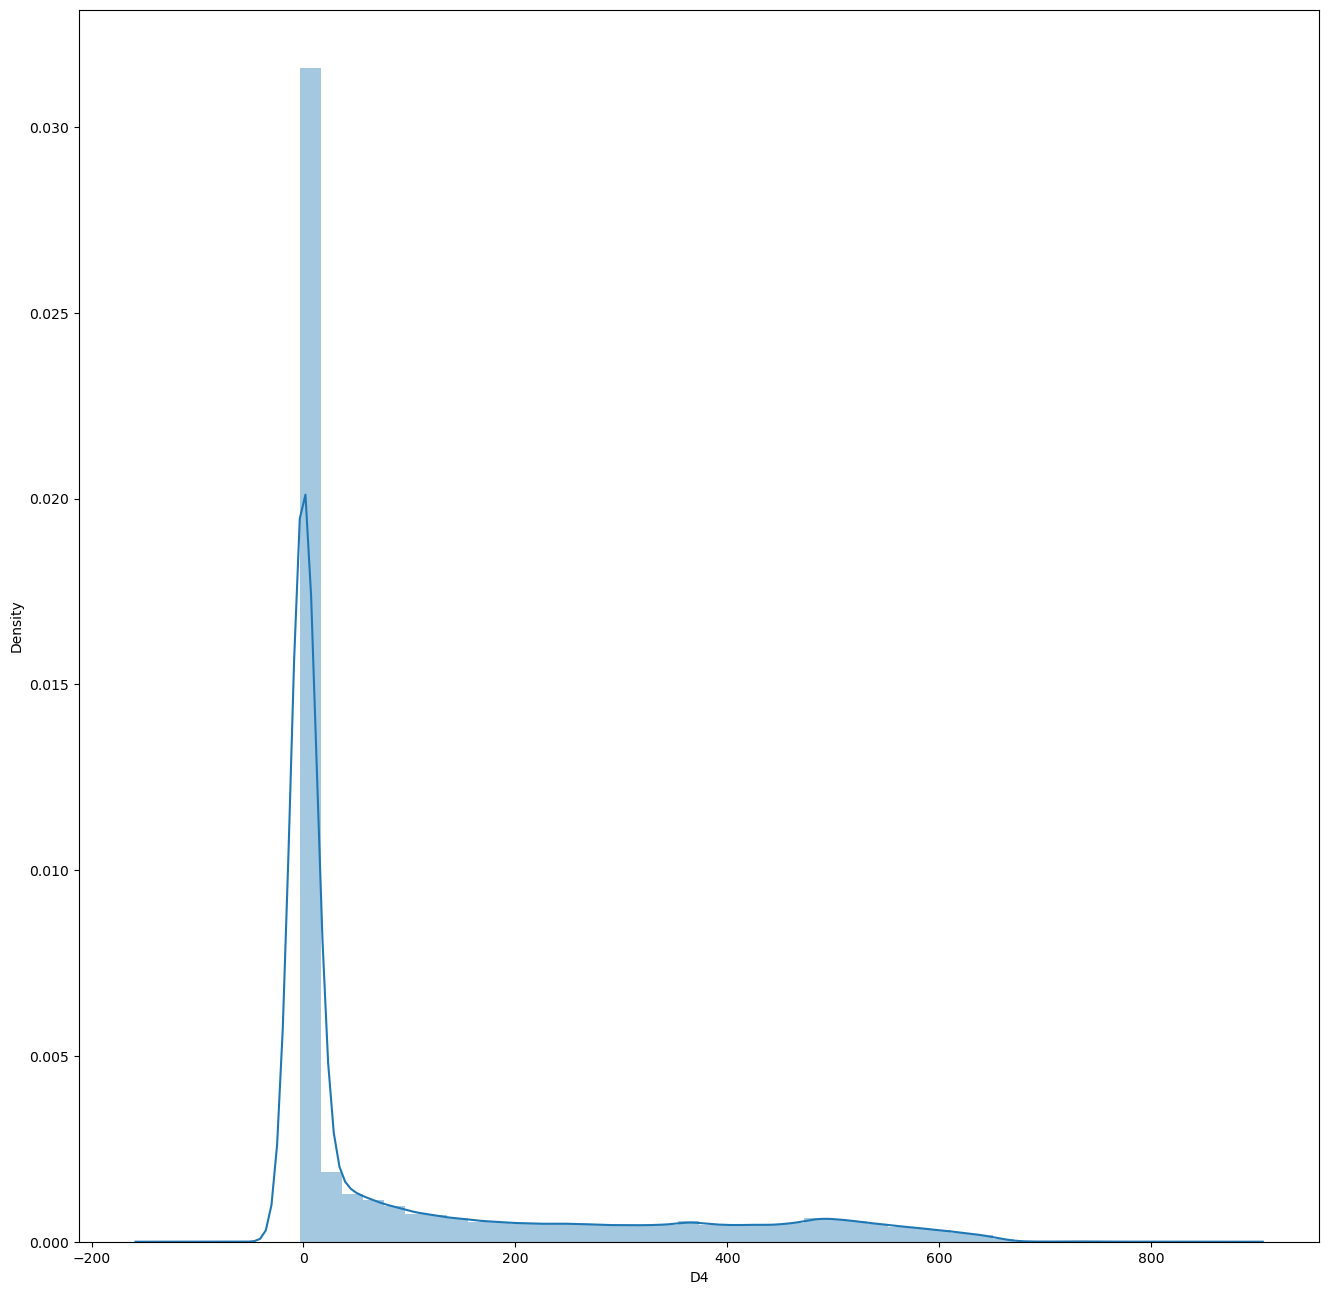

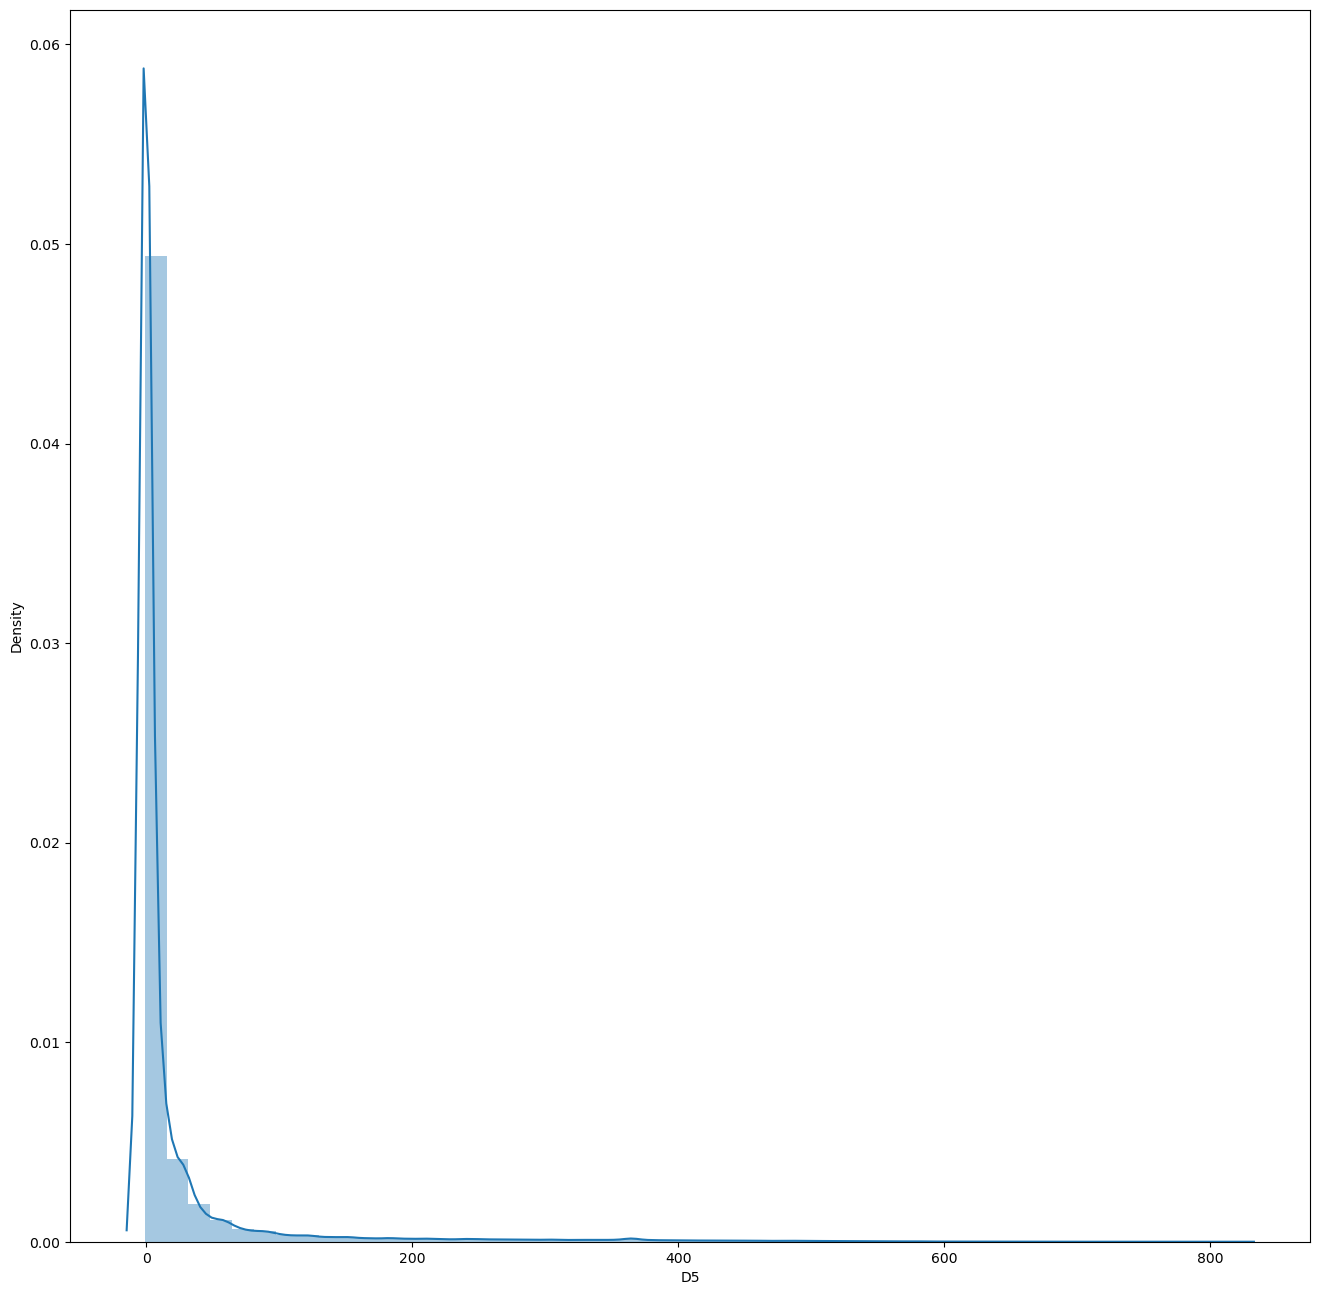

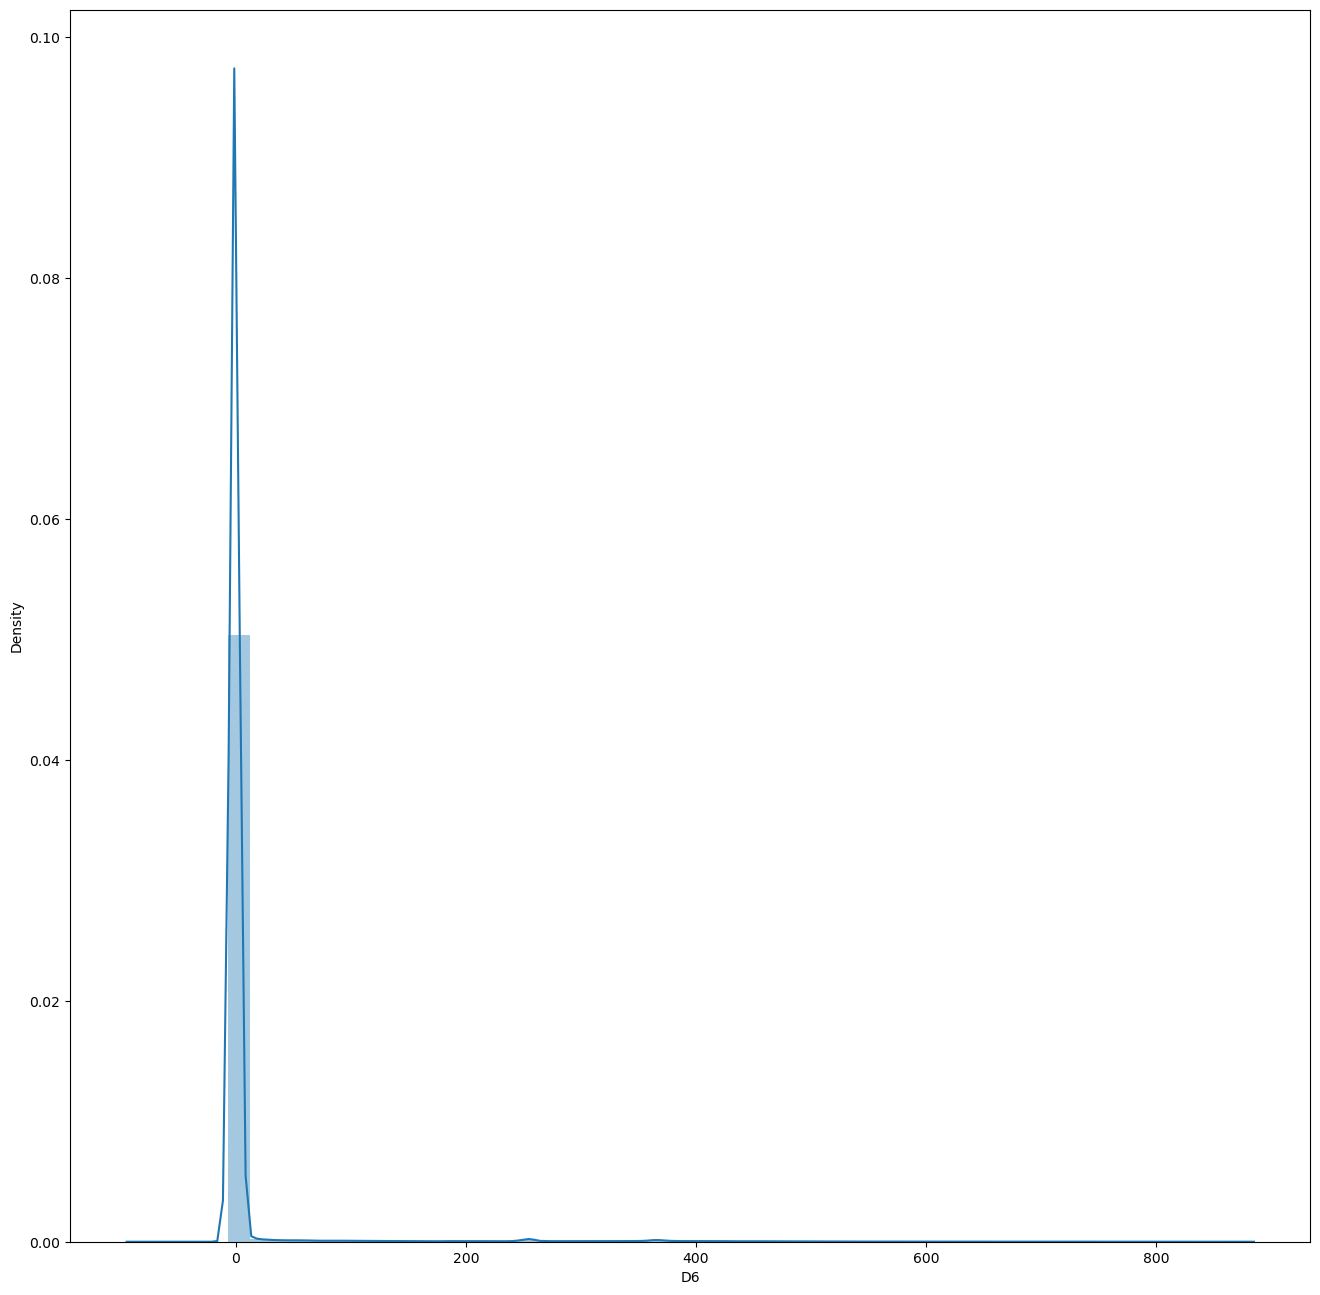

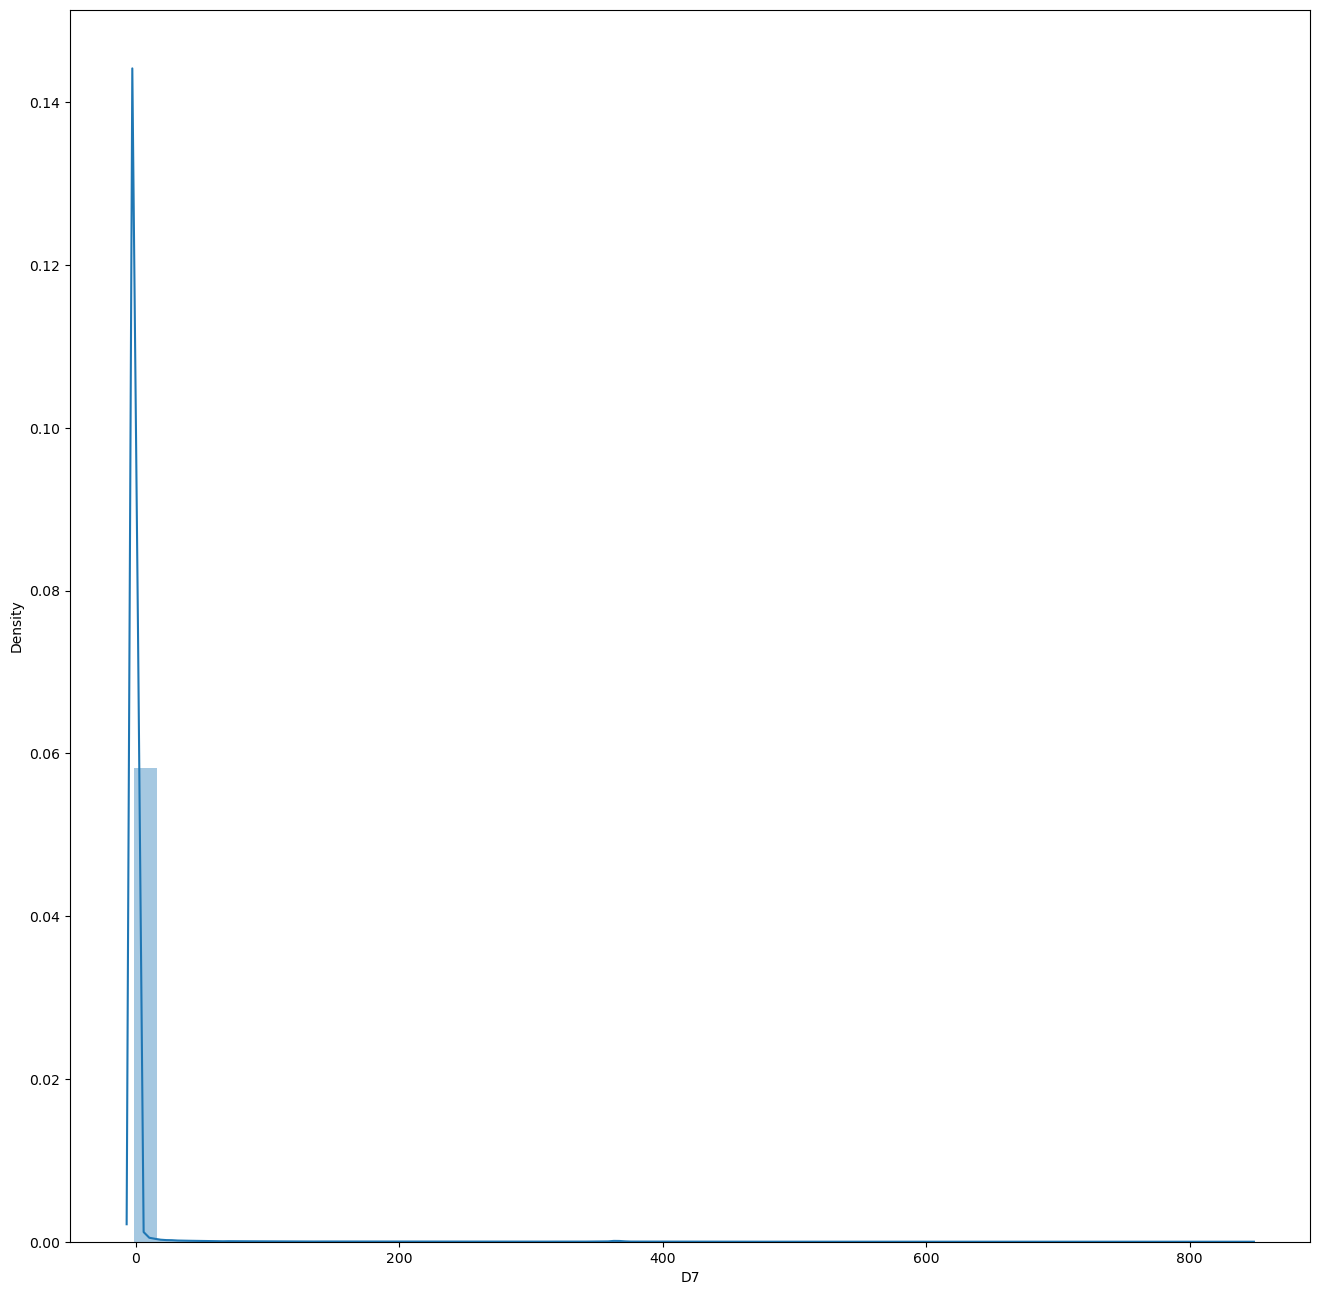

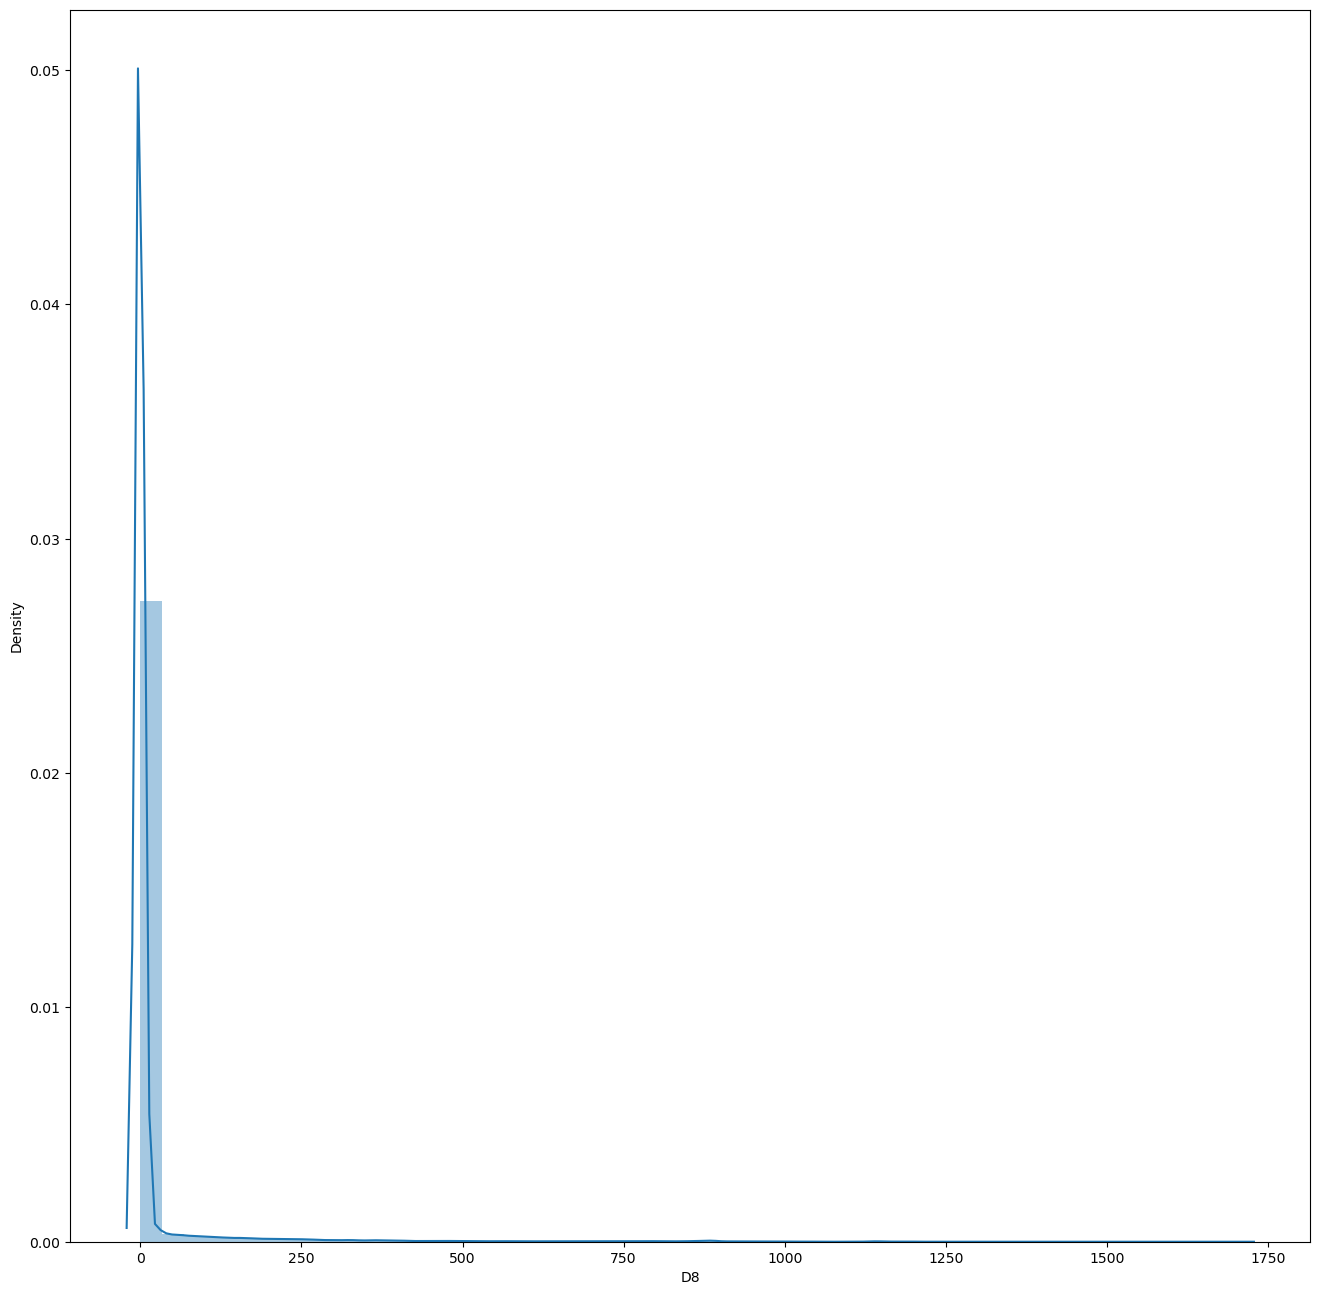

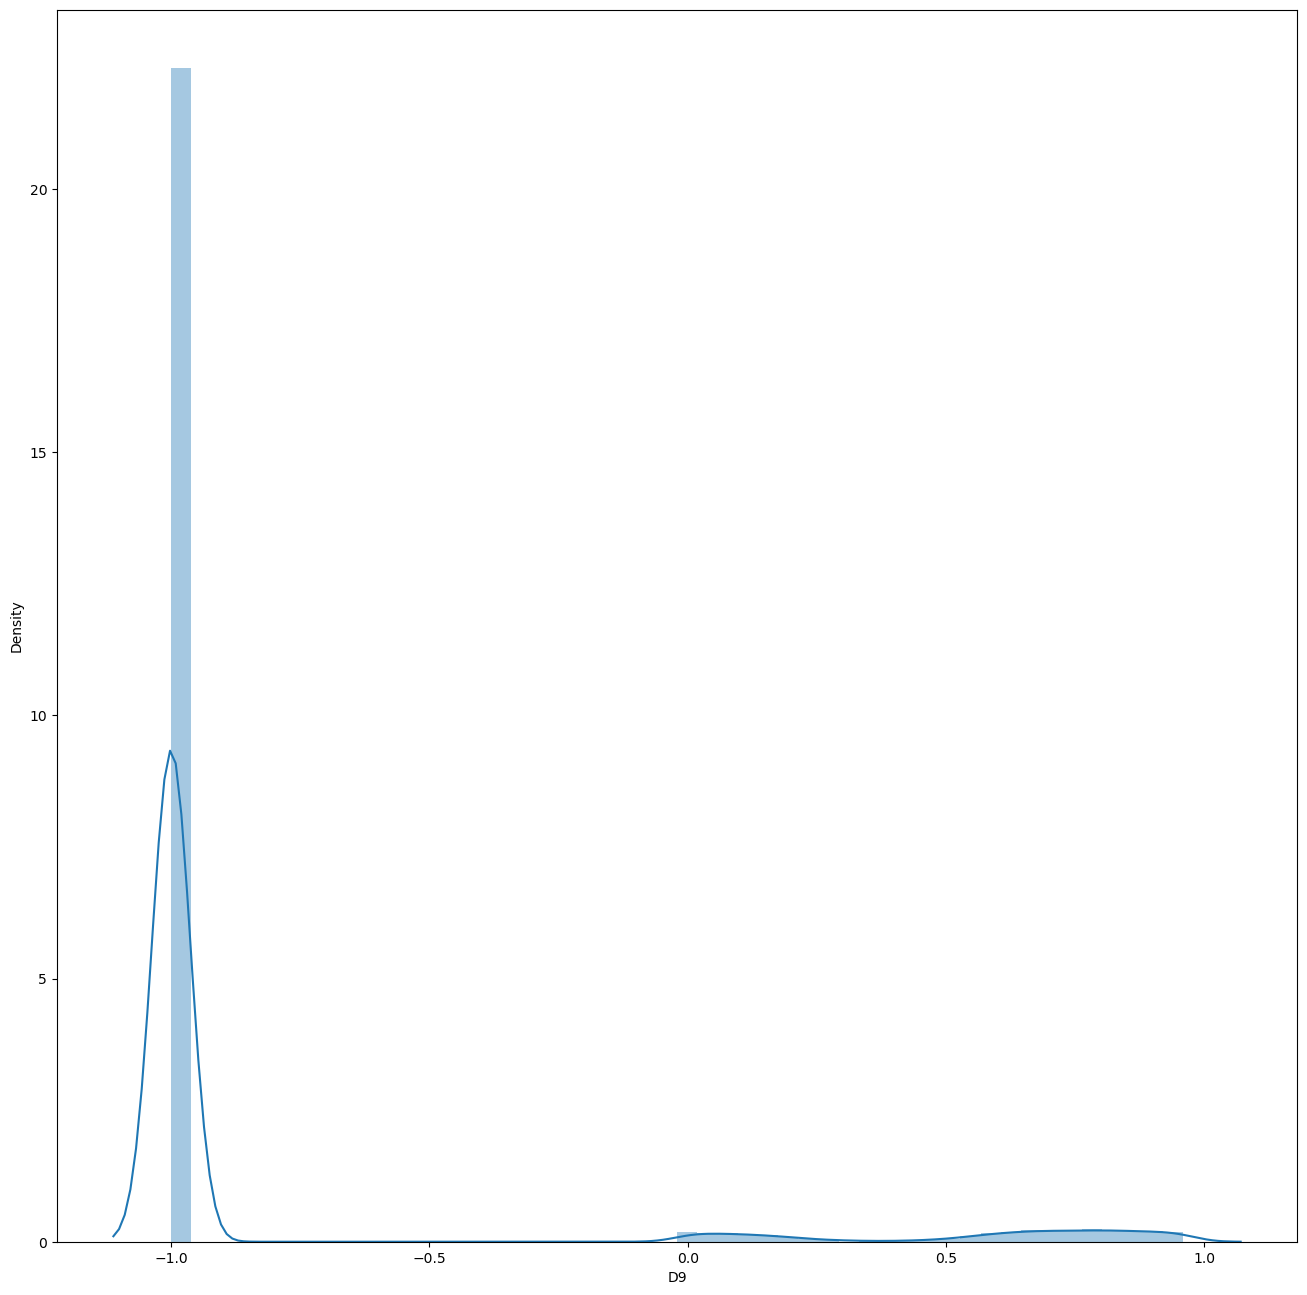

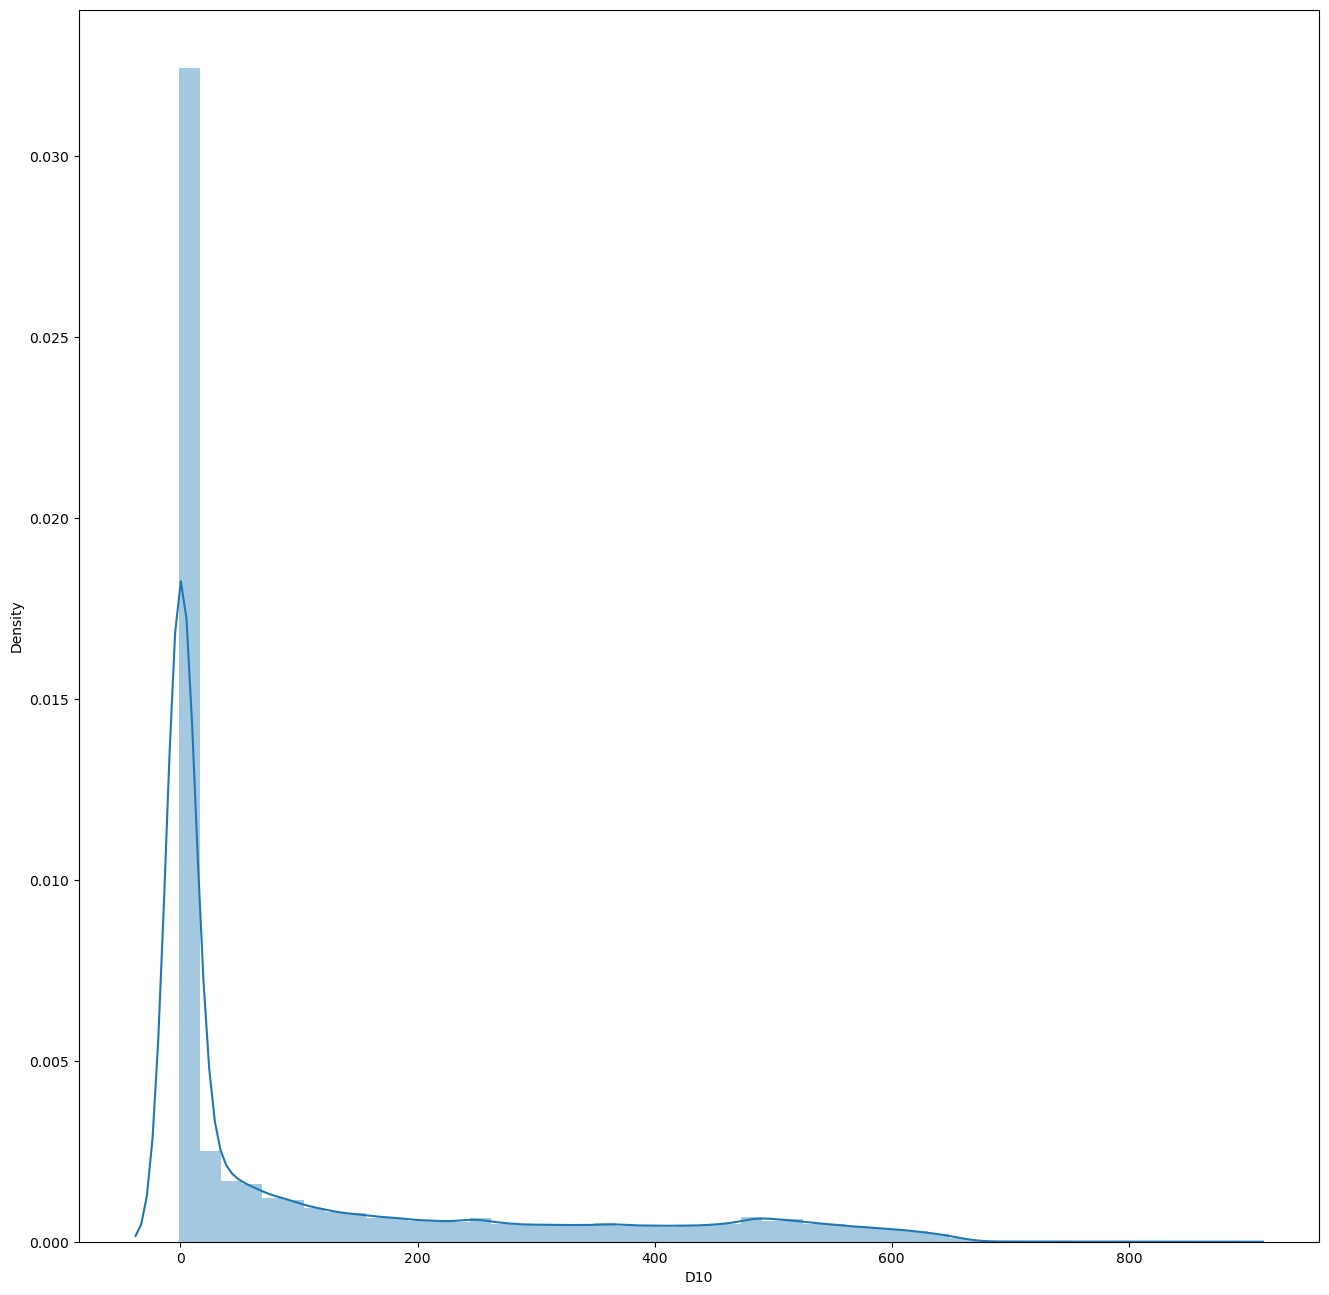

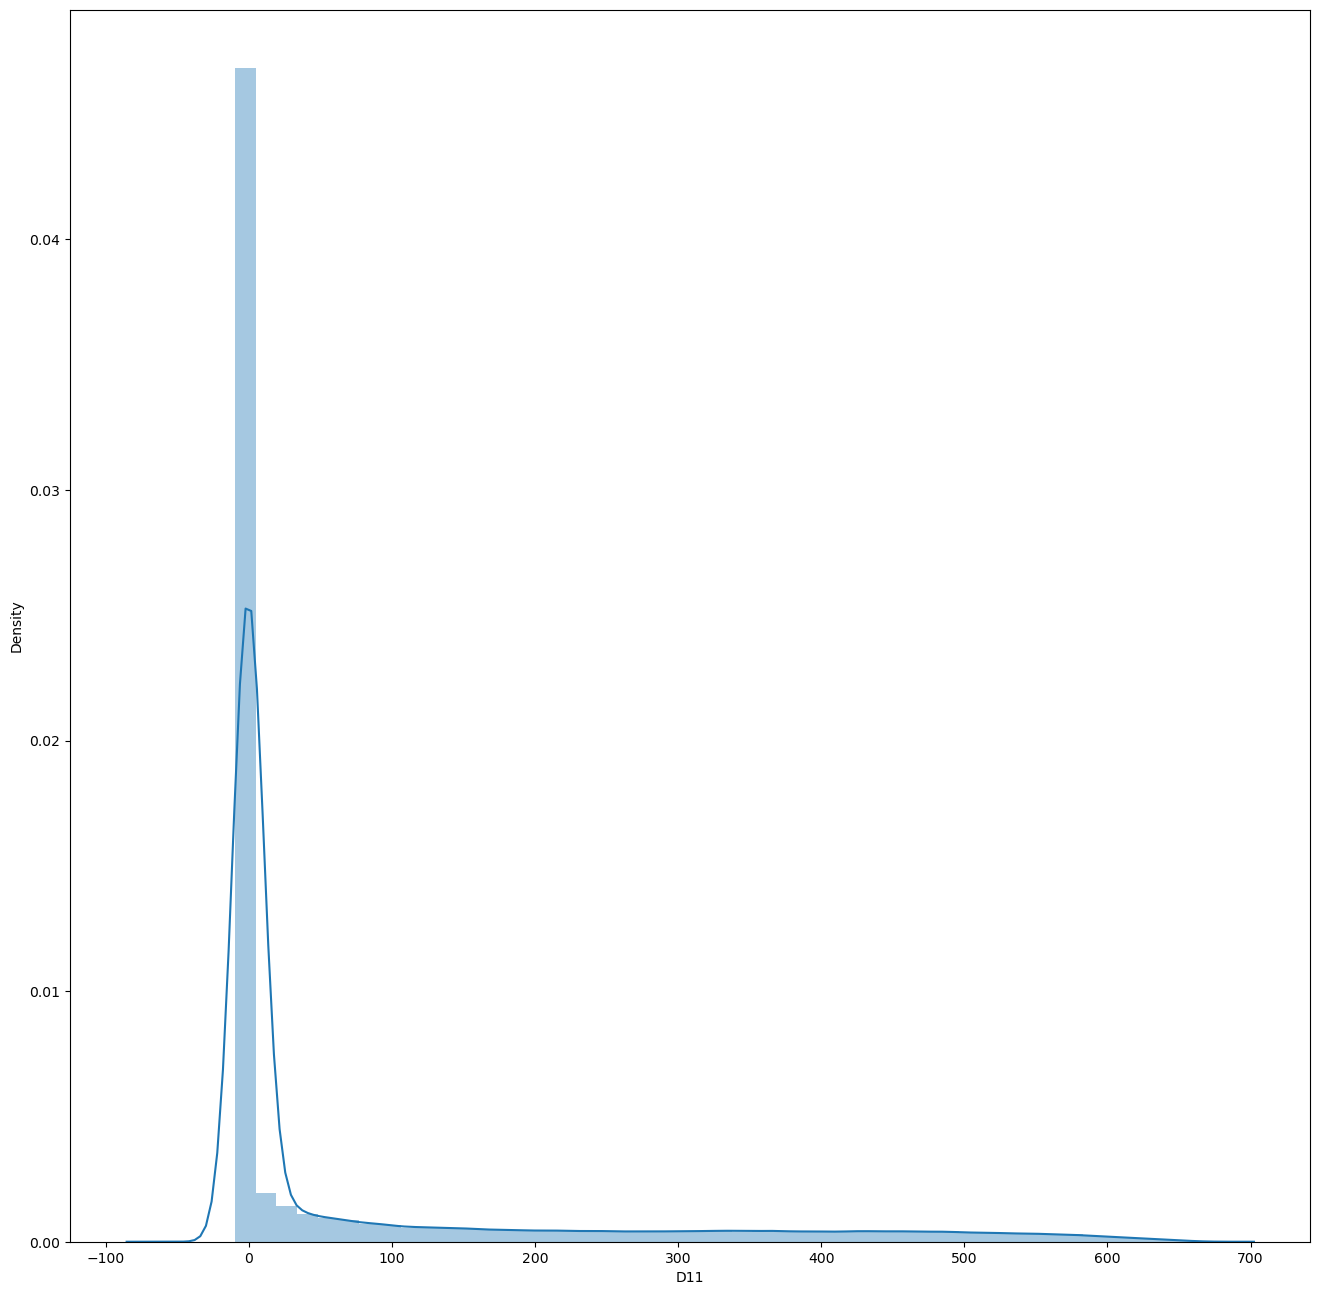

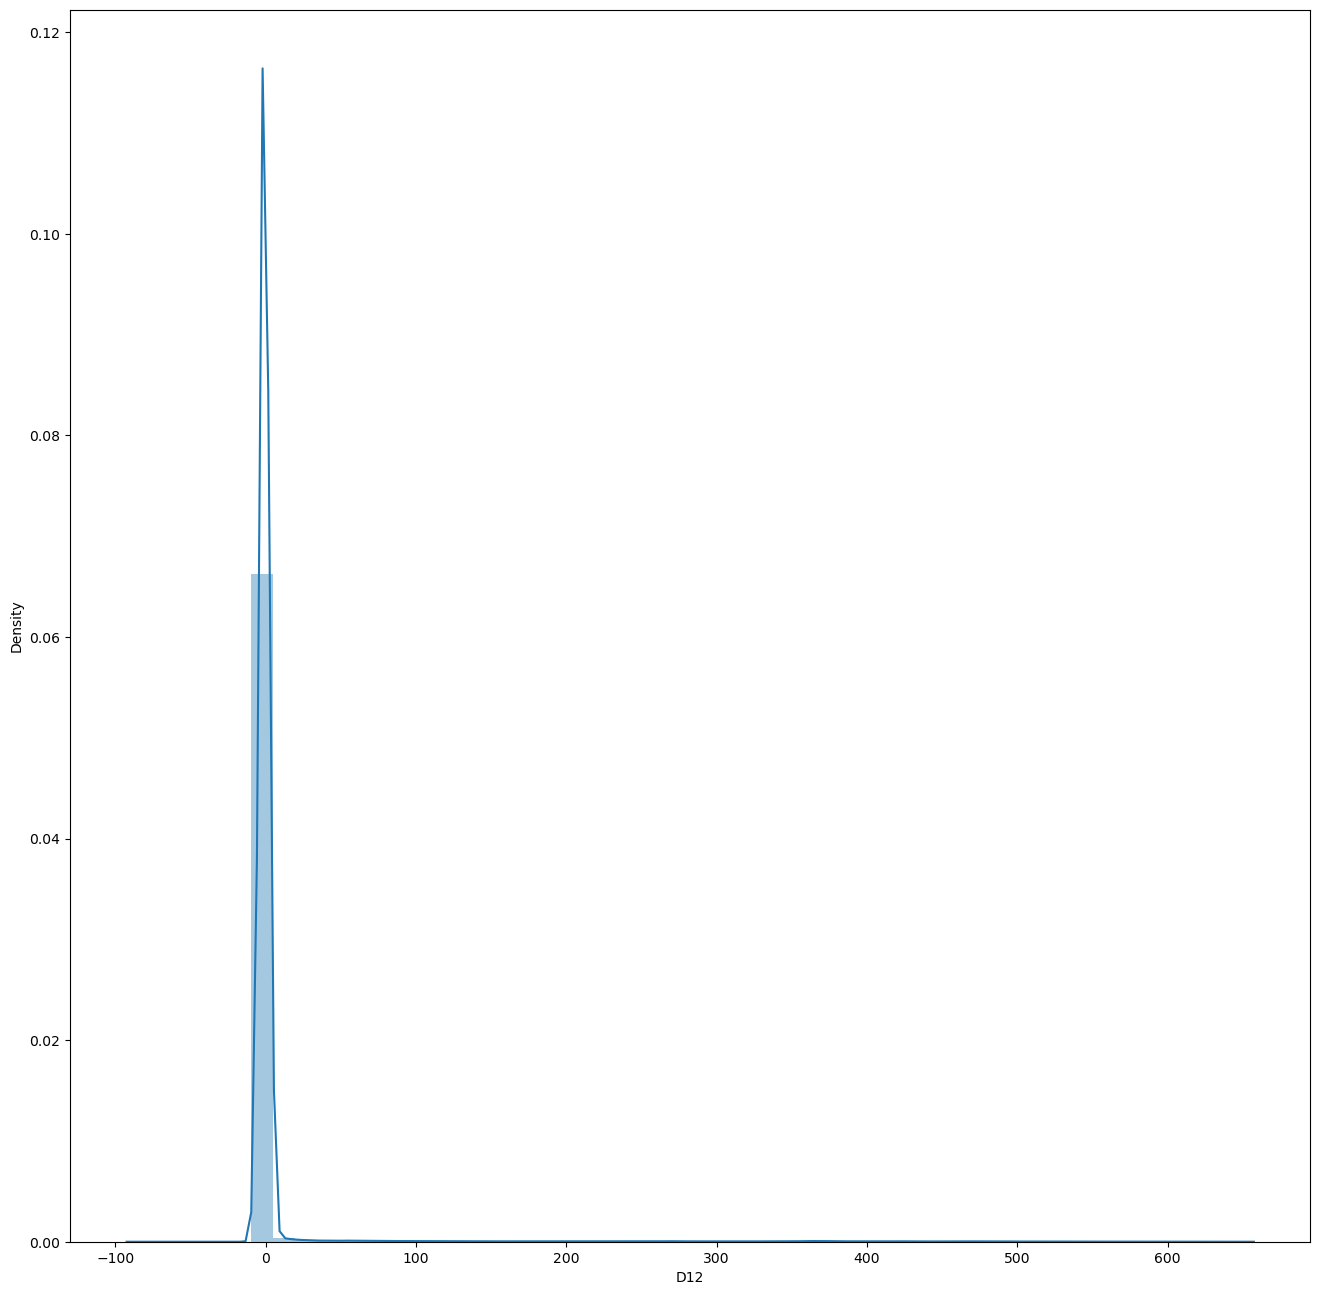

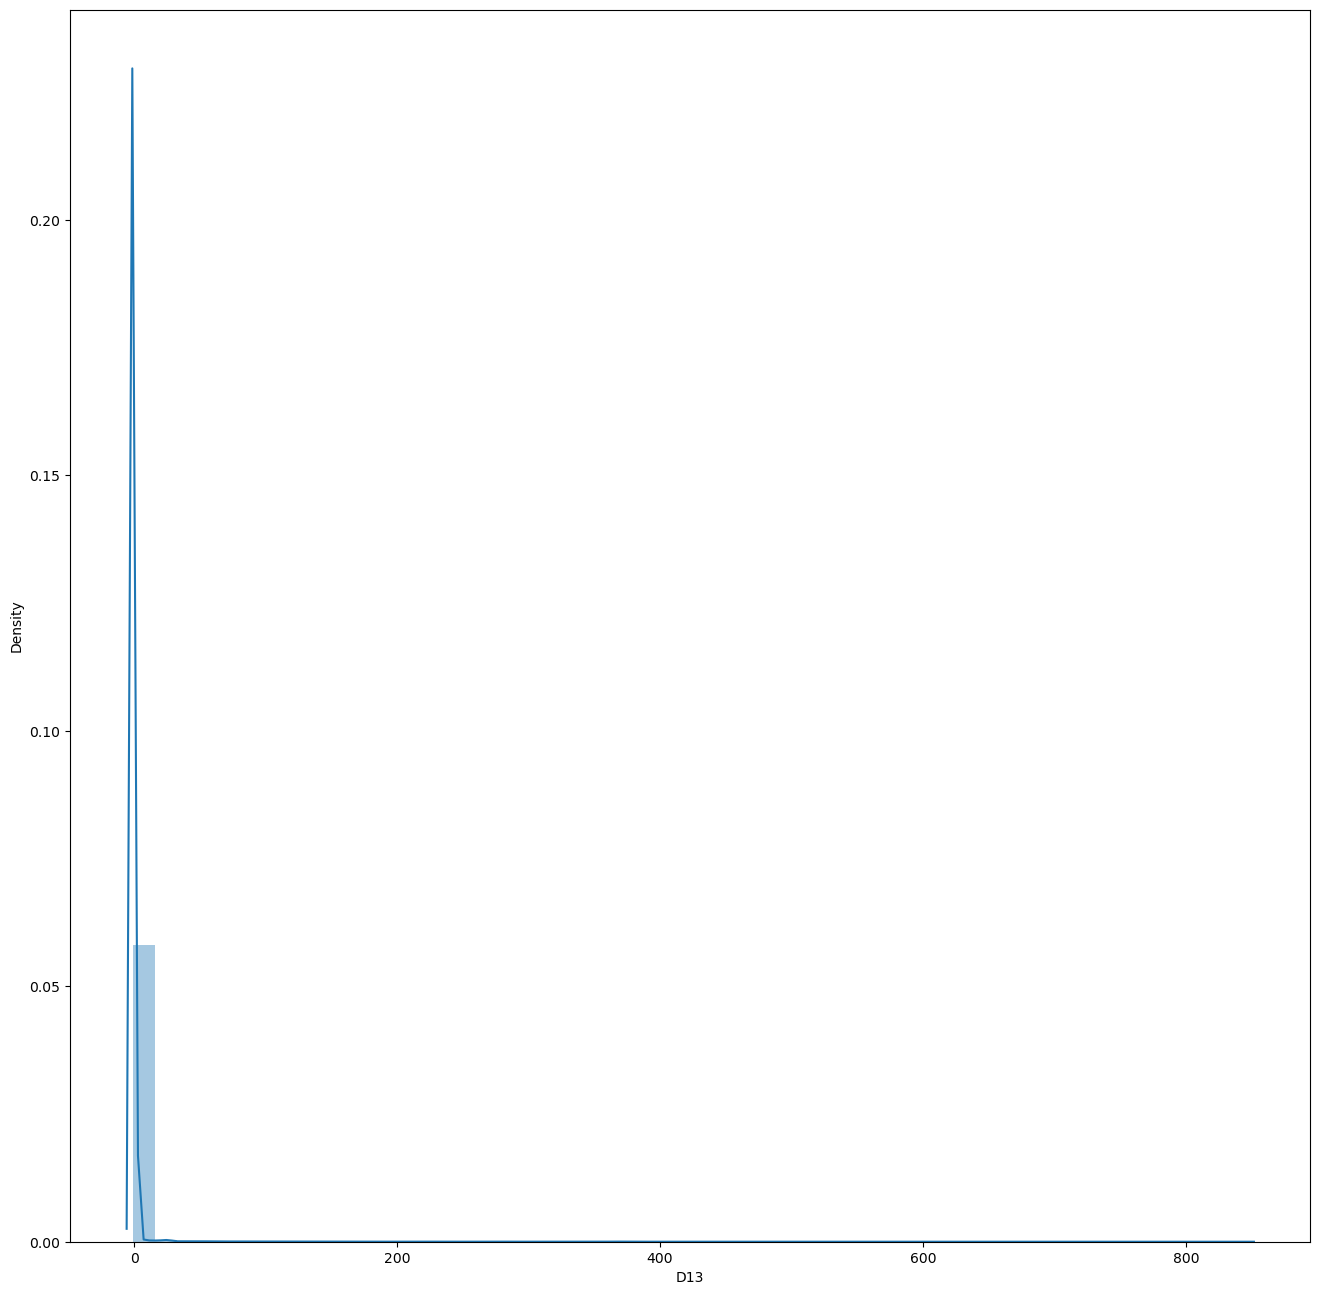

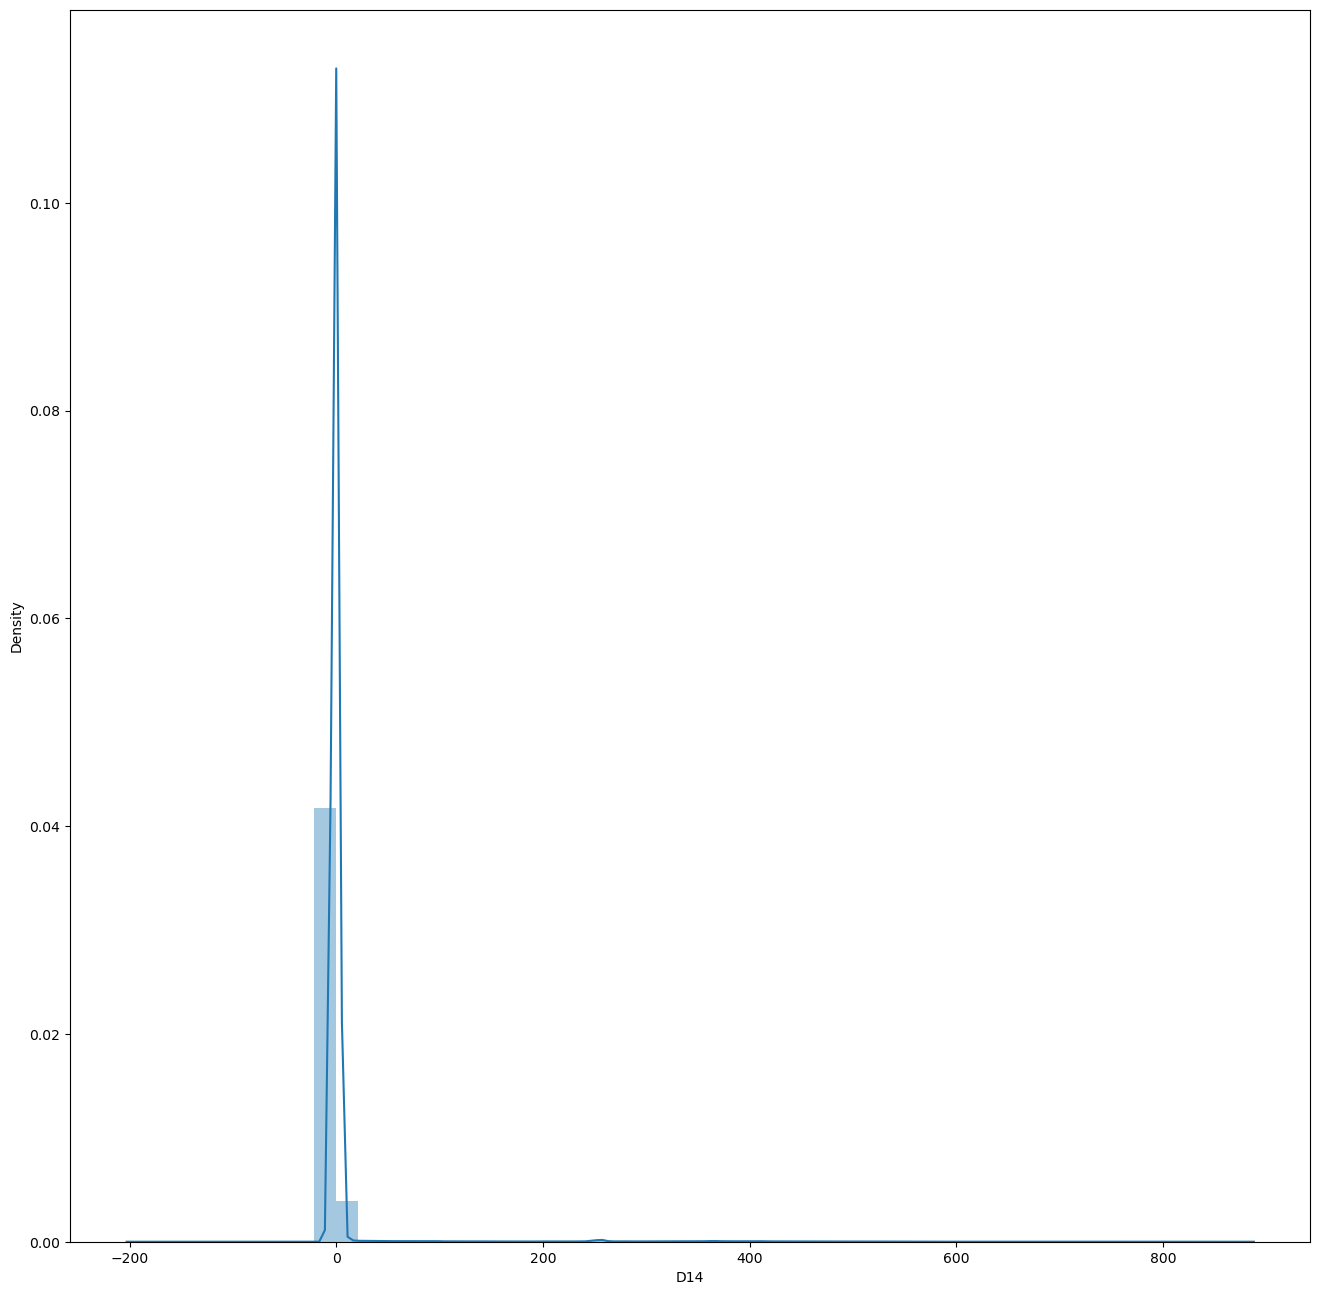

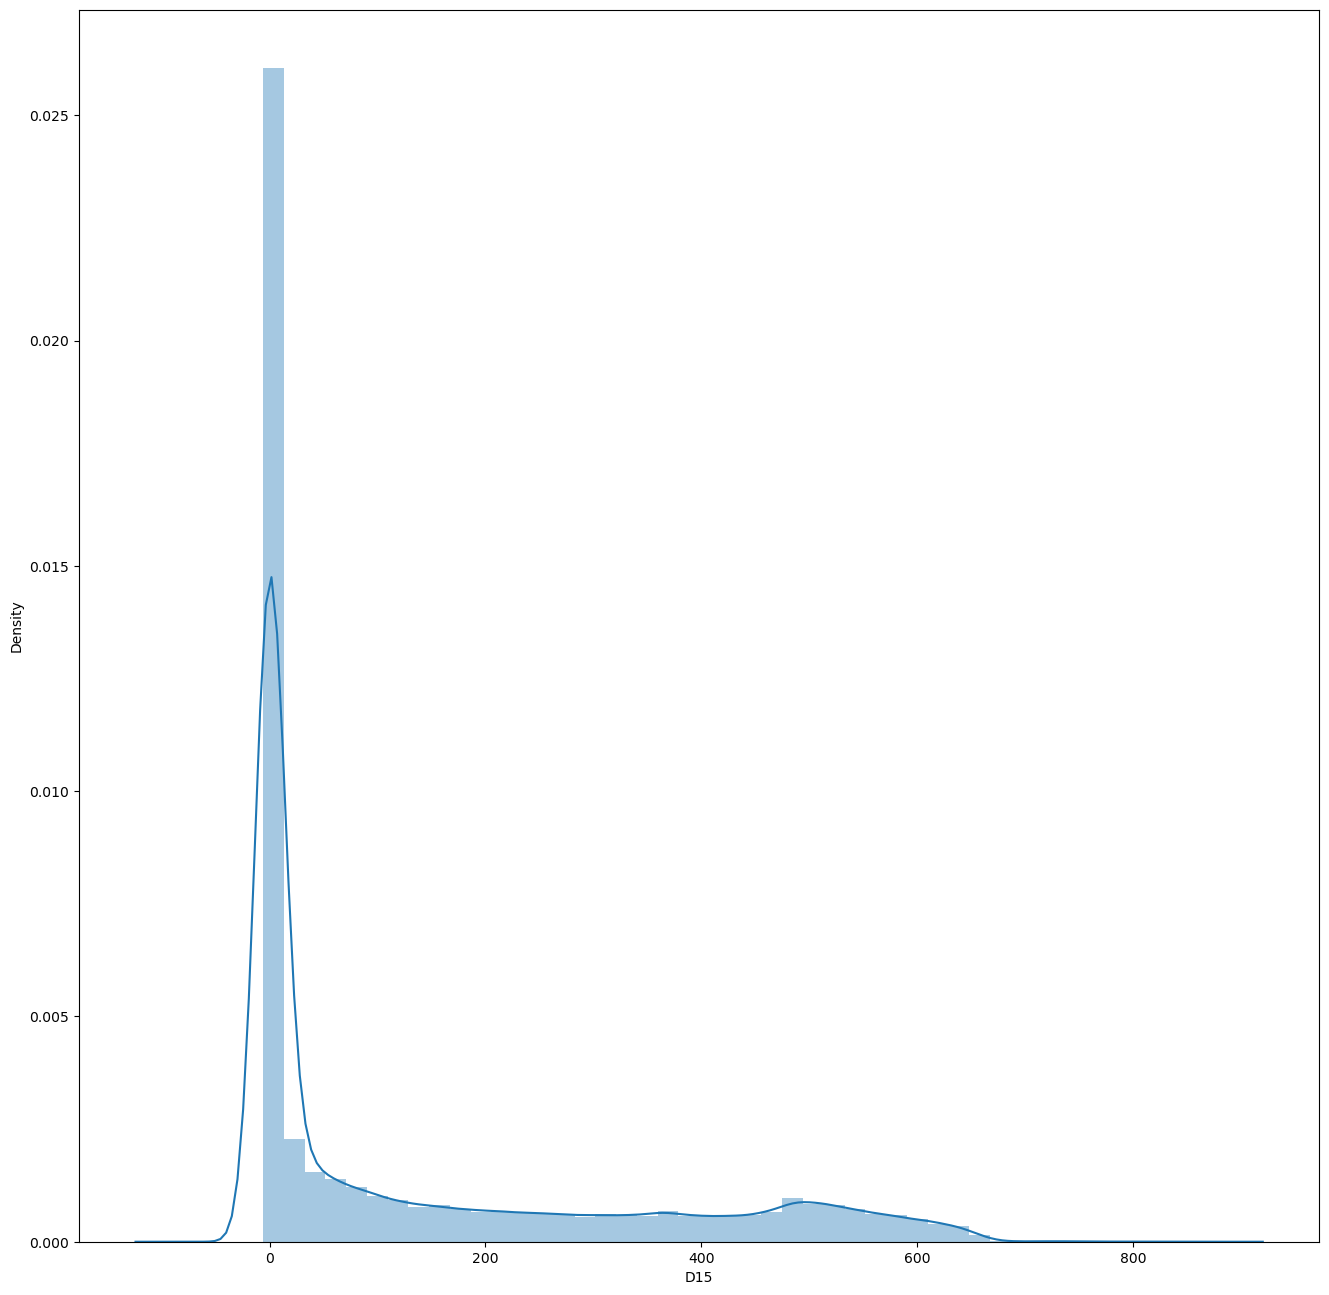

In [31]:
for i in range(1,16):    
    plt.figure(figsize=(16, 16))
    sns.distplot(eval('train_transaction_data["D'+str(i)+'"]'))
    ax.set(ylabel="Distribution")
    ax.set_title(['D'+str(i)])  

In [32]:
del fraudDataTransaction,normalDataTransaction,productData,cardData

In [33]:
np.unique(train_identity_data['id_30'])

array(['Android', 'Android 4.4.2', 'Android 5.0', 'Android 5.0.2',
       'Android 5.1.1', 'Android 6.0', 'Android 6.0.1', 'Android 7.0',
       'Android 7.1.1', 'Android 7.1.2', 'Android 8.0.0', 'Android 8.1.0',
       'Linux', 'Mac', 'Mac OS X 10.10', 'Mac OS X 10.11',
       'Mac OS X 10.12', 'Mac OS X 10.13', 'Mac OS X 10.6',
       'Mac OS X 10.9', 'Mac OS X 10_10_5', 'Mac OS X 10_11_3',
       'Mac OS X 10_11_4', 'Mac OS X 10_11_5', 'Mac OS X 10_11_6',
       'Mac OS X 10_12', 'Mac OS X 10_12_1', 'Mac OS X 10_12_2',
       'Mac OS X 10_12_3', 'Mac OS X 10_12_4', 'Mac OS X 10_12_5',
       'Mac OS X 10_12_6', 'Mac OS X 10_13_1', 'Mac OS X 10_13_2',
       'Mac OS X 10_13_3', 'Mac OS X 10_13_4', 'Mac OS X 10_13_5',
       'Mac OS X 10_6_8', 'Mac OS X 10_7_5', 'Mac OS X 10_8_5',
       'Mac OS X 10_9_5', 'Windows', 'Windows 10', 'Windows 7',
       'Windows 8', 'Windows 8.1', 'Windows Vista', 'Windows XP', 'func',
       'iOS', 'iOS 10.0.2', 'iOS 10.1.1', 'iOS 10.2.0', 'iOS 10.2.1',

In [34]:
#collapse os types - id_30
train_identity_data.loc[train_identity_data['id_30'].str.contains('Mac', na=False), 'id_30'] = 'mac'
train_identity_data.loc[train_identity_data['id_30'].str.contains('iOS', na=False), 'id_30'] = 'iOS'
train_identity_data.loc[train_identity_data['id_30'].str.contains('Android', na=False), 'id_30'] = 'android'
train_identity_data.loc[train_identity_data['id_30'].str.contains('Windows', na=False), 'id_30'] = 'Windows'
train_identity_data.loc[train_identity_data['id_30'].str.contains('Linux', na=False), 'id_30'] = 'Linux'

In [35]:
train_identity_data['device_name'] = train_identity_data['DeviceInfo'].str.split('/', expand=True)[0]

train_identity_data.loc[train_identity_data['device_name'].str.contains('SM', na=False), 'device_name'] = 'Samsung'
train_identity_data.loc[train_identity_data['device_name'].str.contains('SAMSUNG', na=False), 'device_name'] = 'Samsung'
train_identity_data.loc[train_identity_data['device_name'].str.contains('GT-', na=False), 'device_name'] = 'Samsung'
train_identity_data.loc[train_identity_data['device_name'].str.contains('Moto G', na=False), 'device_name'] = 'Motorola'
train_identity_data.loc[train_identity_data['device_name'].str.contains('Moto', na=False), 'device_name'] = 'Motorola'
train_identity_data.loc[train_identity_data['device_name'].str.contains('moto', na=False), 'device_name'] = 'Motorola'
train_identity_data.loc[train_identity_data['device_name'].str.contains('LG-', na=False), 'device_name'] = 'LG'
train_identity_data.loc[train_identity_data['device_name'].str.contains('rv:', na=False), 'device_name'] = 'RV'
train_identity_data.loc[train_identity_data['device_name'].str.contains('HUAWEI', na=False), 'device_name'] = 'Huawei'
train_identity_data.loc[train_identity_data['device_name'].str.contains('ALE-', na=False), 'device_name'] = 'Huawei'
train_identity_data.loc[train_identity_data['device_name'].str.contains('-L', na=False), 'device_name'] = 'Huawei'
train_identity_data.loc[train_identity_data['device_name'].str.contains('Blade', na=False), 'device_name'] = 'ZTE'
train_identity_data.loc[train_identity_data['device_name'].str.contains('BLADE', na=False), 'device_name'] = 'ZTE'
train_identity_data.loc[train_identity_data['device_name'].str.contains('Linux', na=False), 'device_name'] = 'Linux'
train_identity_data.loc[train_identity_data['device_name'].str.contains('XT', na=False), 'device_name'] = 'Sony'
train_identity_data.loc[train_identity_data['device_name'].str.contains('HTC', na=False), 'device_name'] = 'HTC'
train_identity_data.loc[train_identity_data['device_name'].str.contains('ASUS', na=False), 'device_name'] = 'Asus'

train_identity_data.loc[train_identity_data.device_name.isin(train_identity_data.device_name.value_counts()[train_identity_data.device_name.value_counts() < 200].index), 'device_name'] = "Others"

In [36]:
np.unique(train_identity_data['id_30'])

array(['Linux', 'Windows', 'android', 'func', 'iOS', 'mac', 'missing',
       'other'], dtype=object)

In [37]:
print(np.unique(train_identity_data['id_31']))
train_identity_data['id_31'] = train_identity_data['id_31'].str.replace('\d+', '')
print(np.unique(train_identity_data['id_31']))

['BLU/Dash' 'Cherry' 'Generic/Android' 'Generic/Android 7.0' 'Inco/Minion'
 'LG/K-200' 'Lanix/Ilium' 'M4Tel/M4' 'Microsoft/Windows' 'Mozilla/Firefox'
 'Nokia/Lumia' 'Samsung/SCH' 'Samsung/SM-G531H' 'Samsung/SM-G532M'
 'ZTE/Blade' 'android' 'android browser 4.0' 'android webview 4.0' 'aol'
 'chrome' 'chrome 43.0 for android' 'chrome 46.0 for android'
 'chrome 49.0' 'chrome 49.0 for android' 'chrome 50.0 for android'
 'chrome 51.0' 'chrome 51.0 for android' 'chrome 52.0 for android'
 'chrome 53.0 for android' 'chrome 54.0 for android' 'chrome 55.0'
 'chrome 55.0 for android' 'chrome 56.0' 'chrome 56.0 for android'
 'chrome 57.0' 'chrome 57.0 for android' 'chrome 58.0'
 'chrome 58.0 for android' 'chrome 59.0' 'chrome 59.0 for android'
 'chrome 60.0' 'chrome 60.0 for android' 'chrome 61.0'
 'chrome 61.0 for android' 'chrome 62.0' 'chrome 62.0 for android'
 'chrome 62.0 for ios' 'chrome 63.0' 'chrome 63.0 for android'
 'chrome 63.0 for ios' 'chrome 64.0' 'chrome 64.0 for android'
 'chrome 6

C:\Users\Mehrad Tavanamehr\AppData\Local\Temp\ipykernel_10956\394079361.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_identity_data['id_31'] = train_identity_data['id_31'].str.replace('\d+', '')


['BLU/Dash' 'Cherry' 'Generic/Android' 'Generic/Android .' 'Inco/Minion'
 'LG/K-' 'Lanix/Ilium' 'MTel/M' 'Microsoft/Windows' 'Mozilla/Firefox'
 'Nokia/Lumia' 'Samsung/SCH' 'Samsung/SM-GH' 'Samsung/SM-GM' 'ZTE/Blade'
 'android' 'android browser .' 'android webview .' 'aol' 'chrome'
 'chrome .' 'chrome . for android' 'chrome . for ios' 'chrome generic'
 'chrome generic for android' 'chromium' 'comodo' 'cyberfox' 'edge'
 'edge .' 'facebook' 'firefox' 'firefox .' 'firefox generic'
 'firefox mobile .' 'google' 'google search application .' 'icedragon'
 'ie' 'ie . for desktop' 'ie . for tablet' 'iron' 'line' 'maxthon'
 'missing' 'mobile' 'mobile safari .' 'mobile safari generic'
 'mobile safari uiwebview' 'opera' 'opera .' 'opera generic' 'other'
 'palemoon' 'puffin' 'safari' 'safari .' 'safari generic' 'samsung'
 'samsung browser .' 'samsung browser generic' 'seamonkey' 'silk'
 'waterfox']


D:\Anaconda\Documents\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='DeviceType', ylabel='count'>

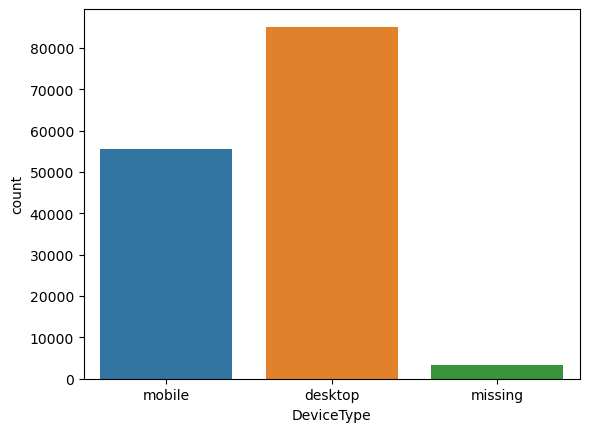

In [38]:
sns.countplot(train_identity_data['DeviceType'])

In [39]:
raw_train_data = pd.merge(train_transaction_data, train_identity_data, on='TransactionID', how='left')
del train_transaction_data,train_identity_data

In [40]:
raw_train_data_columns = raw_train_data.columns
numericCols = raw_train_data._get_numeric_data().columns
categoricalCols = list(set(raw_train_data_columns) - set(numericCols))
print('The categorical columns in training data are: ',categoricalCols)
raw_train_data[categoricalCols] = raw_train_data[categoricalCols].replace({ np.nan:'missing'})
raw_train_data[numericCols] = raw_train_data[numericCols].replace({ np.nan:-1})

The categorical columns in training data are:  ['M1', 'M9', 'DeviceInfo', 'M7', 'card6', 'M2', 'ProductCD', 'id_35', 'id_37', 'id_12', 'id_38', 'id_15', 'id_29', 'card4', 'id_36', 'id_23', 'id_28', 'P_emaildomain', 'id_27', 'id_31', 'M6', 'id_16', 'device_name', 'M3', 'M5', 'R_emaildomain', 'id_34', 'M8', 'id_33', 'id_30', 'M4', 'DeviceType']


In [41]:
raw_train_data = reduce_memory_usage(raw_train_data, deep=True, verbose=True)
print(raw_train_data.head(10))

Column 'TransactionID' converted from int64 to int32
Column 'isFraud' converted from int64 to int8
Column 'TransactionDT' converted from int64 to int32
Column 'TransactionAmt' converted from float64 to float32
Column 'card1' converted from int64 to int16
Column 'card2' converted from float64 to float32
Column 'card3' converted from float64 to float32
Column 'card5' converted from float64 to float32
Column 'addr1' converted from float64 to float32
Column 'addr2' converted from float64 to float32
Column 'dist1' converted from float64 to float32
Column 'dist2' converted from float64 to float32
Column 'C1' converted from float64 to float32
Column 'C2' converted from float64 to float32
Column 'C3' converted from float64 to float32
Column 'C4' converted from float64 to float32
Column 'C5' converted from float64 to float32
Column 'C6' converted from float64 to float32
Column 'C7' converted from float64 to float32
Column 'C8' converted from float64 to float32
Column 'C9' converted from float64

Column 'V158' converted from float64 to float32
Column 'V159' converted from float64 to float32
Column 'V160' converted from float64 to float32
Column 'V161' converted from float64 to float32
Column 'V162' converted from float64 to float32
Column 'V163' converted from float64 to float32
Column 'V164' converted from float64 to float32
Column 'V165' converted from float64 to float32
Column 'V166' converted from float64 to float32
Column 'V167' converted from float64 to float32
Column 'V168' converted from float64 to float32
Column 'V169' converted from float64 to float32
Column 'V170' converted from float64 to float32
Column 'V171' converted from float64 to float32
Column 'V172' converted from float64 to float32
Column 'V173' converted from float64 to float32
Column 'V174' converted from float64 to float32
Column 'V175' converted from float64 to float32
Column 'V176' converted from float64 to float32
Column 'V177' converted from float64 to float32
Column 'V178' converted from float64 to 

Column 'V338' converted from float64 to float32
Column 'V339' converted from float64 to float32
Column 'Transaction_dow' converted from float64 to float32
Column 'Transaction_hour' converted from float64 to float32
Column 'id_01' converted from float64 to float32
Column 'id_02' converted from float64 to float32
Column 'id_03' converted from float64 to float32
Column 'id_04' converted from float64 to float32
Column 'id_05' converted from float64 to float32
Column 'id_06' converted from float64 to float32
Column 'id_07' converted from float64 to float32
Column 'id_08' converted from float64 to float32
Column 'id_09' converted from float64 to float32
Column 'id_10' converted from float64 to float32
Column 'id_11' converted from float64 to float32
Column 'id_13' converted from float64 to float32
Column 'id_14' converted from float64 to float32
Column 'id_17' converted from float64 to float32
Column 'id_18' converted from float64 to float32
Column 'id_19' converted from float64 to float32
C

D:\Anaconda\Documents\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
D:\Anaconda\Documents\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
D:\Anaconda\Documents\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


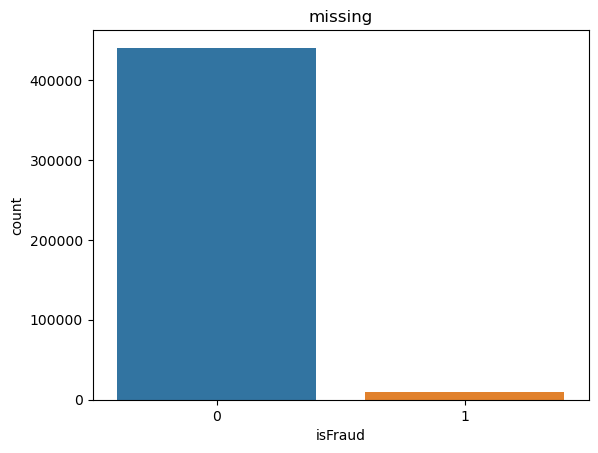

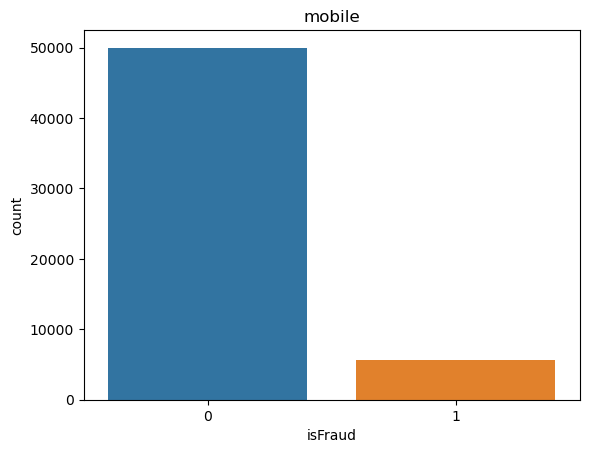

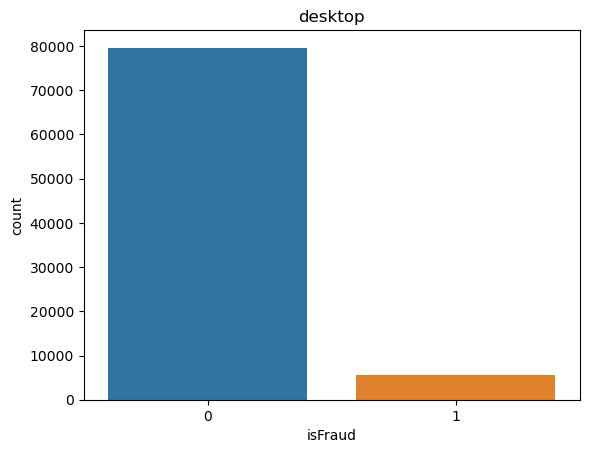

In [42]:
deviceTypes = raw_train_data['DeviceType'].unique()
for i,i_device in enumerate(deviceTypes):
    deviceData = eval('raw_train_data.loc[raw_train_data["DeviceType"]=="'+i_device+'"]')
    plt.figure(i)
    sns.countplot(deviceData['isFraud']).set_title(i_device)

C:\Users\Mehrad Tavanamehr\AppData\Local\Temp\ipykernel_10956\1037889121.py:16: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = correlationMatrix.where(np.triu(np.ones(correlationMatrix.shape), k=1).astype(np.bool))


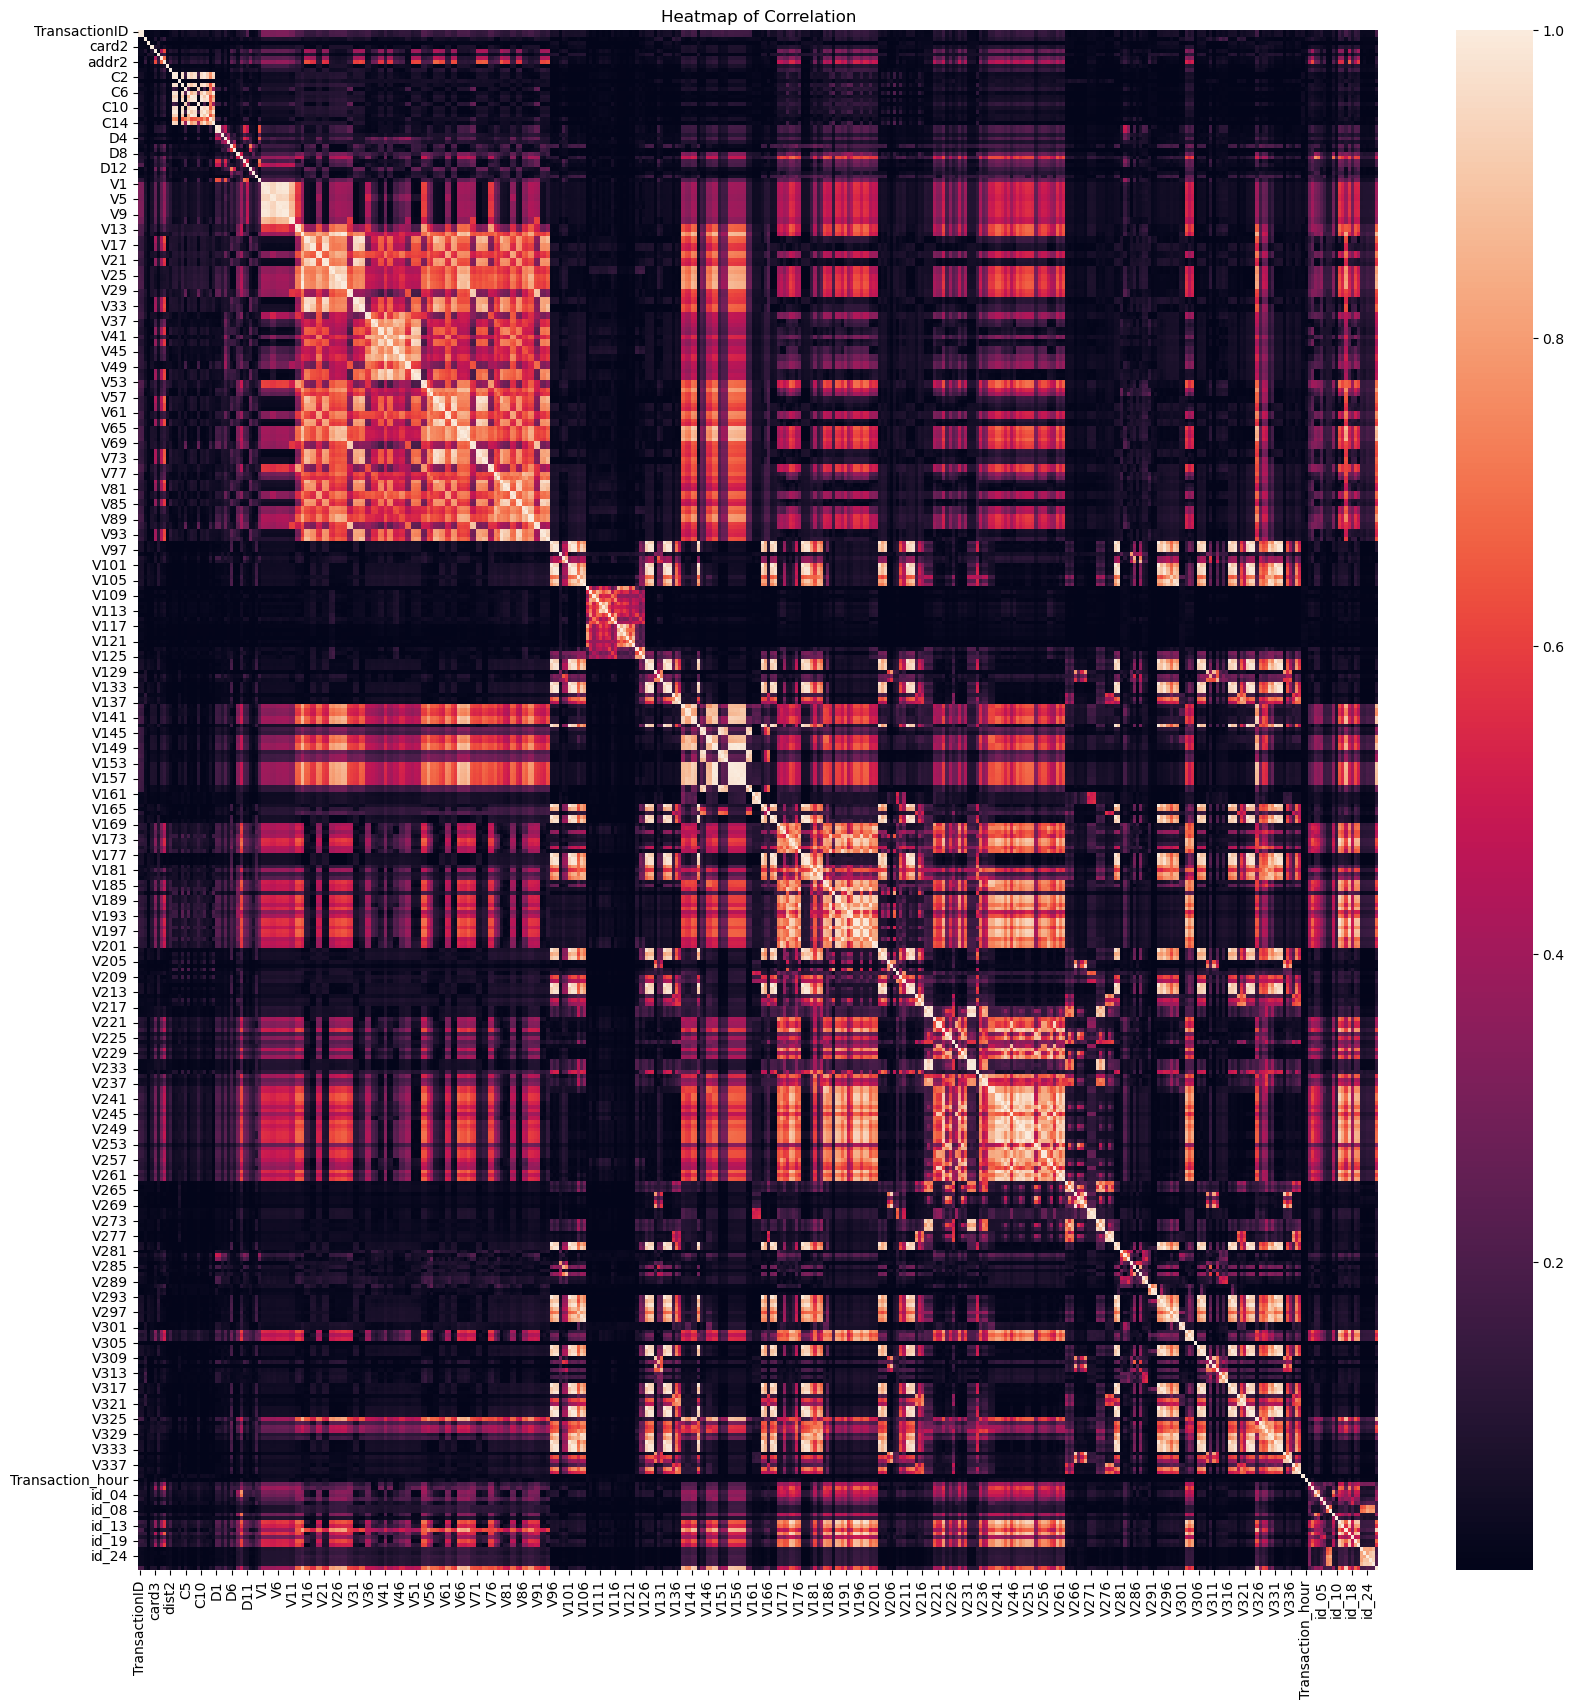

In [43]:
variables = list(numericCols)
variables.remove('isFraud')
correlationMatrix = raw_train_data.loc[:, variables].corr().abs()
plt.figure(figsize=(20,20))
heat = sns.heatmap(data=correlationMatrix)
plt.title('Heatmap of Correlation')
na_vals = np.sum(raw_train_data.loc[:,variables]==-1)/raw_train_data.shape[0]
goodNumericVars = []
for i_var in variables:    
    if na_vals[i_var] < 1:        
        goodNumericVars.append(i_var)
goodNumericVars.remove('TransactionDT')
goodNumericVars.remove('TransactionID')
corrThresh = 1
# Select upper triangle of correlation matrix
upper = correlationMatrix.where(np.triu(np.ones(correlationMatrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > corrThresh)]

In [44]:
for i_var in to_drop:
    if i_var in goodNumericVars:
        goodNumericVars.remove(i_var)

In [45]:
del to_drop,corrThresh,upper,correlationMatrix,na_vals

In [46]:
variables = list(categoricalCols)
na_vals = np.sum(raw_train_data.loc[:,variables]=='missing')/raw_train_data.shape[0]
goodCategoricalVars = []
for i_var in variables:    
    if na_vals[i_var] < 1:        
        goodCategoricalVars.append(i_var)

In [47]:
featuresToUse = goodNumericVars+goodCategoricalVars
train_data = raw_train_data.loc[:,featuresToUse]
target_data = raw_train_data['isFraud']

In [48]:
featuresToUse

['TransactionAmt',
 'card1',
 'card2',
 'card3',
 'card5',
 'addr1',
 'addr2',
 'dist1',
 'dist2',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D7',
 'D8',
 'D9',
 'D10',
 'D11',
 'D12',
 'D13',
 'D14',
 'D15',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'V29',
 'V30',
 'V31',
 'V32',
 'V33',
 'V34',
 'V35',
 'V36',
 'V37',
 'V38',
 'V39',
 'V40',
 'V41',
 'V42',
 'V43',
 'V44',
 'V45',
 'V46',
 'V47',
 'V48',
 'V49',
 'V50',
 'V51',
 'V52',
 'V53',
 'V54',
 'V55',
 'V56',
 'V57',
 'V58',
 'V59',
 'V60',
 'V61',
 'V62',
 'V63',
 'V64',
 'V65',
 'V66',
 'V67',
 'V68',
 'V69',
 'V70',
 'V71',
 'V72',
 'V73',
 'V74',
 'V75',
 'V76',
 'V77',
 'V78',
 'V79',
 'V80',
 'V81',
 'V82',
 'V83',
 'V84',
 'V85',
 'V86',
 'V87',


In [49]:
#https://www.kaggle.com/artgor/eda-and-models#Feature-engineering
train_data['TransactionAmt_to_mean_card1'] = train_data['TransactionAmt'] / train_data.groupby(['card1'])['TransactionAmt'].transform('mean')
train_data['TransactionAmt_to_mean_card4'] = train_data['TransactionAmt'] / train_data.groupby(['card4'])['TransactionAmt'].transform('mean')
train_data['TransactionAmt_to_mean_card5'] = train_data['TransactionAmt'] / train_data.groupby(['card5'])['TransactionAmt'].transform('mean')
train_data['TransactionAmt_to_mean_addr1'] = train_data['TransactionAmt'] / train_data.groupby(['addr1'])['TransactionAmt'].transform('mean')
train_data['TransactionAmt_to_mean_id31'] = train_data['TransactionAmt'] / train_data.groupby(['id_31'])['TransactionAmt'].transform('mean')
train_data['TransactionAmt_to_mean_devicename'] = train_data['TransactionAmt'] / train_data.groupby(['device_name'])['TransactionAmt'].transform('mean')
train_data['TransactionAmt_to_mean_C1'] = train_data['TransactionAmt'] / train_data.groupby(['C1'])['TransactionAmt'].transform('mean')
train_data['TransactionAmt_to_mean_C3'] = train_data['TransactionAmt'] / train_data.groupby(['C3'])['TransactionAmt'].transform('mean')
train_data['TransactionAmt_to_mean_C5'] = train_data['TransactionAmt'] / train_data.groupby(['C5'])['TransactionAmt'].transform('mean')
train_data['TransactionAmt_to_mean_C13'] = train_data['TransactionAmt'] / train_data.groupby(['C13'])['TransactionAmt'].transform('mean')
train_data['TransactionAmt_to_std_card1'] = train_data['TransactionAmt'] / train_data.groupby(['card1'])['TransactionAmt'].transform('std')
train_data['TransactionAmt_to_std_card4'] = train_data['TransactionAmt'] / train_data.groupby(['card4'])['TransactionAmt'].transform('std')
train_data['TransactionAmt_to_std_card5'] = train_data['TransactionAmt'] / train_data.groupby(['card5'])['TransactionAmt'].transform('std')
train_data['TransactionAmt_to_std_addr1'] = train_data['TransactionAmt'] / train_data.groupby(['addr1'])['TransactionAmt'].transform('std')
train_data['TransactionAmt_to_std_id31'] = train_data['TransactionAmt'] / train_data.groupby(['id_31'])['TransactionAmt'].transform('std')
train_data['TransactionAmt_to_std_devicename'] = train_data['TransactionAmt'] / train_data.groupby(['device_name'])['TransactionAmt'].transform('std')
train_data['TransactionAmt_to_std_C1'] = train_data['TransactionAmt'] / train_data.groupby(['C1'])['TransactionAmt'].transform('std')
train_data['TransactionAmt_to_std_C3'] = train_data['TransactionAmt'] / train_data.groupby(['C3'])['TransactionAmt'].transform('std')
train_data['TransactionAmt_to_std_C5'] = train_data['TransactionAmt'] / train_data.groupby(['C5'])['TransactionAmt'].transform('std')
train_data['TransactionAmt_decimal'] = ((train_data['TransactionAmt'] - train_data['TransactionAmt'].astype(int)) * 1000).astype(int)

In [50]:
train_data['card1_card2'] = train_data['card1'].astype(str) + '_' + train_data['card2'].astype(str)
train_data['addr1_dist1'] = train_data['addr1'].astype(str) + '_' + train_data['dist1'].astype(str)
train_data['card1_addr1'] = train_data['card1'].astype(str) + '_' + train_data['addr1'].astype(str)
train_data['card1_addr2'] = train_data['card1'].astype(str) + '_' + train_data['addr2'].astype(str)
train_data['card2_addr1'] = train_data['card2'].astype(str) + '_' + train_data['addr1'].astype(str)
train_data['card2_addr2'] = train_data['card2'].astype(str) + '_' + train_data['addr2'].astype(str)
train_data['card4_addr1'] = train_data['card4'].astype(str) + '_' + train_data['addr1'].astype(str)
train_data['card4_addr2'] = train_data['card4'].astype(str) + '_' + train_data['addr2'].astype(str)
train_data['DeviceInfo_P_emaildomain'] = train_data['DeviceInfo'].astype(str) + '_' + train_data['P_emaildomain'].astype(str)
train_data['P_emaildomain_addr1'] = train_data['P_emaildomain'].astype(str) + '_' + train_data['addr1'].astype(str)
train_data['id01_addr1'] = train_data['id_01'].astype(str) + '_' + train_data['addr1'].astype(str)
train_data['card1_P_emaildomain'] = train_data['card1'].astype(str) + '_' + train_data['P_emaildomain'].astype(str)
train_data['card5_P_emaildomain'] = train_data['card5'].astype(str) + '_' + train_data['P_emaildomain'].astype(str)
train_data['card2_P_emaildomain'] = train_data['card2'].astype(str) + '_' + train_data['P_emaildomain'].astype(str)
train_data['card4_P_emaildomain'] = train_data['card4'].astype(str) + '_' + train_data['P_emaildomain'].astype(str)
train_data['id_01_P_emaildomain'] = train_data['id_01'].astype(str) + '_' + train_data['P_emaildomain'].astype(str)

In [51]:
scale_pos_weight = np.sqrt(len(target_data.loc[target_data==0])/len(target_data.loc[target_data==1]))
del raw_train_data

In [52]:
test_identity_data = pd.read_csv('../Assignment7/test_identity.csv')
test_transaction_data = pd.read_csv('../Assignment7/test_transaction.csv')

In [53]:
test_identity_data.columns

Index(['TransactionID', 'id-01', 'id-02', 'id-03', 'id-04', 'id-05', 'id-06',
       'id-07', 'id-08', 'id-09', 'id-10', 'id-11', 'id-12', 'id-13', 'id-14',
       'id-15', 'id-16', 'id-17', 'id-18', 'id-19', 'id-20', 'id-21', 'id-22',
       'id-23', 'id-24', 'id-25', 'id-26', 'id-27', 'id-28', 'id-29', 'id-30',
       'id-31', 'id-32', 'id-33', 'id-34', 'id-35', 'id-36', 'id-37', 'id-38',
       'DeviceType', 'DeviceInfo'],
      dtype='object')

In [54]:
test_identity_data.rename(columns={'id-01':'id_01', 'id-02':'id_02', 'id-03':'id_03', 'id-04':'id_04', 'id-05':'id_05', 'id-06':'id_06',
       'id-07':'id_07', 'id-08':'id_08', 'id-09':'id_09', 'id-10':'id_10', 'id-11':'id_11', 'id-12':'id_12', 'id-13':'id_13',
       'id-14':'id_14', 'id-15':'id_15', 'id-16':'id_16', 'id-17':'id_17', 'id-18':'id_18', 'id-19':'id_19', 'id-20':'id_20', 
       'id-21':'id_21', 'id-22':'id_22', 'id-23':'id_23', 'id-24':'id_24', 'id-25':'id_25', 'id-26':'id_26', 'id-27':'id_27', 
       'id-28':'id_28', 'id-29':'id_29', 'id-30':'id_30', 'id-31':'id_31', 'id-32':'id_32', 'id-33':'id_33', 'id-34':'id_34', 
       'id-35':'id_35', 'id-36':'id_36', 'id-37':'id_37', 'id-38':'id_38'}, inplace=True)

In [55]:
na_columns = test_transaction_data.isna().sum()
print(na_columns[na_columns==0])
print(na_columns[na_columns>0]/test_transaction_data.shape[0])

TransactionID     0
TransactionDT     0
TransactionAmt    0
ProductCD         0
card1             0
V95               0
V96               0
V97               0
V98               0
V99               0
V100              0
V101              0
V102              0
V103              0
V104              0
V105              0
V106              0
V107              0
V108              0
V109              0
V110              0
V111              0
V112              0
V113              0
V114              0
V115              0
V116              0
V117              0
V118              0
V119              0
V120              0
V121              0
V122              0
V123              0
V124              0
V125              0
V126              0
V127              0
V128              0
V129              0
V130              0
V131              0
V132              0
V133              0
V134              0
V135              0
V136              0
V137              0
dtype: int64
card2            0.017079
c

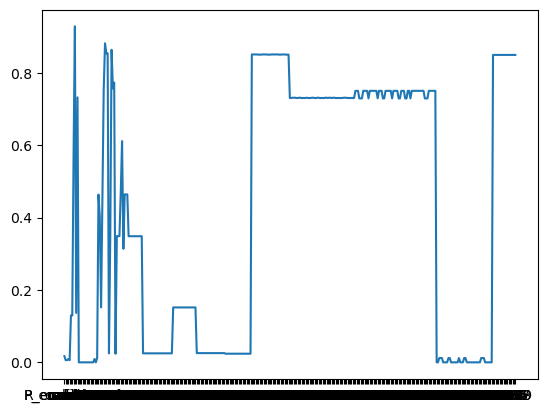

In [56]:
plt.plot(na_columns[na_columns>0]/test_transaction_data.shape[0])

In [59]:
# https://www.kaggle.com/fchmiel/day-and-time-powerful-predictive-feature
test_transaction_data['Transaction_dow'] = np.floor((test_transaction_data['TransactionDT'] / (3600 * 24) - 1) % 7)
test_transaction_data['Transaction_hour'] = np.floor(test_transaction_data['TransactionDT'] / 3600) % 24
transaction_data_columns = test_transaction_data.columns
numericCols = test_transaction_data._get_numeric_data().columns
categoricalCols = list(set(transaction_data_columns) - set(numericCols))
test_transaction_data[categoricalCols] = test_transaction_data[categoricalCols].replace({ np.nan:'missing'})
test_transaction_data[numericCols] = test_transaction_data[numericCols].replace({ np.nan:-1})

In [60]:
identity_data_columns = test_identity_data.columns
numericCols = test_identity_data._get_numeric_data().columns
categoricalCols = list(set(identity_data_columns) - set(numericCols))
test_identity_data[categoricalCols] = test_identity_data[categoricalCols].replace({ np.nan:'missing'})
test_identity_data[numericCols] = test_identity_data[numericCols].replace({ np.nan:-1})
test_identity_data['id_31'] = test_identity_data['id_31'].str.replace('\d+', '')

test_identity_data.loc[test_identity_data['id_30'].str.contains('Mac', na=False), 'id_30'] = 'mac'
test_identity_data.loc[test_identity_data['id_30'].str.contains('iOS', na=False), 'id_30'] = 'iOS'
test_identity_data.loc[test_identity_data['id_30'].str.contains('Android', na=False), 'id_30'] = 'android'
test_identity_data.loc[test_identity_data['id_30'].str.contains('Windows', na=False), 'id_30'] = 'Windows'
test_identity_data.loc[test_identity_data['id_30'].str.contains('Linux', na=False), 'id_30'] = 'Linux'
test_identity_data['device_name'] = test_identity_data['DeviceInfo'].str.split('/', expand=True)[0]

test_identity_data.loc[test_identity_data['device_name'].str.contains('SM', na=False), 'device_name'] = 'Samsung'
test_identity_data.loc[test_identity_data['device_name'].str.contains('SAMSUNG', na=False), 'device_name'] = 'Samsung'
test_identity_data.loc[test_identity_data['device_name'].str.contains('GT-', na=False), 'device_name'] = 'Samsung'
test_identity_data.loc[test_identity_data['device_name'].str.contains('Moto G', na=False), 'device_name'] = 'Motorola'
test_identity_data.loc[test_identity_data['device_name'].str.contains('Moto', na=False), 'device_name'] = 'Motorola'
test_identity_data.loc[test_identity_data['device_name'].str.contains('moto', na=False), 'device_name'] = 'Motorola'
test_identity_data.loc[test_identity_data['device_name'].str.contains('LG-', na=False), 'device_name'] = 'LG'
test_identity_data.loc[test_identity_data['device_name'].str.contains('rv:', na=False), 'device_name'] = 'RV'
test_identity_data.loc[test_identity_data['device_name'].str.contains('HUAWEI', na=False), 'device_name'] = 'Huawei'
test_identity_data.loc[test_identity_data['device_name'].str.contains('ALE-', na=False), 'device_name'] = 'Huawei'
test_identity_data.loc[test_identity_data['device_name'].str.contains('-L', na=False), 'device_name'] = 'Huawei'
test_identity_data.loc[test_identity_data['device_name'].str.contains('Blade', na=False), 'device_name'] = 'ZTE'
test_identity_data.loc[test_identity_data['device_name'].str.contains('BLADE', na=False), 'device_name'] = 'ZTE'
test_identity_data.loc[test_identity_data['device_name'].str.contains('Linux', na=False), 'device_name'] = 'Linux'
test_identity_data.loc[test_identity_data['device_name'].str.contains('XT', na=False), 'device_name'] = 'Sony'
test_identity_data.loc[test_identity_data['device_name'].str.contains('HTC', na=False), 'device_name'] = 'HTC'
test_identity_data.loc[test_identity_data['device_name'].str.contains('ASUS', na=False), 'device_name'] = 'Asus'

test_identity_data.loc[test_identity_data.device_name.isin(test_identity_data.device_name.value_counts()[test_identity_data.device_name.value_counts() < 200].index), 'device_name'] = "Others"

C:\Users\Mehrad Tavanamehr\AppData\Local\Temp\ipykernel_10956\1154278697.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  test_identity_data['id_31'] = test_identity_data['id_31'].str.replace('\d+', '')


In [61]:
raw_test_data = pd.merge(test_transaction_data, test_identity_data, on='TransactionID', how='left')
transactionID = raw_test_data.loc[:,'TransactionID']
del test_identity_data,test_transaction_data

In [63]:
raw_test_data_columns = raw_test_data.columns
numericCols = raw_test_data._get_numeric_data().columns
categoricalCols = list(set(raw_test_data_columns) - set(numericCols))
print('The categorical columns in training data are: ',categoricalCols)
raw_test_data[categoricalCols] = raw_test_data[categoricalCols].replace({ np.nan:'missing'})
raw_test_data[numericCols] = raw_test_data[numericCols].replace({ np.nan:-1})
raw_test_data = reduce_memory_usage(raw_test_data, deep=True, verbose=True)

The categorical columns in training data are:  ['M1', 'M9', 'DeviceInfo', 'M7', 'card6', 'M2', 'ProductCD', 'id_35', 'id_37', 'id_12', 'id_38', 'id_15', 'id_29', 'card4', 'id_36', 'id_23', 'id_28', 'P_emaildomain', 'id_27', 'id_31', 'M6', 'id_16', 'device_name', 'M3', 'M5', 'R_emaildomain', 'id_34', 'M8', 'id_33', 'id_30', 'M4', 'DeviceType']
Column 'TransactionID' converted from int64 to int32
Column 'TransactionDT' converted from int64 to int32
Column 'TransactionAmt' converted from float64 to float32
Column 'card1' converted from int64 to int16
Column 'card2' converted from float64 to float32
Column 'card3' converted from float64 to float32
Column 'card5' converted from float64 to float32
Column 'addr1' converted from float64 to float32
Column 'addr2' converted from float64 to float32
Column 'dist1' converted from float64 to float32
Column 'dist2' converted from float64 to float32
Column 'C1' converted from float64 to float32
Column 'C2' converted from float64 to float32
Column 'C3'

Column 'V156' converted from float64 to float32
Column 'V157' converted from float64 to float32
Column 'V158' converted from float64 to float32
Column 'V159' converted from float64 to float32
Column 'V160' converted from float64 to float32
Column 'V161' converted from float64 to float32
Column 'V162' converted from float64 to float32
Column 'V163' converted from float64 to float32
Column 'V164' converted from float64 to float32
Column 'V165' converted from float64 to float32
Column 'V166' converted from float64 to float32
Column 'V167' converted from float64 to float32
Column 'V168' converted from float64 to float32
Column 'V169' converted from float64 to float32
Column 'V170' converted from float64 to float32
Column 'V171' converted from float64 to float32
Column 'V172' converted from float64 to float32
Column 'V173' converted from float64 to float32
Column 'V174' converted from float64 to float32
Column 'V175' converted from float64 to float32
Column 'V176' converted from float64 to 

Column 'id_21' converted from float64 to float32
Column 'id_22' converted from float64 to float32
Column 'id_24' converted from float64 to float32
Column 'id_25' converted from float64 to float32
Column 'id_26' converted from float64 to float32
Column 'id_32' converted from float64 to float32
Memory usage decreased from 2535.42MB to 1753.57MB (781.85MB, 30.84% reduction)


In [64]:
test_data = raw_test_data.loc[:,featuresToUse]
#https://www.kaggle.com/artgor/eda-and-models#Feature-engineering
test_data['TransactionAmt_to_mean_card1'] = test_data['TransactionAmt'] / test_data.groupby(['card1'])['TransactionAmt'].transform('mean')
test_data['TransactionAmt_to_mean_card4'] = test_data['TransactionAmt'] / test_data.groupby(['card4'])['TransactionAmt'].transform('mean')
test_data['TransactionAmt_to_mean_card5'] = test_data['TransactionAmt'] / test_data.groupby(['card5'])['TransactionAmt'].transform('mean')
test_data['TransactionAmt_to_mean_addr1'] = test_data['TransactionAmt'] / test_data.groupby(['addr1'])['TransactionAmt'].transform('mean')
test_data['TransactionAmt_to_mean_id31'] = test_data['TransactionAmt'] / test_data.groupby(['id_31'])['TransactionAmt'].transform('mean')
test_data['TransactionAmt_to_mean_devicename'] = test_data['TransactionAmt'] / test_data.groupby(['device_name'])['TransactionAmt'].transform('mean')
test_data['TransactionAmt_to_mean_C1'] = test_data['TransactionAmt'] / test_data.groupby(['C1'])['TransactionAmt'].transform('mean')
test_data['TransactionAmt_to_mean_C3'] = test_data['TransactionAmt'] / test_data.groupby(['C3'])['TransactionAmt'].transform('mean')
test_data['TransactionAmt_to_mean_C5'] = test_data['TransactionAmt'] / test_data.groupby(['C5'])['TransactionAmt'].transform('mean')
test_data['TransactionAmt_to_mean_C13'] = test_data['TransactionAmt'] / test_data.groupby(['C13'])['TransactionAmt'].transform('mean')
test_data['TransactionAmt_to_std_card1'] = test_data['TransactionAmt'] / test_data.groupby(['card1'])['TransactionAmt'].transform('std')
test_data['TransactionAmt_to_std_card4'] = test_data['TransactionAmt'] / test_data.groupby(['card4'])['TransactionAmt'].transform('std')
test_data['TransactionAmt_to_std_card5'] = test_data['TransactionAmt'] / test_data.groupby(['card5'])['TransactionAmt'].transform('std')
test_data['TransactionAmt_to_std_addr1'] = test_data['TransactionAmt'] / test_data.groupby(['addr1'])['TransactionAmt'].transform('std')
test_data['TransactionAmt_to_std_id31'] = test_data['TransactionAmt'] / test_data.groupby(['id_31'])['TransactionAmt'].transform('std')
test_data['TransactionAmt_to_std_devicename'] = test_data['TransactionAmt'] / test_data.groupby(['device_name'])['TransactionAmt'].transform('std')
test_data['TransactionAmt_to_std_C1'] = test_data['TransactionAmt'] / test_data.groupby(['C1'])['TransactionAmt'].transform('std')
test_data['TransactionAmt_to_std_C3'] = test_data['TransactionAmt'] / test_data.groupby(['C3'])['TransactionAmt'].transform('std')
test_data['TransactionAmt_to_std_C5'] = test_data['TransactionAmt'] / test_data.groupby(['C5'])['TransactionAmt'].transform('std')
# New feature - decimal part of the transaction amount.
test_data['TransactionAmt_decimal'] = ((test_data['TransactionAmt'] - test_data['TransactionAmt'].astype(int)) * 1000).astype(int)

C:\Users\Mehrad Tavanamehr\AppData\Local\Temp\ipykernel_10956\2222378612.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_data['TransactionAmt_to_mean_card1'] = test_data['TransactionAmt'] / test_data.groupby(['card1'])['TransactionAmt'].transform('mean')
C:\Users\Mehrad Tavanamehr\AppData\Local\Temp\ipykernel_10956\2222378612.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_data['TransactionAmt_to_mean_card4'] = test_data['TransactionAmt'] / test_data.groupby(['card4'])['TransactionAmt'].transform('mean')
C:\Use

C:\Users\Mehrad Tavanamehr\AppData\Local\Temp\ipykernel_10956\2222378612.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_data['TransactionAmt_to_std_C3'] = test_data['TransactionAmt'] / test_data.groupby(['C3'])['TransactionAmt'].transform('std')
C:\Users\Mehrad Tavanamehr\AppData\Local\Temp\ipykernel_10956\2222378612.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_data['TransactionAmt_to_std_C5'] = test_data['TransactionAmt'] / test_data.groupby(['C5'])['TransactionAmt'].transform('std')
C:\Users\Mehrad Tava

In [65]:
test_data['card1_card2'] = test_data['card1'].astype(str) + '_' + test_data['card2'].astype(str)
test_data['addr1_dist1'] = test_data['addr1'].astype(str) + '_' + test_data['dist1'].astype(str)
test_data['card1_addr1'] = test_data['card1'].astype(str) + '_' + test_data['addr1'].astype(str)
test_data['card1_addr2'] = test_data['card1'].astype(str) + '_' + test_data['addr2'].astype(str)
test_data['card2_addr1'] = test_data['card2'].astype(str) + '_' + test_data['addr1'].astype(str)
test_data['card2_addr2'] = test_data['card2'].astype(str) + '_' + test_data['addr2'].astype(str)
test_data['card4_addr1'] = test_data['card4'].astype(str) + '_' + test_data['addr1'].astype(str)
test_data['card4_addr2'] = test_data['card4'].astype(str) + '_' + test_data['addr2'].astype(str)
test_data['DeviceInfo_P_emaildomain'] = test_data['DeviceInfo'].astype(str) + '_' + test_data['P_emaildomain'].astype(str)
test_data['P_emaildomain_addr1'] = test_data['P_emaildomain'].astype(str) + '_' + test_data['addr1'].astype(str)
test_data['id01_addr1'] = test_data['id_01'].astype(str) + '_' + test_data['addr1'].astype(str)
test_data['card1_P_emaildomain'] = test_data['card1'].astype(str) + '_' + test_data['P_emaildomain'].astype(str)
test_data['card5_P_emaildomain'] = test_data['card5'].astype(str) + '_' + test_data['P_emaildomain'].astype(str)
test_data['card2_P_emaildomain'] = test_data['card2'].astype(str) + '_' + test_data['P_emaildomain'].astype(str)
test_data['card4_P_emaildomain'] = test_data['card4'].astype(str) + '_' + test_data['P_emaildomain'].astype(str)
test_data['id_01_P_emaildomain'] = test_data['id_01'].astype(str) + '_' + test_data['P_emaildomain'].astype(str)

C:\Users\Mehrad Tavanamehr\AppData\Local\Temp\ipykernel_10956\2645532339.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_data['card1_card2'] = test_data['card1'].astype(str) + '_' + test_data['card2'].astype(str)
C:\Users\Mehrad Tavanamehr\AppData\Local\Temp\ipykernel_10956\2645532339.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_data['addr1_dist1'] = test_data['addr1'].astype(str) + '_' + test_data['dist1'].astype(str)
C:\Users\Mehrad Tavanamehr\AppData\Local\Temp\ipykernel_10956\2645532339.py:3: Performance

In [66]:
goodCategoricalVars.append('card1_addr1')
goodCategoricalVars.append('card1_addr2')
goodCategoricalVars.append('card2_addr1')
goodCategoricalVars.append('card2_addr2')
goodCategoricalVars.append('card4_addr1')
goodCategoricalVars.append('card4_addr2')
goodCategoricalVars.append('DeviceInfo_P_emaildomain')
goodCategoricalVars.append('P_emaildomain_addr1')
goodCategoricalVars.append('id01_addr1')
goodCategoricalVars.append('card1_card2')
goodCategoricalVars.append('device_name')
goodCategoricalVars.append('addr1_dist1')
goodCategoricalVars.append('card1_P_emaildomain')
goodCategoricalVars.append('card5_P_emaildomain')
goodCategoricalVars.append('card2_P_emaildomain')
goodCategoricalVars.append('card4_P_emaildomain')
goodCategoricalVars.append('id_01_P_emaildomain')
from sklearn.preprocessing import LabelEncoder
for i_cat in goodCategoricalVars:
    le = LabelEncoder()
    curData = pd.concat([train_data.loc[:,i_cat],test_data.loc[:,i_cat]],axis = 0)
    le.fit(curData)
    train_data.loc[:,i_cat] = le.transform(train_data.loc[:,i_cat])      
    test_data.loc[:,i_cat] = le.transform(test_data.loc[:,i_cat])    

In [67]:
print('The shape of training data is:',np.shape(train_data))
del raw_test_data

The shape of training data is: (590540, 470)


In [68]:
from sklearn.model_selection import StratifiedKFold,GroupKFold
from sklearn.metrics import roc_curve, auc
from lightgbm import LGBMClassifier
import lightgbm as lgb

#group_kfold = GroupKFold(n_splits=5)
cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)

In [69]:
def compute_roc_auc(clf,index):
    y_predict = clf.predict_proba(train_data.iloc[index])[:,1]
    fpr, tpr, thresholds = roc_curve(target_data.iloc[index], y_predict)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score

In [70]:
params = {'bagging_fraction': 0.7982116702024386,
          'feature_fraction': 0.1785051643813966,
          'max_depth': int(49.17611603427576),
          'min_child_weight': 3.2852905549011155,
          'min_data_in_leaf': int(31.03480802715621),
          'n_estimators': 50,#int(1491.3676131788188), -5000
          'num_leaves': int(52.851307790411965),
          'reg_alpha': 0.45963319421692145,
          'reg_lambda': 0.6591286807489907,
          'metric':'auc',
          'boosting_type': 'gbdt',
          'colsample_bytree':.8,
          'subsample':.9,
          'min_split_gain':.01,
          'max_bin':127,
          'bagging_freq':5,
          'learning_rate':0.01,
          'early_stopping_rounds':100
}

In [71]:
fprs_lgb, tprs_lgb, scores_lgb = [], [], []
feature_importances = pd.DataFrame()
feature_importances['feature'] = train_data.columns     
predictions = np.zeros(len(test_data))
for (train, test), i in zip(cv.split(train_data, target_data), range(5)): #5
    lgb_best = LGBMClassifier(boosting = params['boosting_type'],n_estimators =  params['n_estimators'],
                     learning_rate =  params['learning_rate'],num_leaves =  params['num_leaves'],
                     colsample_bytree = params['colsample_bytree'],subsample =  params['subsample'],
                     max_depth =  params['max_depth'],reg_alpha =  params['reg_alpha'],
                     reg_lambda =  params['reg_lambda'],min_split_gain =  params['min_split_gain'],
                     min_child_weight =  params['min_child_weight'],max_bin =  params['max_bin'],
                     bagging_freq =  params['bagging_freq'],feature_fraction =  params['feature_fraction'],
                     bagging_fraction =  params['bagging_fraction'],min_data_in_leaf = params['min_data_in_leaf'],
                             early_stopping_rounds = params['early_stopping_rounds'])
    lgb_best.fit(train_data.iloc[train,:], target_data.iloc[train],
                 eval_set = [(train_data.iloc[train,:], target_data.iloc[train]), 
                             (train_data.iloc[test,:], target_data.iloc[test])],eval_metric='auc',verbose = 200)    
    feature_importances['fold_{}'.format(i + 1)] = lgb_best.feature_importances_
    _, _, auc_score_train = compute_roc_auc(lgb_best,train)
    fpr, tpr, auc_score = compute_roc_auc(lgb_best,test)
    scores_lgb.append((auc_score_train, auc_score))
    fprs_lgb.append(fpr)
    tprs_lgb.append(tpr) 
    predictions += lgb_best.predict_proba(test_data, num_iteration=lgb_best.best_iteration_)[:,1]

D:\Anaconda\Documents\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.1785051643813966, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.1785051643813966
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] bagging_fraction is set=0.7982116702024386, subsample=0.9 will be ignored. Current value: bagging_fraction=0.7982116702024386
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100


D:\Anaconda\Documents\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.1785051643813966, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.1785051643813966
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] bagging_fraction is set=0.7982116702024386, subsample=0.9 will be ignored. Current value: bagging_fraction=0.7982116702024386
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100


D:\Anaconda\Documents\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.1785051643813966, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.1785051643813966
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] bagging_fraction is set=0.7982116702024386, subsample=0.9 will be ignored. Current value: bagging_fraction=0.7982116702024386
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100


D:\Anaconda\Documents\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.1785051643813966, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.1785051643813966
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] bagging_fraction is set=0.7982116702024386, subsample=0.9 will be ignored. Current value: bagging_fraction=0.7982116702024386
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100


D:\Anaconda\Documents\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.1785051643813966, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.1785051643813966
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] bagging_fraction is set=0.7982116702024386, subsample=0.9 will be ignored. Current value: bagging_fraction=0.7982116702024386
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100


In [72]:
predictions /= cv.n_splits

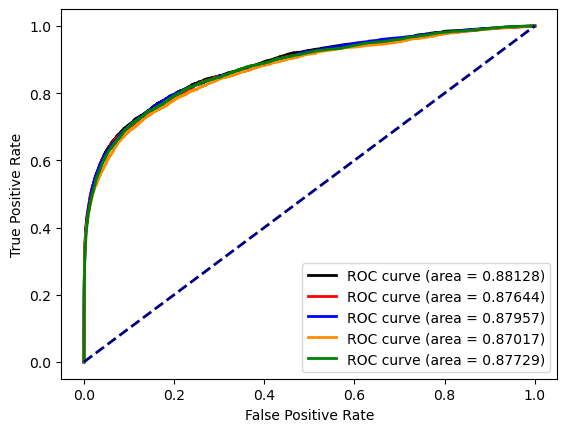

In [73]:
plt.figure()
lw = 2
colors = ['black','red','blue','darkorange','green']
for i in range(0,5):
    plt.plot(fprs_lgb[i], tprs_lgb[i], color=colors[i],
             lw=lw, label='ROC curve (area = %0.5f)' % scores_lgb[i][1])
    
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [74]:
scores_lgb

[(0.8783098697350649, 0.8812785557561378),
 (0.880182943916154, 0.8764415058576894),
 (0.8792769886709211, 0.8795697032859018),
 (0.8810443822949043, 0.8701725650206952),
 (0.8792788501874015, 0.877288022558973)]

In [75]:
print('Mean AUC:', np.mean(scores_lgb,axis = 0))

Mean AUC: [0.87961861 0.87695007]


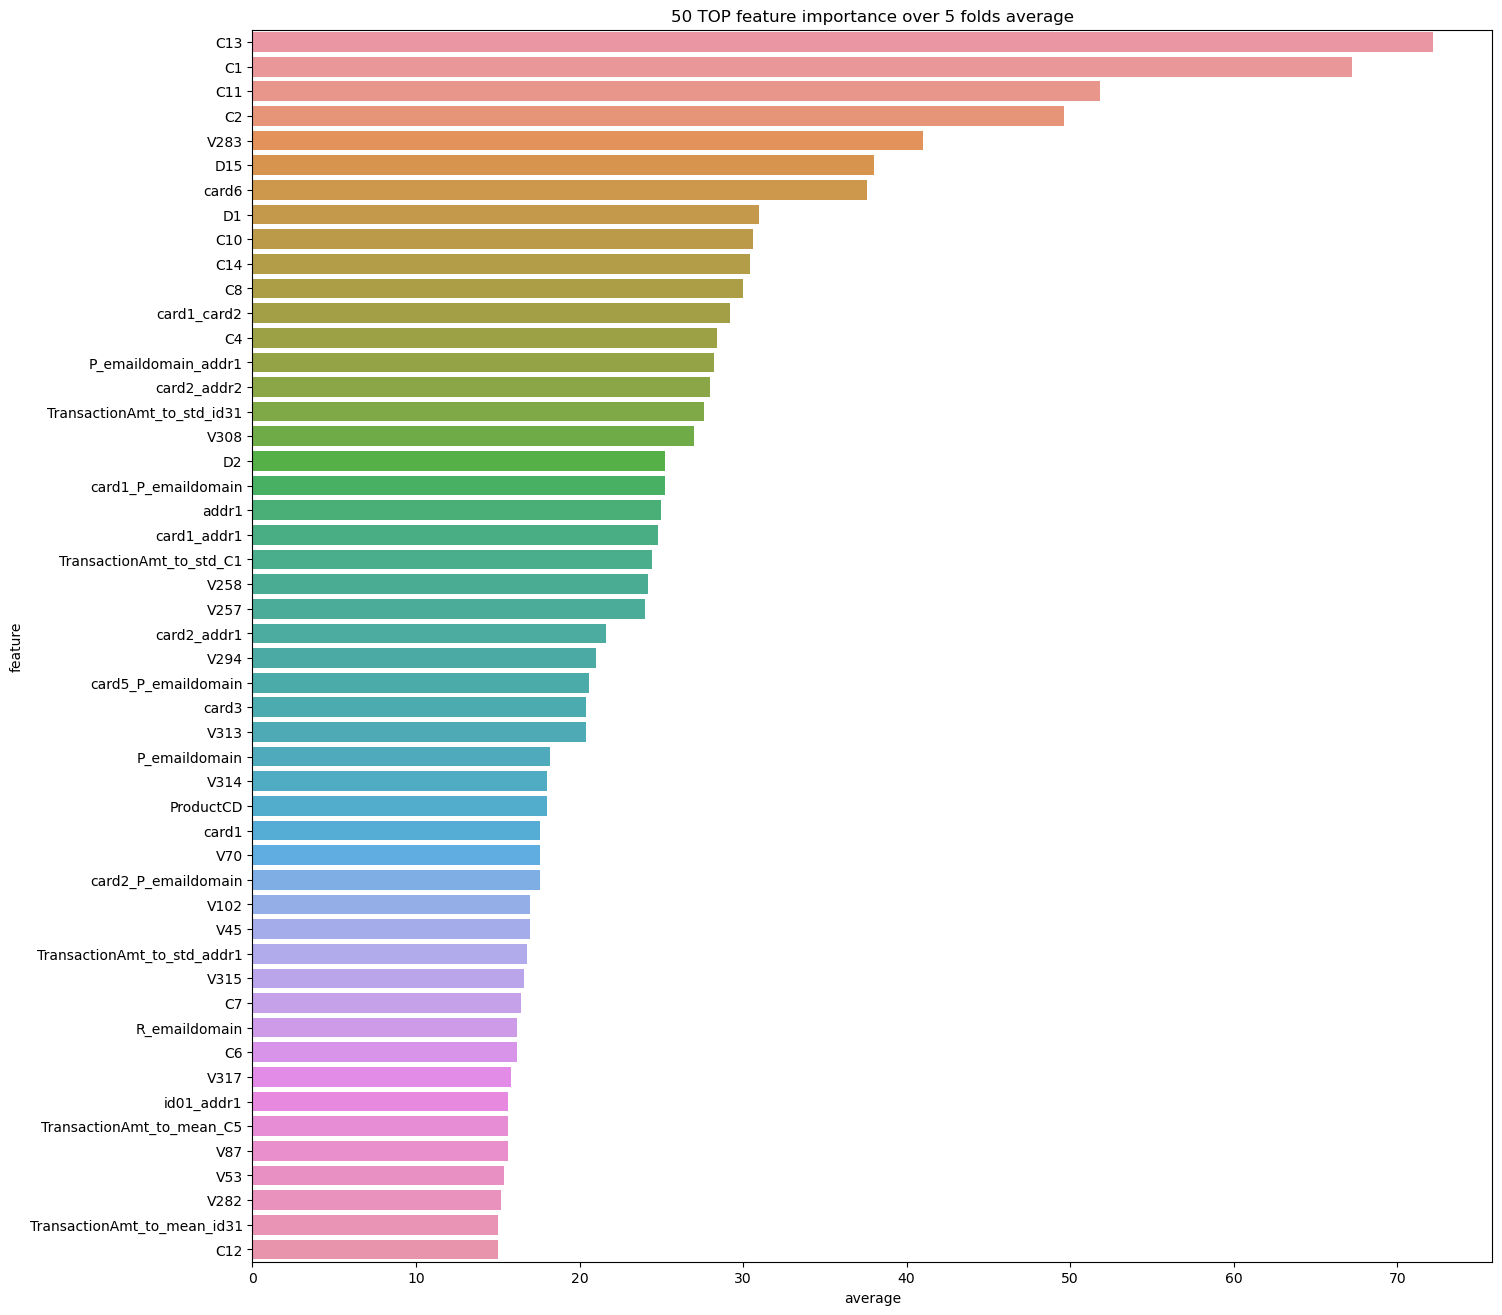

In [76]:
feature_importances['average'] = feature_importances[['fold_{}'.format(fold + 1) for fold in range(cv.n_splits)]].mean(axis=1)
plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} folds average'.format(cv.n_splits));

In [77]:
#del train_data,target_data

data = {'TransactionID':transactionID,'isFraud':predictions}
submissionDF = pd.DataFrame(data)
submissionDF.to_csv('sample_submission.csv',index=False)

### Other traditional ML

In [91]:
train_data.isnull().sum()

TransactionAmt                          0
card1                                   0
card2                                   0
card3                                   0
card5                                   0
addr1                                   0
addr2                                   0
dist1                                   0
dist2                                   0
C1                                      0
C2                                      0
C3                                      0
C4                                      0
C5                                      0
C6                                      0
C7                                      0
C8                                      0
C9                                      0
C10                                     0
C11                                     0
C12                                     0
C13                                     0
C14                                     0
D1                                

In [100]:
exp_train_data = train_data.drop(['TransactionAmt_to_std_card1','TransactionAmt_to_std_card5','TransactionAmt_to_std_addr1',
                'TransactionAmt_to_std_id31','TransactionAmt_to_std_C1','TransactionAmt_to_std_C3','TransactionAmt_to_std_C5'],
               axis=1)

In [106]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
# evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
# calculating process time
from time import process_time

In [107]:
X_train, X_test, y_train, y_test = train_test_split(exp_train_data, target_data, test_size=0.10, random_state = 0)

#### Default training

In [110]:
default_result = {}
def traditional_classification_model_default(X_train, X_val, y_train, y_val, kind=['RandomForest','LogisticRegression','SVM']):
  # This function is defined for default model of each algorithms
  import math
  if kind == 'RandomForest':
    model = RandomForestClassifier()
  elif kind == 'LogisticRegression':
    model = LogisticRegression()
  elif kind == 'SVM':
    model = SVC()
  start_t = process_time()
  model.fit(X_train, y_train)
  end_t = process_time()
  # evaluation
  y_val_pred = model.predict(X_val)
  accuracy = accuracy_score(y_val, y_val_pred)
  f1_scores = f1_score(y_val, y_val_pred)
  typeII_count = confusion_matrix(y_val, y_val_pred)[1][0]
  default_result[kind] = [end_t-start_t,accuracy,f1_scores,typeII_count]
  print(f"Classification report {kind}:")
  print(classification_report(y_val, y_val_pred))
  return default_result

In [ ]:
default_results = {}
models = ['RandomForest','LogisticRegression','SVM']
for item in models:
  default_results[item] = traditional_classification_model_default(X_train, X_test, y_train, y_test,item)

Classification report RandomForest:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     57049
           1       0.95      0.48      0.63      2005

    accuracy                           0.98     59054
   macro avg       0.96      0.74      0.81     59054
weighted avg       0.98      0.98      0.98     59054



D:\Anaconda\Documents\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification report LogisticRegression:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     57049
           1       0.16      0.00      0.00      2005

    accuracy                           0.97     59054
   macro avg       0.56      0.50      0.49     59054
weighted avg       0.94      0.97      0.95     59054



In [ ]:
pd_default_result = pd.DataFrame(default_results).T
pd_default_result.index.name = 'Default Model'
pd_default_result.columns = ['Training_time', 'accuracy', 'f1_score', 'typeII_count']
pd_default_result.sort_index()

#### Tunning parameters

In [ ]:
model = RandomForestClassifier()
tuned_parameters = [{'n_estimators':[10,20,50],
                     'max_leaf_nodes': range(10,15),
                     'max_depth':range(5,7)}]
clf = GridSearchCV(model, tuned_parameters, 
                   verbose=1, n_jobs=-1)
tuned_model = clf.fit(X_train,y_train)

In [ ]:
print(tuned_model.best_params_)

In [ ]:
model = LogisticRegression()
tuned_parameters = [{'C': [100.0,150.0,200.0,250.0],
                     'max_iter': range(30,35)}]
clf = GridSearchCV(model, tuned_parameters, 
                   verbose=1, n_jobs=-1)
tuned_model = clf.fit(X_train,y_train)

In [ ]:
print(tuned_model.best_params_)

In [ ]:
model = SVC()
tuned_parameters = [{'C':range(10,13),
                     'gamma':range(1,6),
                     'kernel':['rbf']}]
clf = GridSearchCV(model, tuned_parameters, 
                   verbose=1, n_jobs=-1)
tuned_model = clf.fit(X_train,y_train)

In [ ]:
print(tuned_model.best_params_)

#### Tunned training

In [ ]:
tunned_result = {}
def traditional_classification_model_tunned(X_train, X_val, y_train, y_val, kind=['RandomForest','LogisticRegression','SVM']):
  # This function is defined for default model of each algorithms
  import math
  if kind == 'RandomForest':
    model = RandomForestClassifier()
  elif kind == 'LogesticRegression':
    model = LogisticRegression()
  elif kind == 'SVM':
    model = SVC()
  start_t = process_time()
  model.fit(X_train, y_train)
  end_t = process_time()
  # evaluation
  y_val_pred = model.predict(X_val)
  # r2 score
  accuracy = accuracy_score(y_val, y_val_pred)
  f1_scores = f1_score(y_val, y_val_pred)
  typeII_count = confusion_matrix(y_val, y_val_pred)[1][0]
  default_result[kind] = [end_t-start_t,accuracy,f1_scores,typeII_count]
  print(f"Classification report {kind}:")
  print(classification_report(y_val, y_val_pred))
  return tunned_result

In [ ]:
tunned_results = {}
models = ['RandomForest','LogisticRegression','SVM']
for item in models:
  tunned_results[item] = traditional_classification_model_default(X_train, X_test, y_train, y_test,item)

In [ ]:
pd_tunned_result = pd.DataFrame(tunned_results).T
pd_tunned_result.index.name = 'Tunned Model'
pd_tunned_result.columns = ['Training_time', 'accuracy', 'f1_score', 'typeII_count']
pd_tunned_result.sort_index()